![title](./input/Infinitech-Logo-Full-1960x265.png)

# Cashflow prediciton and evaluation
### Author(s): George Makridis (gmakridis@unipi.com), Dimitris Kotios (dkotios@unipi.com)

### Introduction

In this pilot we develop a Business Financial Management (BFM) tool to assist Small and Medium sized enterprises (SMEs) in managing their financial health in the areas of,among others, cash flow management, continuous spending/cost analysis, budgeting, revenue review. 

The main innovation of the pilot lies in the provision of automated and predictive assistance to SMEs about how to plan future liquidity needs and fulfil their obligations, basen mainly on AI and Data models.

Main stakeholders of the pilot development include Bank of Cyprus (BOC) and University of Piraeus Research
Centre (UPRC). BOC is providing a variety of data mainly regarding its SME clients and their respective
transactions, while also being the key driver in designing the Business Financial Management toolkit, which
will generate valuable insights and add value to the existing online services for SME beneficiaries. UPRC is
working closely with BOC on designing all provided services. It is responsible for the development of all
required ML/DL algorithms of the pilot and the technical support of the pilot’s implementation throughout
the project.

The pilot leverages a variety of data related to SMEs accounts from Bank of Cyprus’ operation data
warehouse, which include: (i) account, (ii) customer and (iii) transaction data.

This notebook will showcase the second microservice, namely the Cash Flow Prediction Engine, which aims to accurately predict the cash inflows and outflows of the given categories each account of an SME. 

The Engine’s objective and the nature of the task implied the necessary data transformation in time-series representation, enabling the experimentation with various general forecasting models or prevalent DL models. Thus, both resampling and aggregating the amount of the transactions based on each specific account and date have been applied to our data sample. After many trials the DeepAR model was chosen as the main model for this forecasting task. 

### Explanatory Data Analysis

#### Import libraries/frameworks

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import missingno as msno
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)

#### Loading the data

To the best of our knowledge, there is no open-source dataset including SMEs transactions. Within the project, the utilized dataset had been provided by Bank of Cyprus as a real-world use case, composed by tokenized transaction attributes of the bank’s clients (i.e. SMEs). These data include transactions, customers and accounts data of over a thousand SMEs for the years 2017 to 2020, exceeding 3,5 million data entries. As many variables were included in the datasets obtained by the bank, the main categories and variables / features utilized in our approach are presented in the table below. 

It should be mentioned that the data were already categorized by another component of the BFM services.

##### Transactions Data

In [15]:
transactions_df=pd.read_csv('results_step_v3.csv', parse_dates=['TransactionDate'])

/home/researcher/anaconda3/envs/agroknow_ner/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
transactions_df.head(5)

skAcctKey  TransactionID Transactioncode TransactionDate  \
0   10000332      282635843            4300      2019-09-26   
1   10000332      288842677            4300      2019-10-18   
2   10000332      290967314            4300      2019-10-26   
3   10000332      296442105            4300      2019-11-14   
4   10000332      305511645            4300      2019-12-15   

  OriginatorBankCode BeneficiaryBankCode TransactionTypeCode  CardNumber  \
0                NaN                 NaN                4300         NaN   
1                NaN                 NaN                4300         NaN   
2                NaN                 NaN                4300         NaN   
3                NaN                 NaN                4300         NaN   
4                NaN                 NaN                4300         NaN   

   OriginalAmount CurrencyCode  Amount     TransactionDescription  \
0          5000.0          EUR  5000.0  4300INTERNAL TRANSFER(IB)   
1          3000.0          EUR  3000.0  4300INTERNAL TRANSFER(IB)   
2          5000.0          EUR  5000.0  4300INTERNAL TRANSFER(IB)   
3          2000.0          EUR  2000.0  4300INTERNAL TRANSFER(IB)   
4          5000.0          EUR  5000.0  4300INTERNAL TRANSFER(IB)   

   skTransferAcctKey ChannelCode  CashierIndicator BranchIndicator  \
0           800804.0           I               0.0               0   
1           800804.0           I               0.0               0   
2           800804.0           I               0.0               0   
3           800804.0           I               0.0               0   
4           800804.0           I               0.0               0   

   ATMIndicator  PhoneIndicator  eBankingIndicator  MobileBankingIndicator  \
0             0               0                  1                       0   
1             0               0                  1                       0   
2             0               0                  1                       0   
3             0               0                  1                       0   
4             0               0                  1                       0   

   ContactlessIndicator  QuickPayIndicator  InterbanktransferIndicator  \
0                   NaN                0.0                         NaN   
1                   NaN                0.0                         NaN   
2                   NaN                0.0                         NaN   
3                   NaN                0.0                         NaN   
4                   NaN                0.0                         NaN   

   StandingOrderIndicator TransferCountry MerchantName  MechantCode  \
0                       0             NaN          NaN          NaN   
1                       0             NaN          NaN          NaN   
2                       0             NaN          NaN          NaN   
3                       0             NaN          NaN          NaN   
4                       0             NaN          NaN          NaN   

  Debit_CreditIndicator  MCCCodeID  CardPresentIndicator  CardInstalIndicator  \
0                     C        NaN                   NaN                  NaN   
1                     C        NaN                   NaN                  NaN   
2                     C        NaN                   NaN                  NaN   
3                     C        NaN                   NaN                  NaN   
4                     C        NaN                   NaN                  NaN   

  TransferskAcctKeyNACE Trx.CodeID Master_Category                   Category  \
0                G.47.7      4300C        Transfer  Transfer btw own accounts   
1                G.47.7      4300C        Transfer  Transfer btw own accounts   
2                G.47.7      4300C        Transfer  Transfer btw own accounts   
3                G.47.7      4300C        Transfer  Transfer btw own accounts   
4                G.47.7      4300C        Transfer  Transfer btw own accounts   

          step  

In [5]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461295 entries, 0 to 3461294
Data columns (total 40 columns):
skAcctKey                     int64
TransactionID                 int64
Transactioncode               object
TransactionDate               datetime64[ns]
OriginatorBankCode            object
BeneficiaryBankCode           object
TransactionTypeCode           object
CardNumber                    float64
OriginalAmount                float64
CurrencyCode                  object
Amount                        float64
TransactionDescription        object
skTransferAcctKey             float64
ChannelCode                   object
CashierIndicator              float64
BranchIndicator               object
ATMIndicator                  int64
PhoneIndicator                int64
eBankingIndicator             int64
MobileBankingIndicator        int64
ContactlessIndicator          float64
QuickPayIndicator             float64
InterbanktransferIndicator    float64
StandingOrderIndicator    

Visualising missing values 

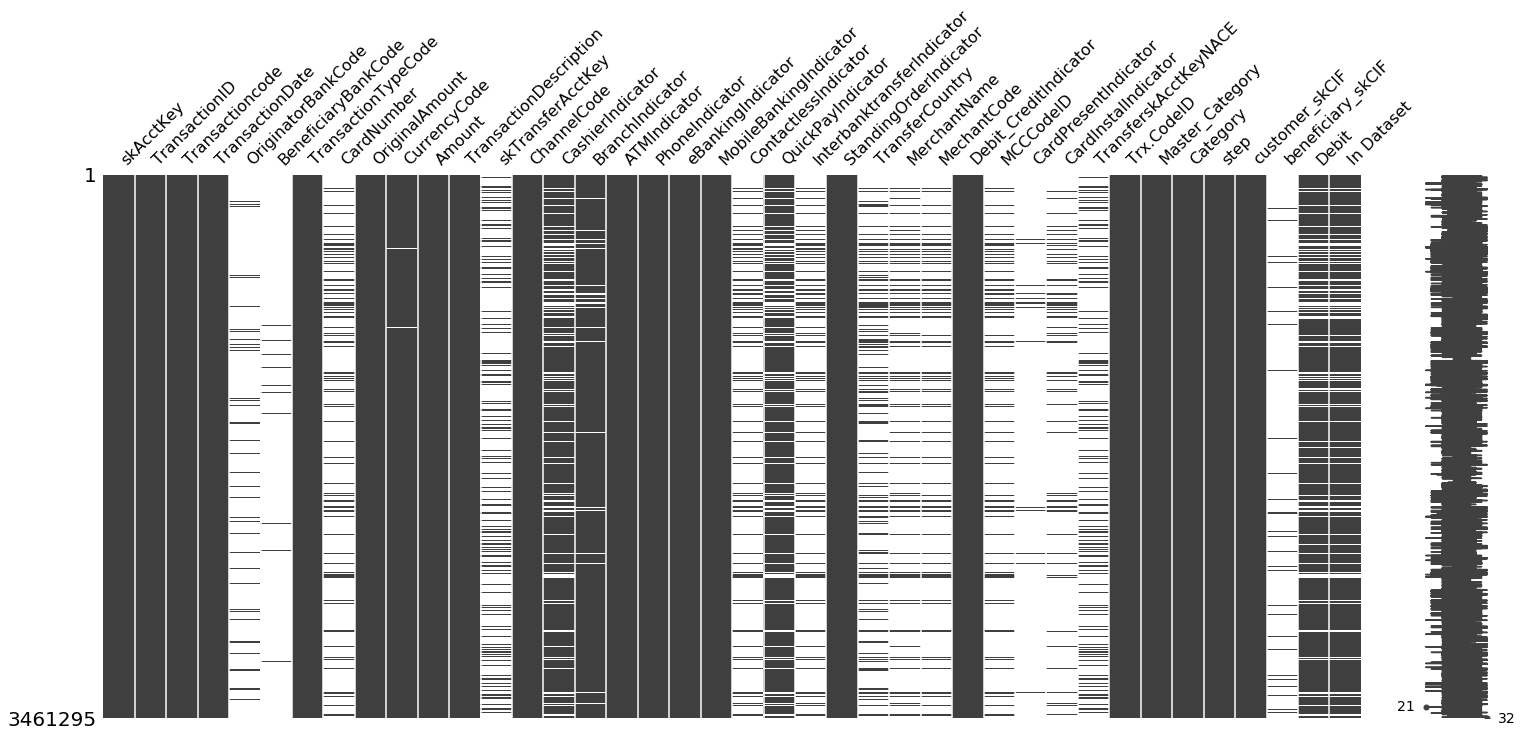

In [6]:
msno.matrix(transactions_df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

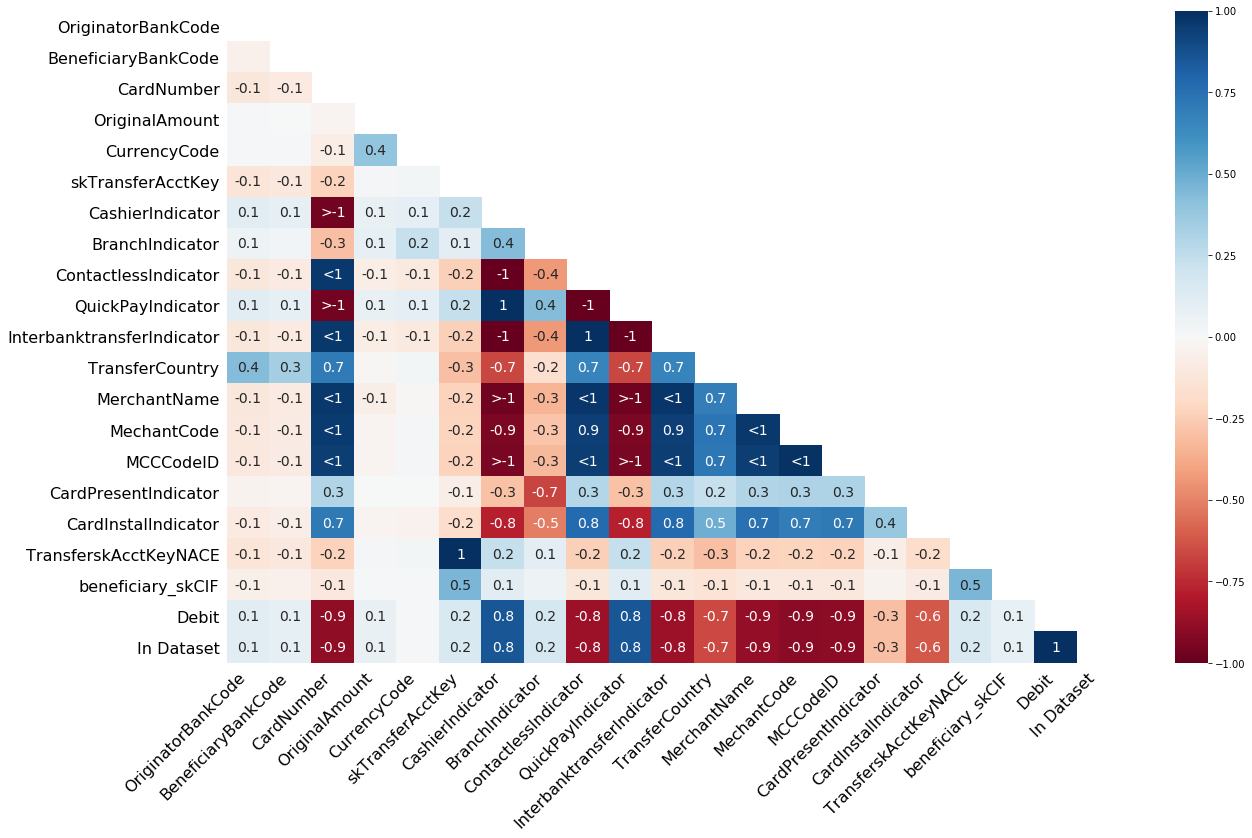

In [7]:
msno.heatmap(transactions_df)

The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:

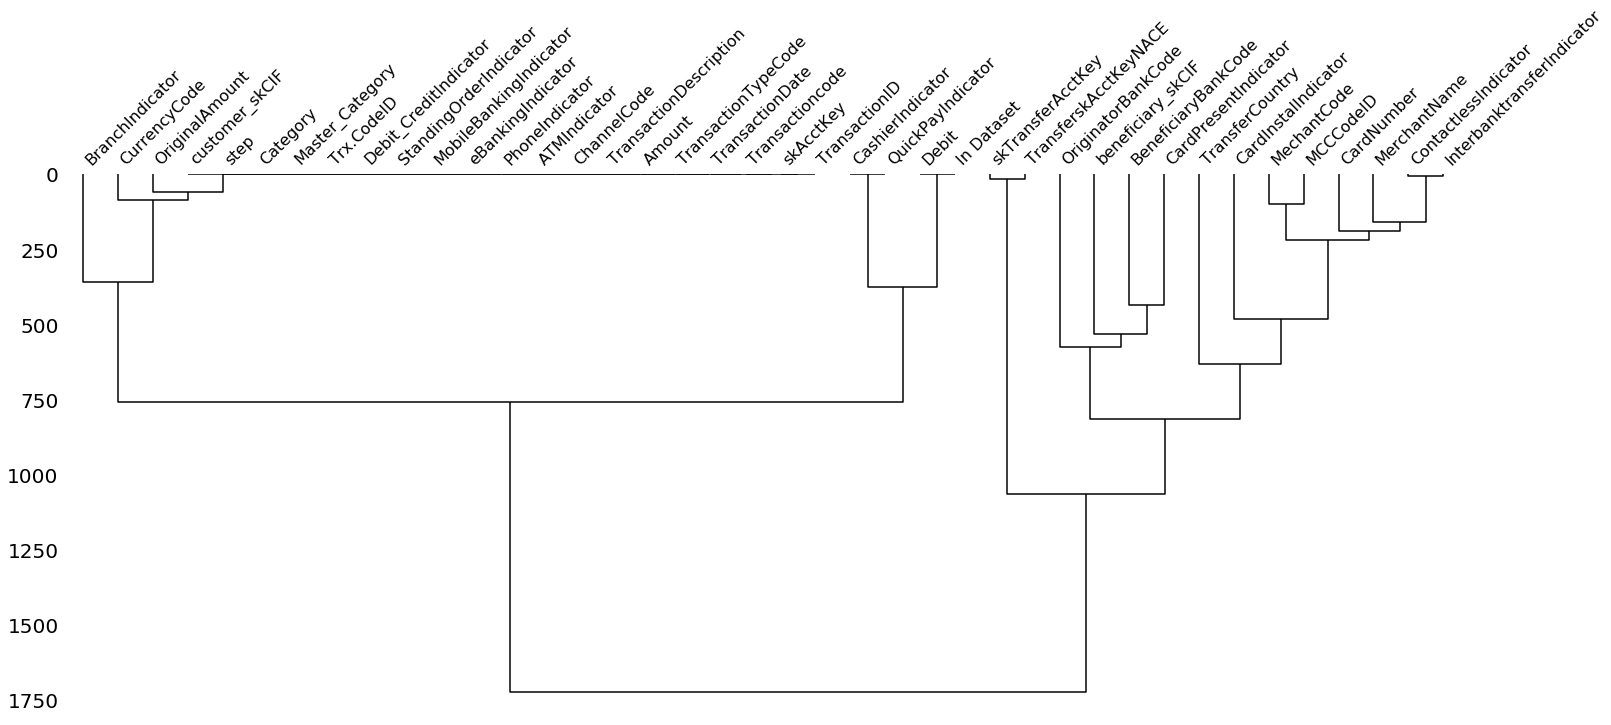

In [8]:
msno.dendrogram(transactions_df)

The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

Cluster leaves which link together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity , then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined.

### Cashflow Prediction

Besides revenues and comprehensive budgeting, having an efficient cashflow prediciton mechanism is essential for the financial success of an SME. An engine that predicts the future inflows and outflows derived from historical incomes and spendings allows the user to set budgets per category and to allocate available resources.

Furthermore, it should be noted that in terms of predictions, the prediction time-frames may be over 1/4 of a year (i.e. 3 months). These predictions aim at improving the internal financial monitoring of an enterprise and its various inflows and outflows, while also enabling professionals to ensure the business continuity of their clients (i.e. SMEs),

At the same time, given that the examined time-series case is a multi-step ahead prediction task, it should be mentioned that for time-series forecasting, the task of using observed time-series in the past to predict values in a look-ahead horizon gets proportionally harder as this horizon widens. To this end, a probabilistic approach is preferred, providing a predicted probability distribution accompanied by different confidence levels. The DeerAR is a state-of-the-art model of probabilistic forecasting leveraging a Deep Recurrent Neural Network (i.e. LSTM) for predicting the mean values and the standard deviation, while a Monte Carlo simulation providing the probability distribution of the forecast. 

The DeepAR model learns seasonal behavior patterns from given covariates which strengthens its forecasting capabilities. 

Furthermore, in order to be able to perform forecasting and reliable analysis in timeseries data, these data should be stationary. 

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends or seasonality are not stationary. Here, we can observe that all the time series have an up trend. We asume that the underlying data model (i.e. DeepAR) can handle non stationary time series given that we will use time based covariates.

For this analysis we will use only the Amount of the transactions and the date of the transaction. The Amount represents the "normalized" Original Amount in respect to the currency.
 

count    3.461295e+06
mean     3.684182e+03
std      1.943341e+04
min      0.000000e+00
25%      1.719600e+02
50%      7.000000e+02
75%      2.250000e+03
max      6.083490e+06
Name: Amount, dtype: float64


/home/researcher/anaconda3/envs/agroknow_ner/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


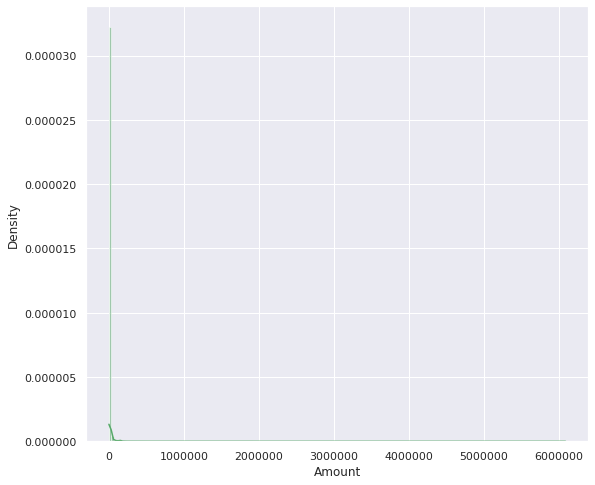

In [17]:
print(transactions_df['Amount'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(transactions_df['Amount'], color='g', bins=200, hist_kws={'alpha': 0.5});

With this information we can see that the prices are skewed right and some outliers lies. We will eventually have to think how we can tackle them as a normal distribution of the independent variable is preferable for machine learning.

When we have to handle timeseries data, always an interesting transformation is to check the distrubution over diferrent timeframes. To this end, we can create some time-based feature such as day of the week, day of the month. 

In [18]:
date_columns=['TransactionDate']
for date_column in date_columns:
    transactions_df['month'] = transactions_df[date_column].dt.month
    transactions_df['day_of_month'] = transactions_df[date_column].dt.day
    transactions_df['day_of_week'] = transactions_df[date_column].dt.dayofweek

It would be more interesting to check the distribution over the different time frames for the expenses of one account. With this approach we may produce some valuable insights regarding the "behavior" of an SME.

In [11]:
MY_ACCOUNT = 146008
my_transactions_df = transactions_df[transactions_df['skAcctKey']==MY_ACCOUNT]

We can chose "C" for Income and "D" for Expenses

count     19831.000000
mean       2232.133026
std       17933.739566
min           0.010000
25%         185.000000
50%         425.000000
75%        1050.000000
max      800000.000000
Name: Amount, dtype: float64


/home/researcher/anaconda3/envs/agroknow_ner/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


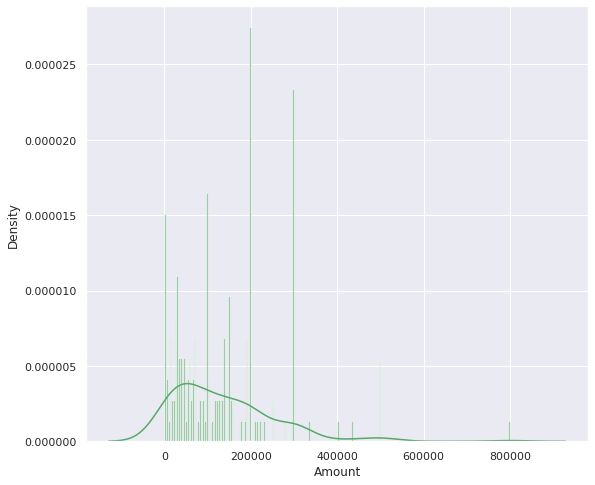

In [19]:
print(my_transactions_df['Amount'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(my_transactions_df['Amount'][my_transactions_df['Debit_CreditIndicator']=='D'], color='g', bins=200, hist_kws={'alpha': 0.5});

With this information we can see that the prices are skewed right and some outliers lies above ~50,000. We will eventually have to think how we can tackle them as a normal distribution of the independent variable is preferable for machine learning.

##### Distribuiton of Expenses against Categories of Expenses

Now lets jump to the distribution agianst each expense category to see if we can get any insights.

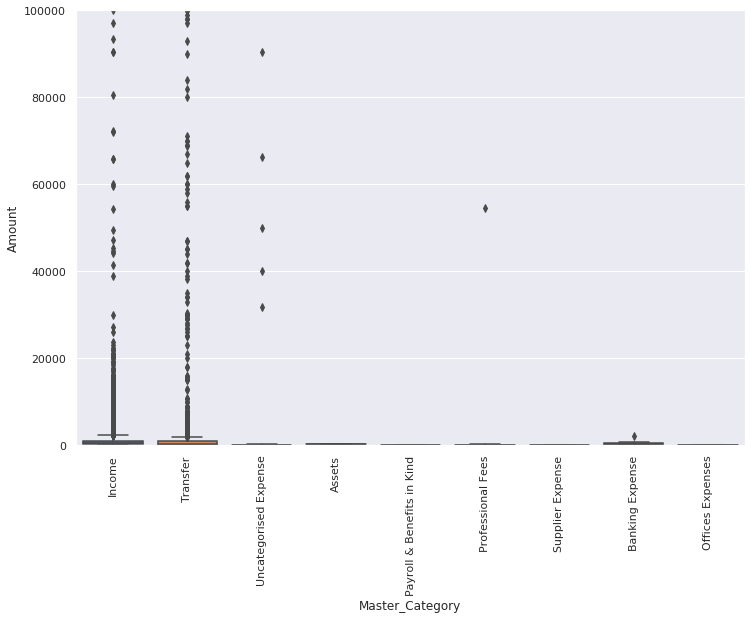

In [20]:
var = 'Master_Category'
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Amount", data=my_transactions_df)
fig.axis(ymin=0, ymax=100000)
ax.tick_params(axis='x', rotation=90)

##### Distibution in months

Income


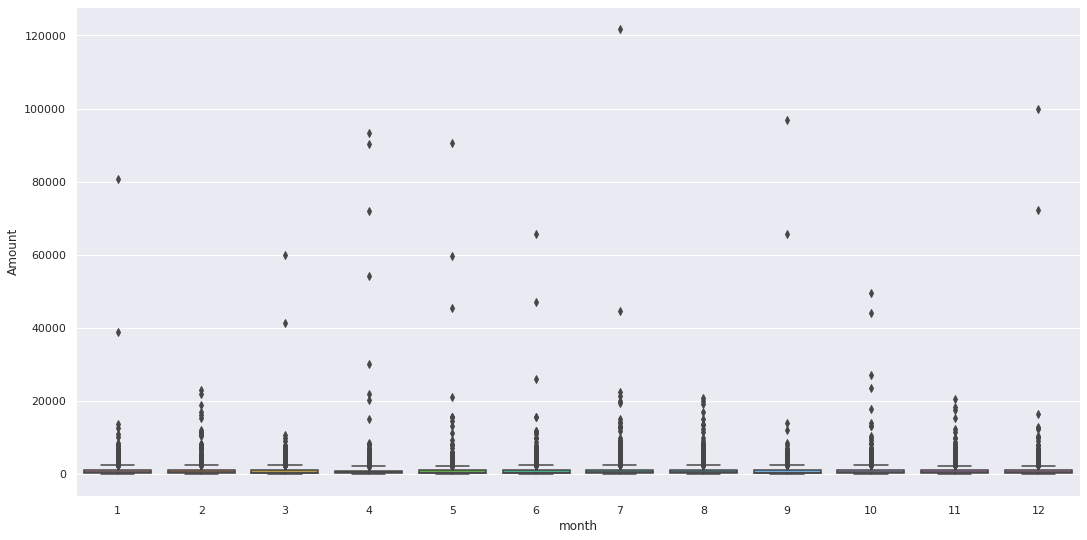

Transfer


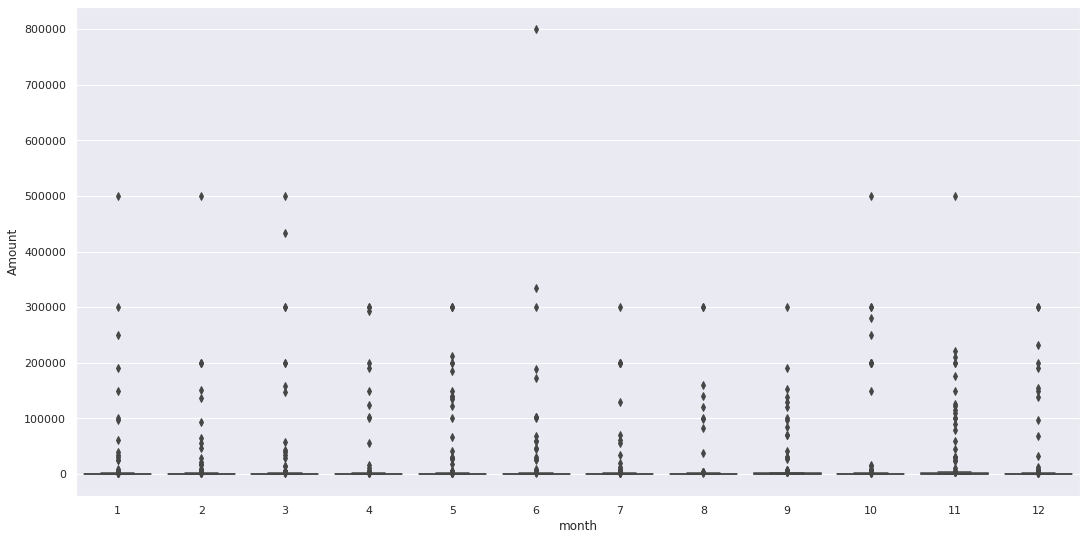

Uncategorised Expense


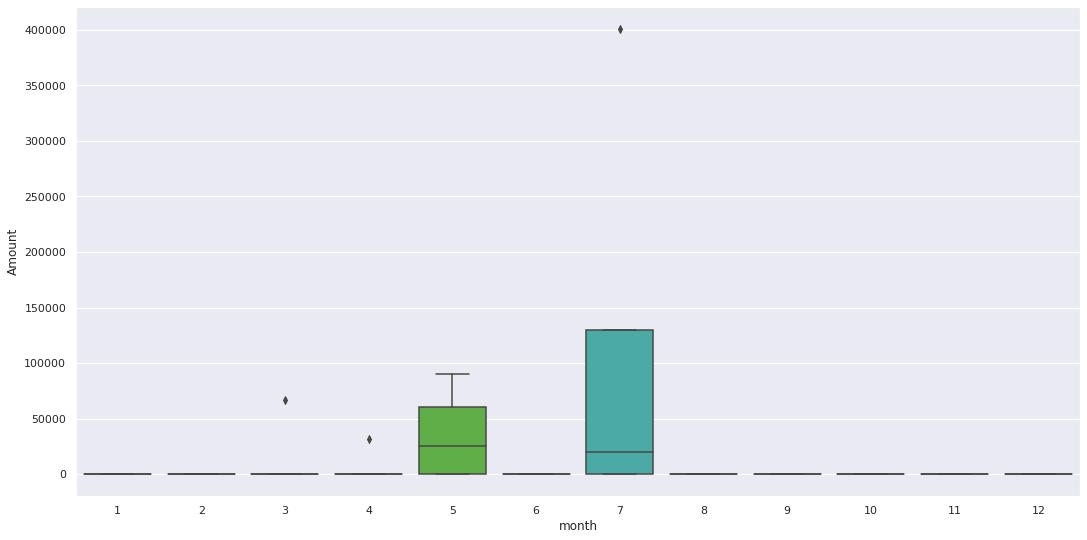

Assets


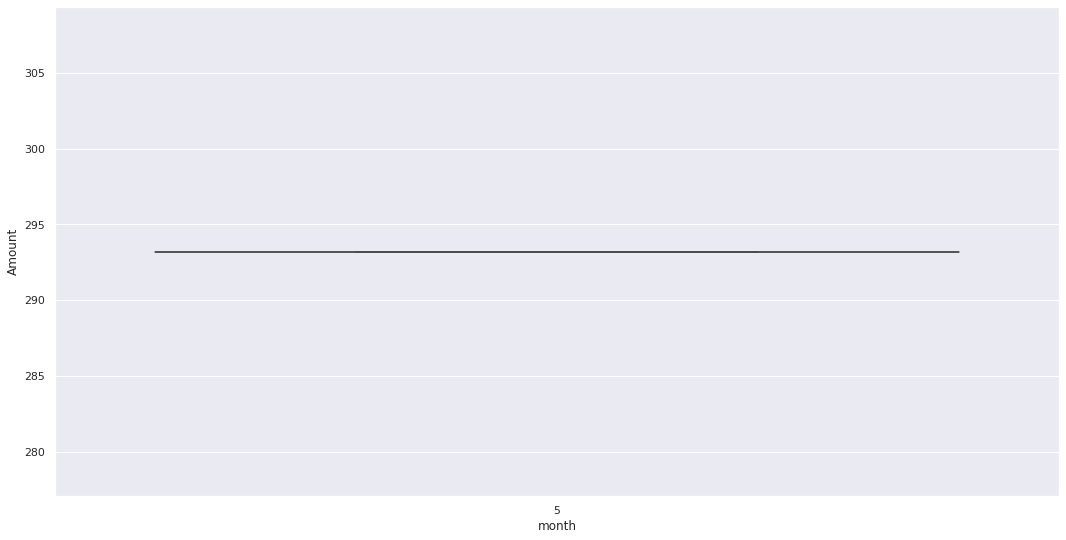

Payroll & Benefits in Kind


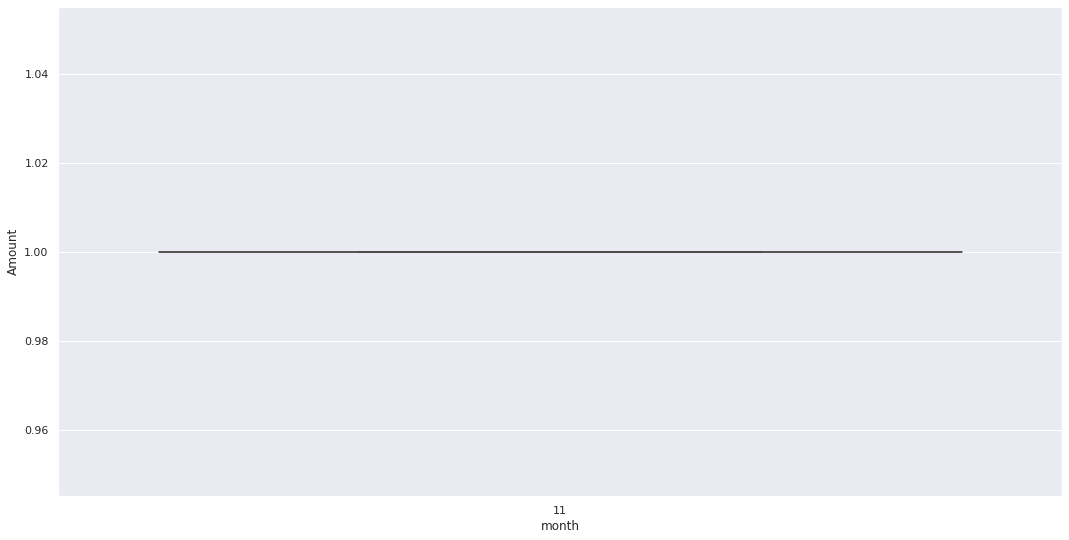

Professional Fees


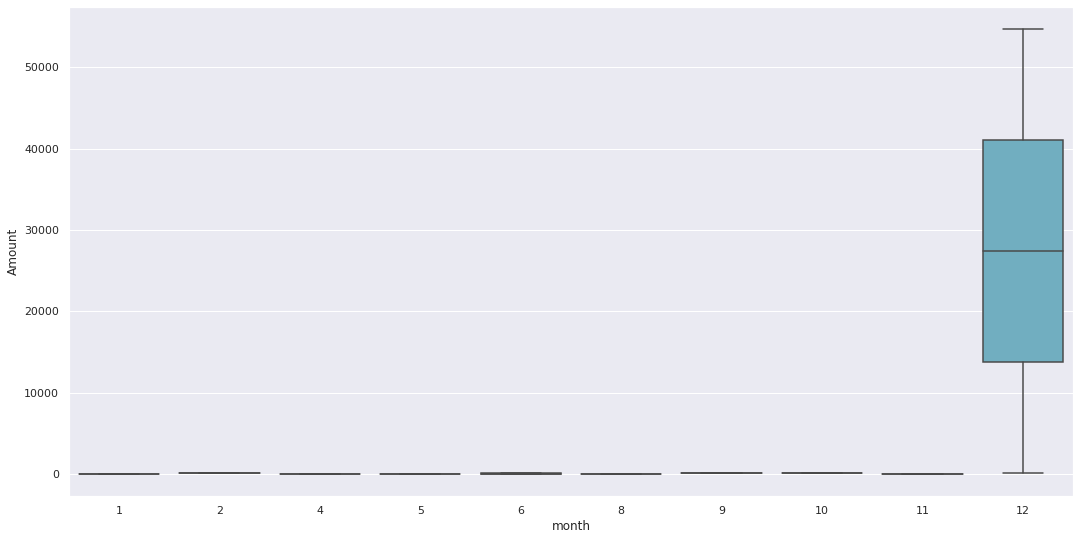

Supplier Expense


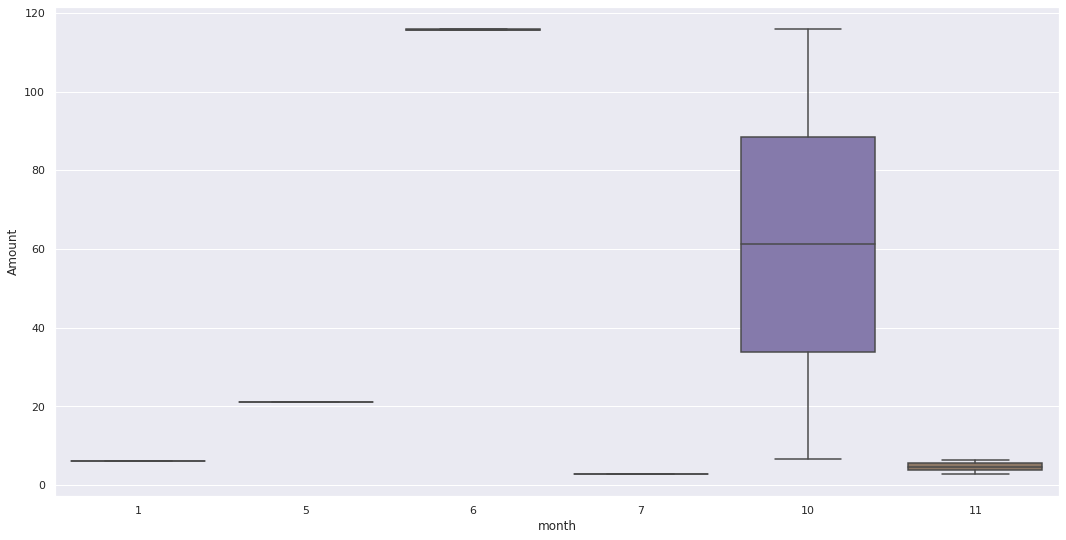

Banking Expense


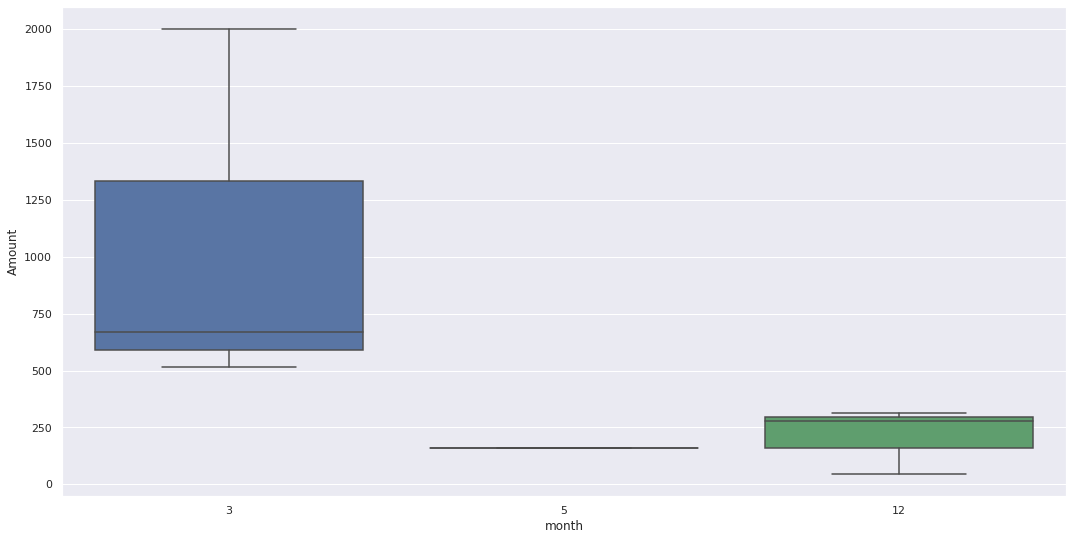

Offices Expenses


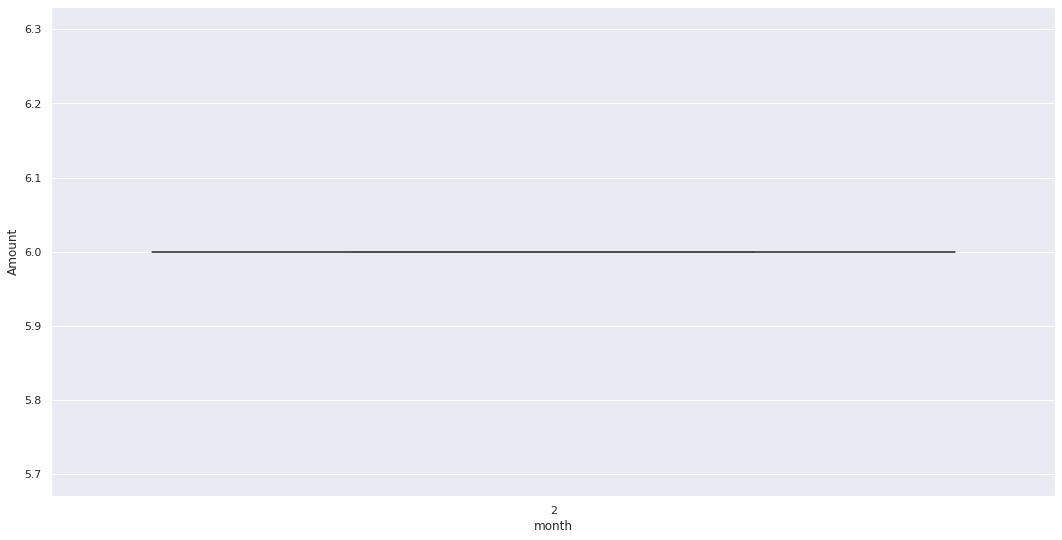

In [21]:
for category in my_transactions_df['Master_Category'].unique():
    print(category)
    test=my_transactions_df[my_transactions_df['Master_Category']==category]
    sns.set(rc={'figure.figsize':(18, 9)})
    sns.boxplot(data=test, x='month', y='Amount')
    plt.show()

##### Distribution in days of a month

Income


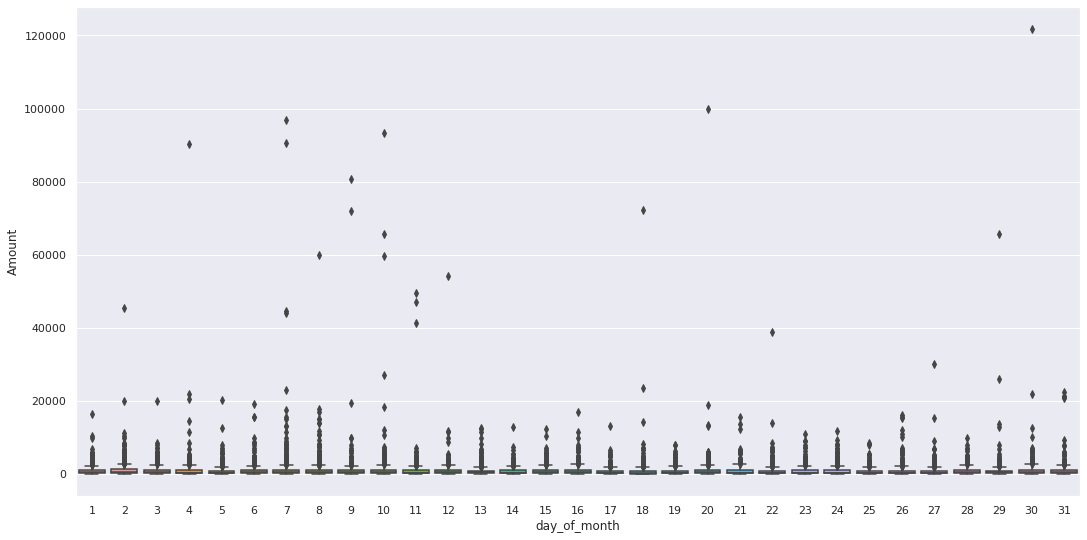

Transfer


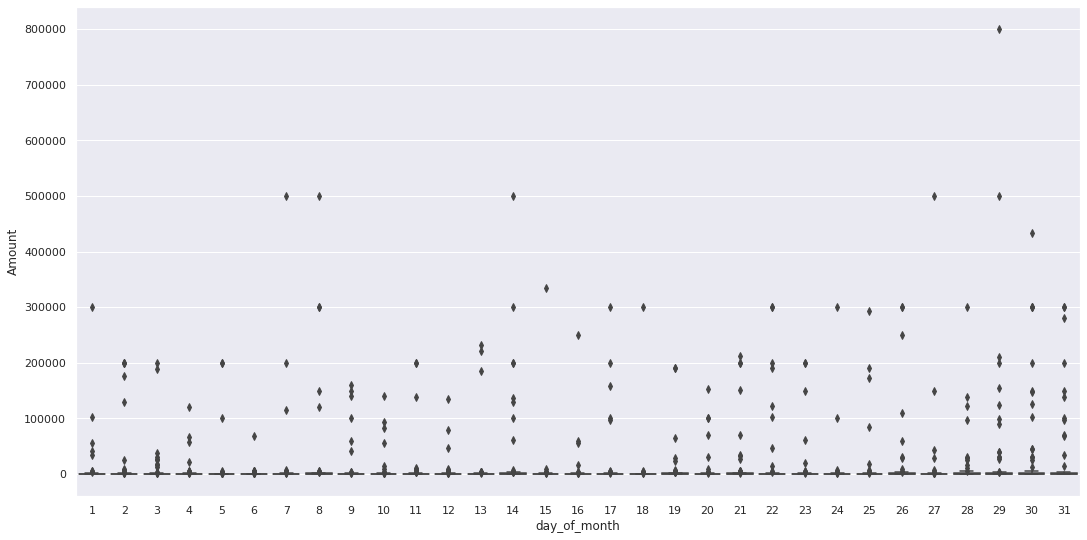

Uncategorised Expense


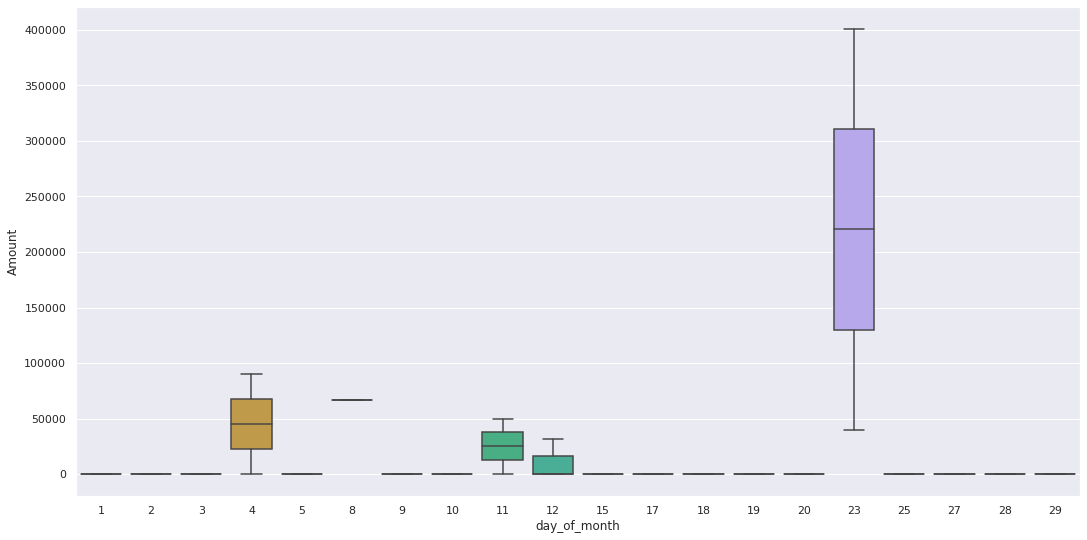

Assets


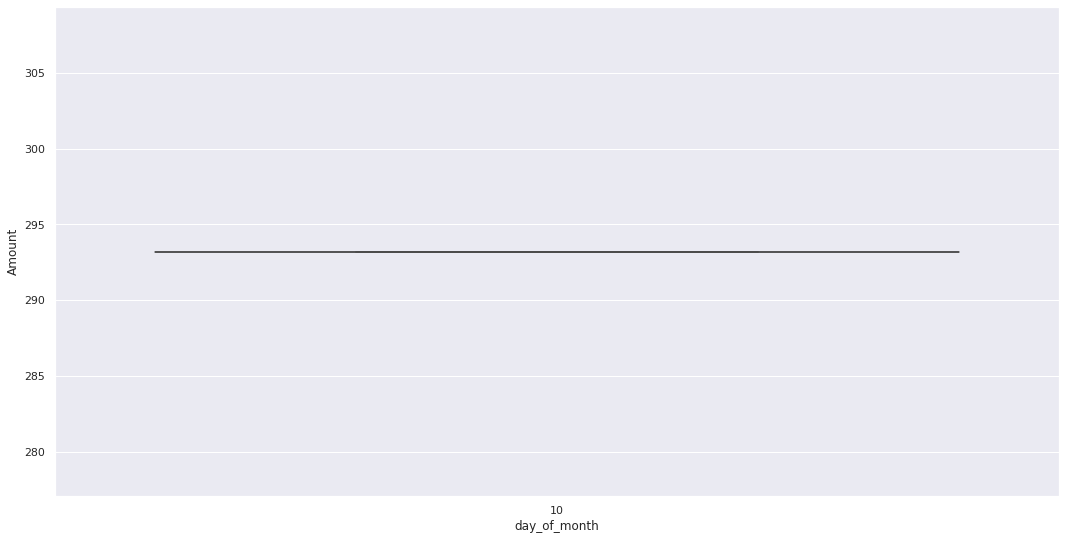

Payroll & Benefits in Kind


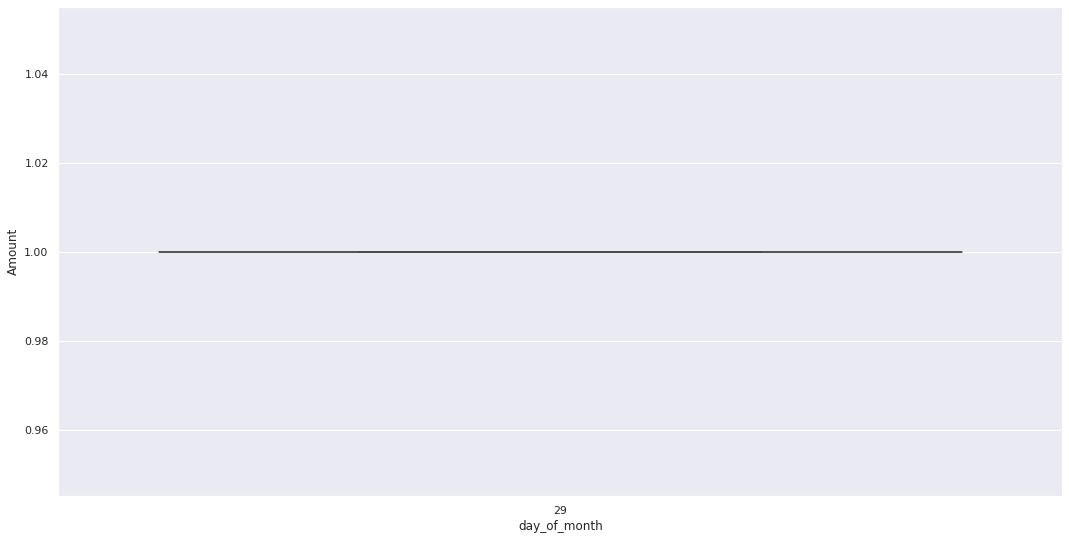

Professional Fees


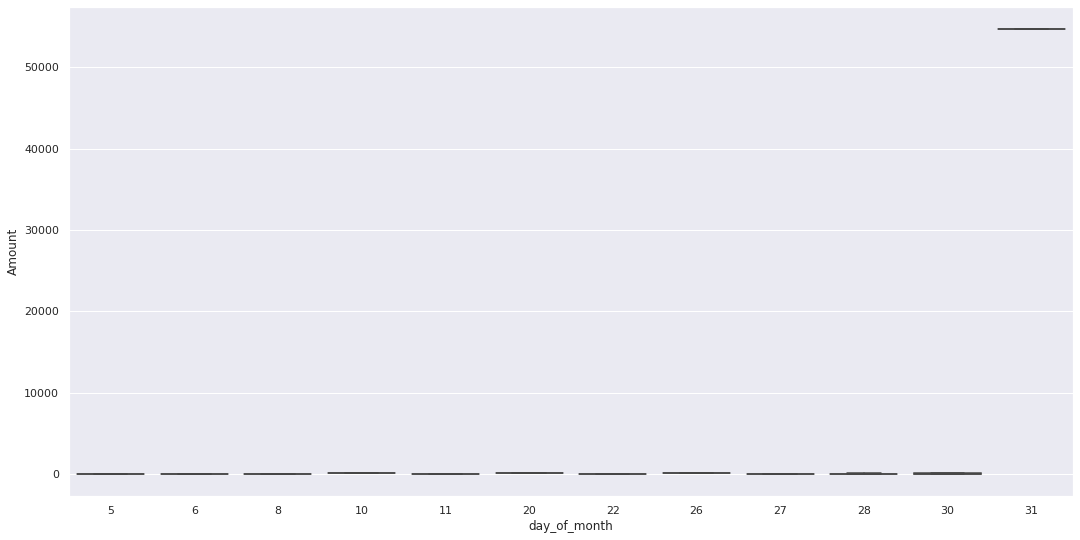

Supplier Expense


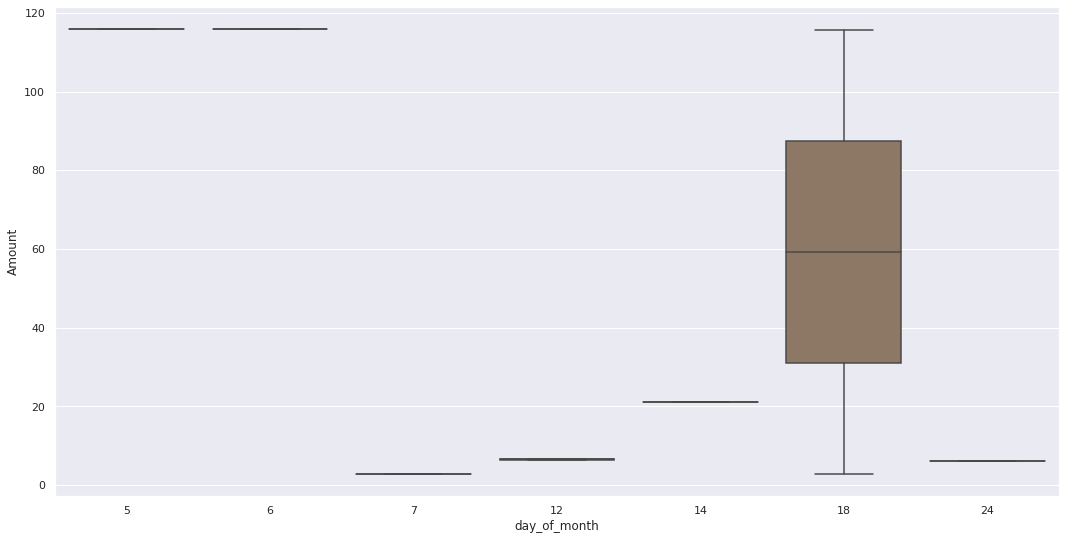

Banking Expense


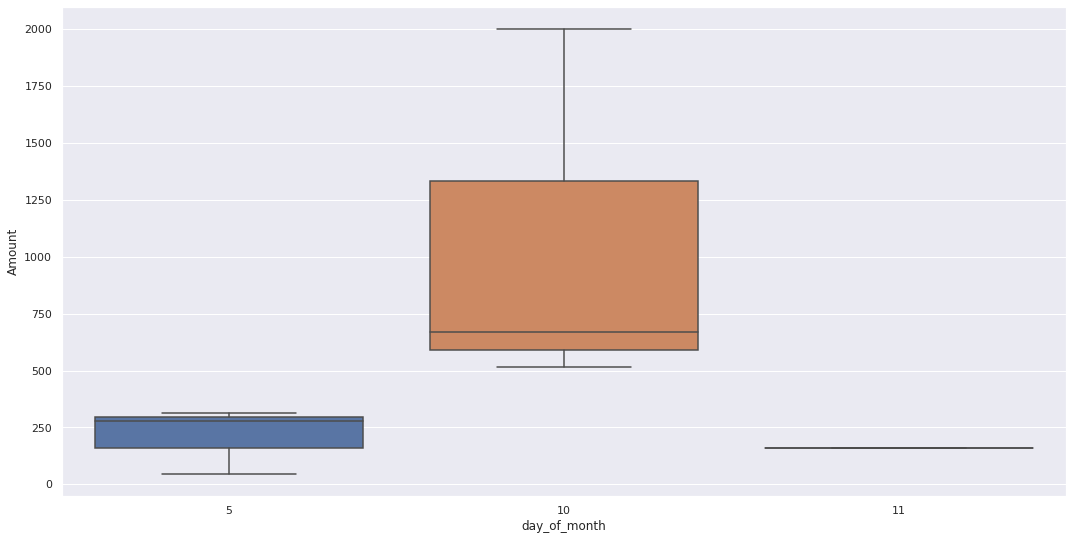

Offices Expenses


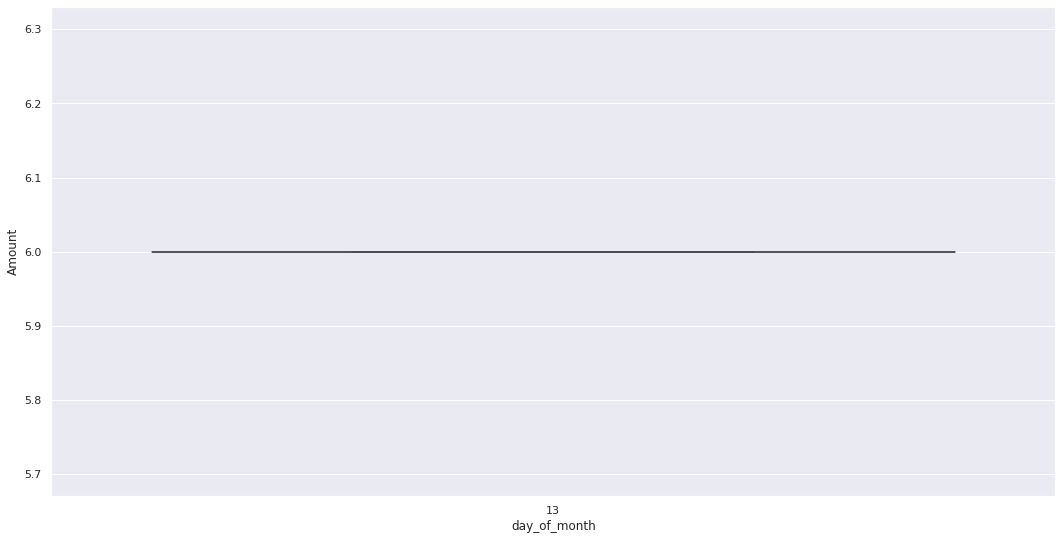

In [22]:
for category in my_transactions_df['Master_Category'].unique():
    print(category)
    test=my_transactions_df[my_transactions_df['Master_Category']==category]
    sns.set(rc={'figure.figsize':(18, 9)})
    sns.boxplot(data=test, x='day_of_month', y='Amount')
    plt.show()

##### Distribution in days of a week per category

Transfer


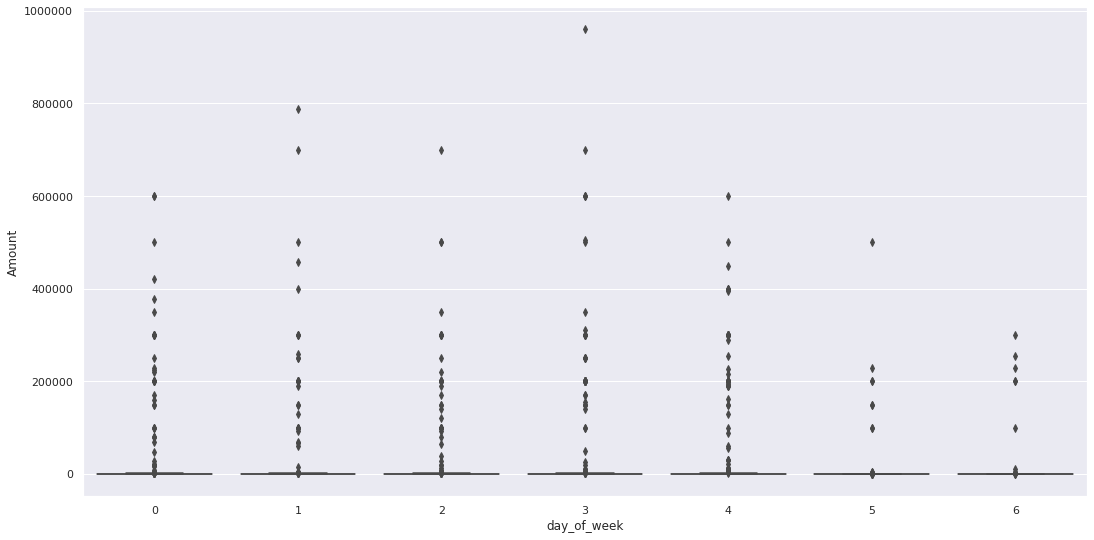

Income


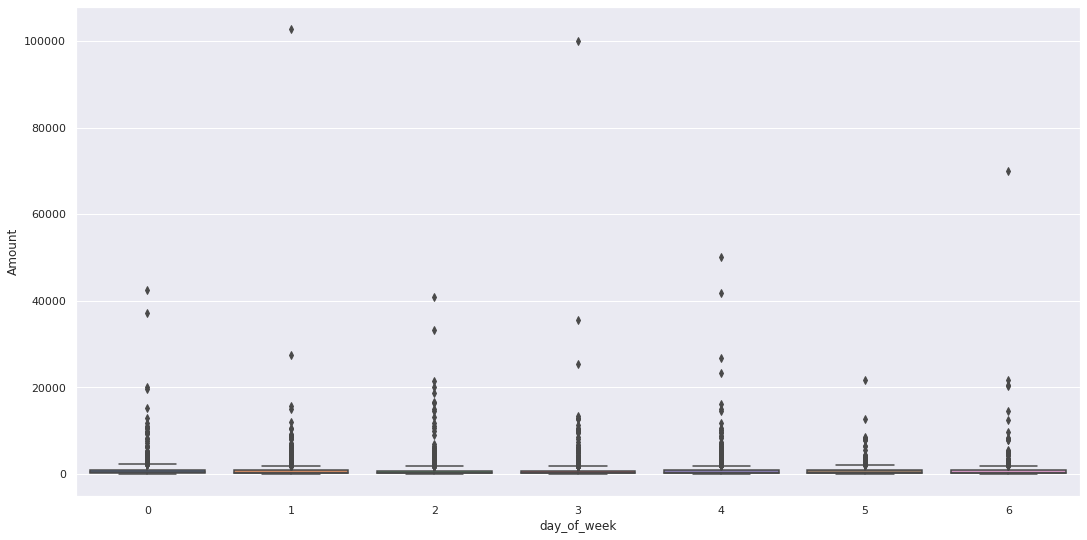

Uncategorised Expense


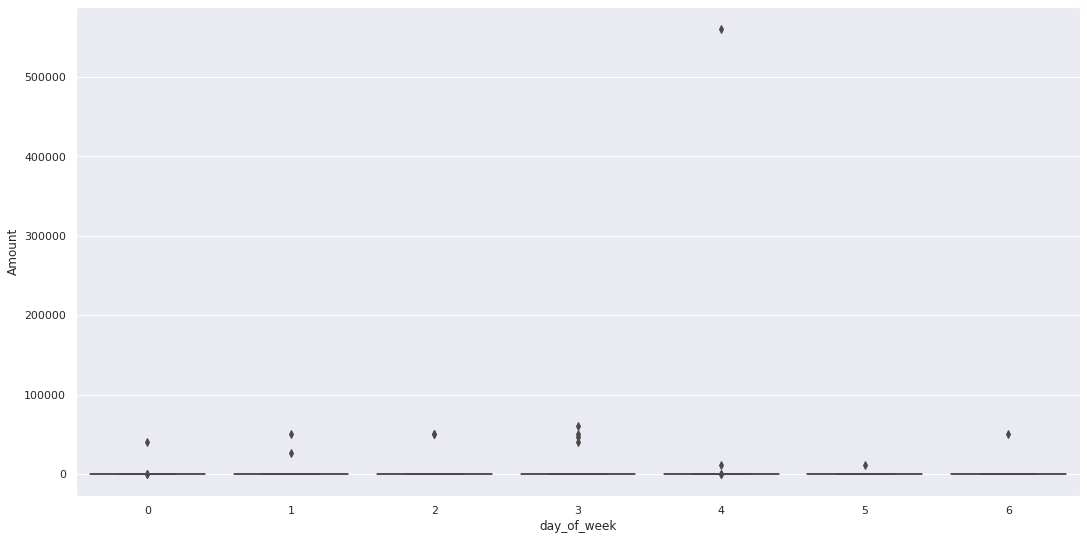

Selling and distribution expenses


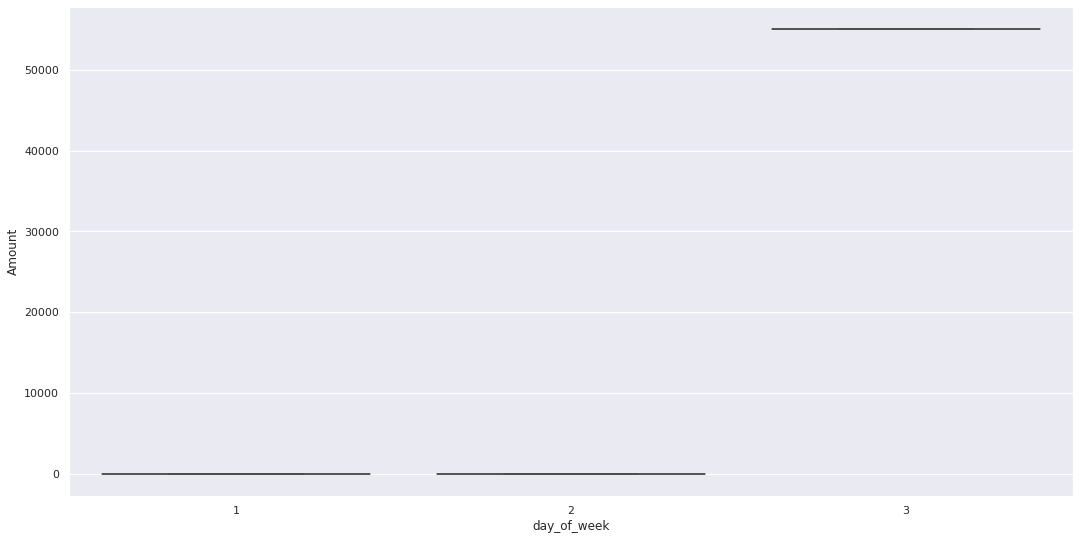

Supplier Expense


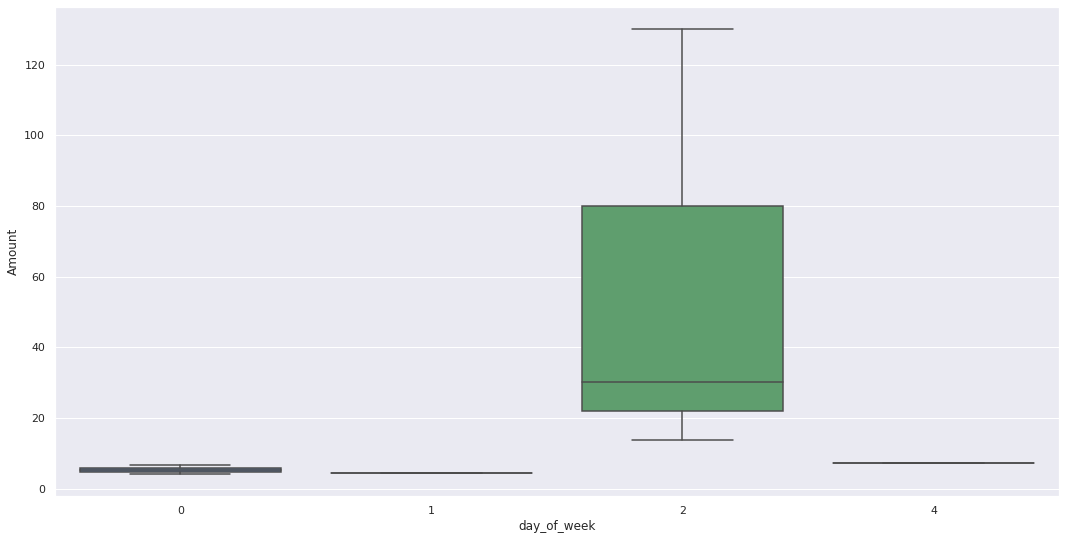

Offices Expenses


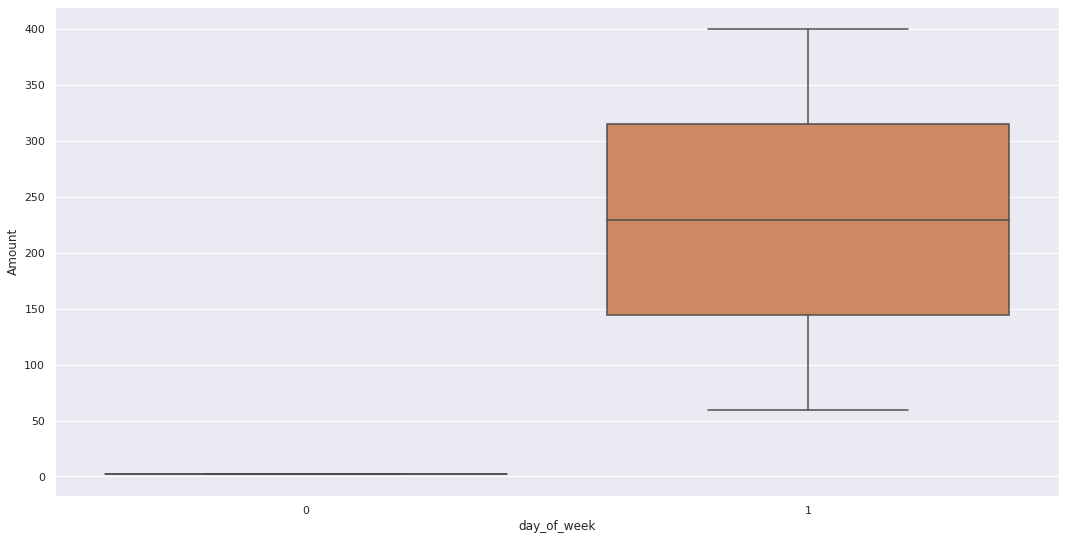

Banking Expense


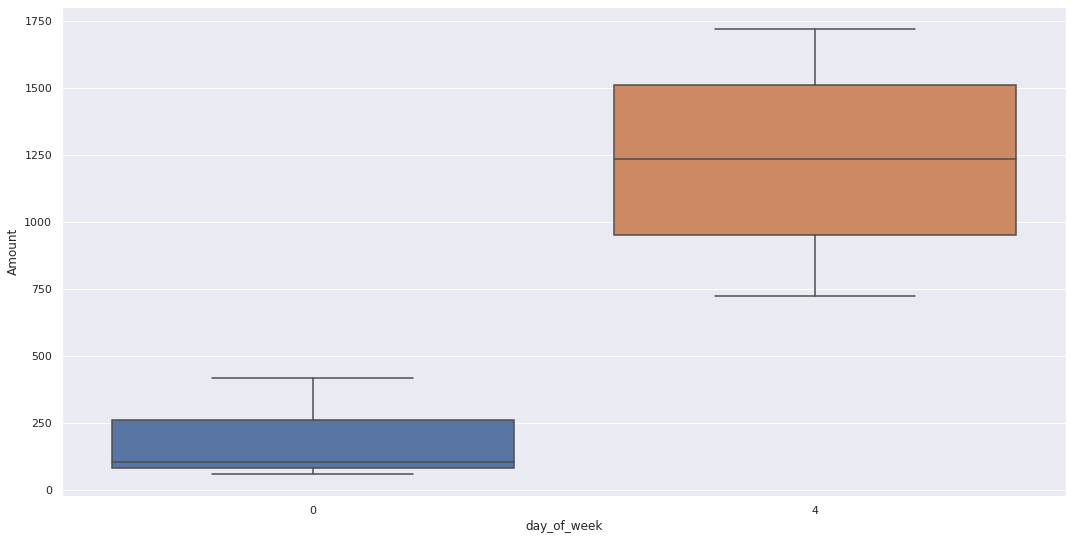

Insurance


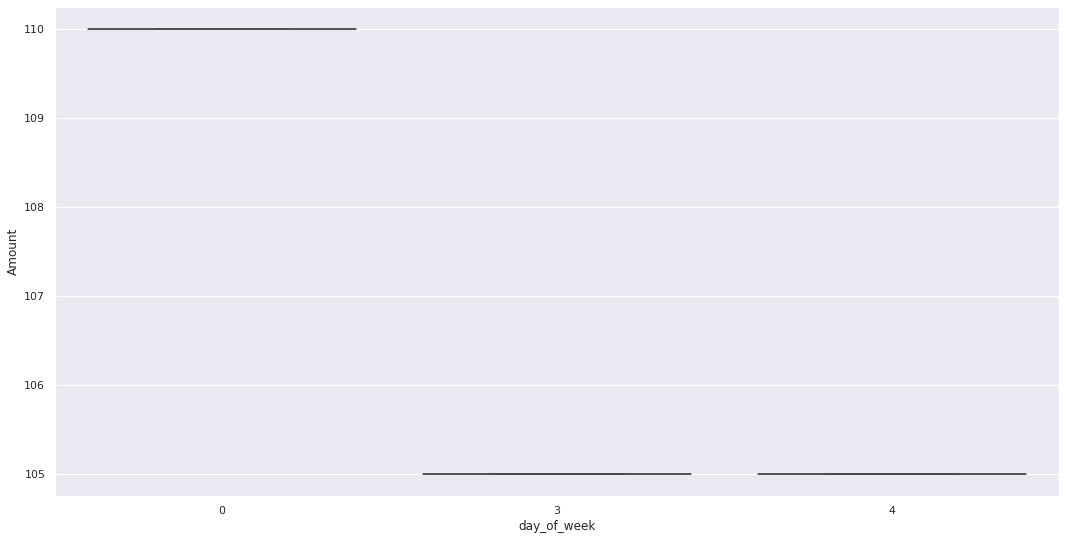

Professional Fees


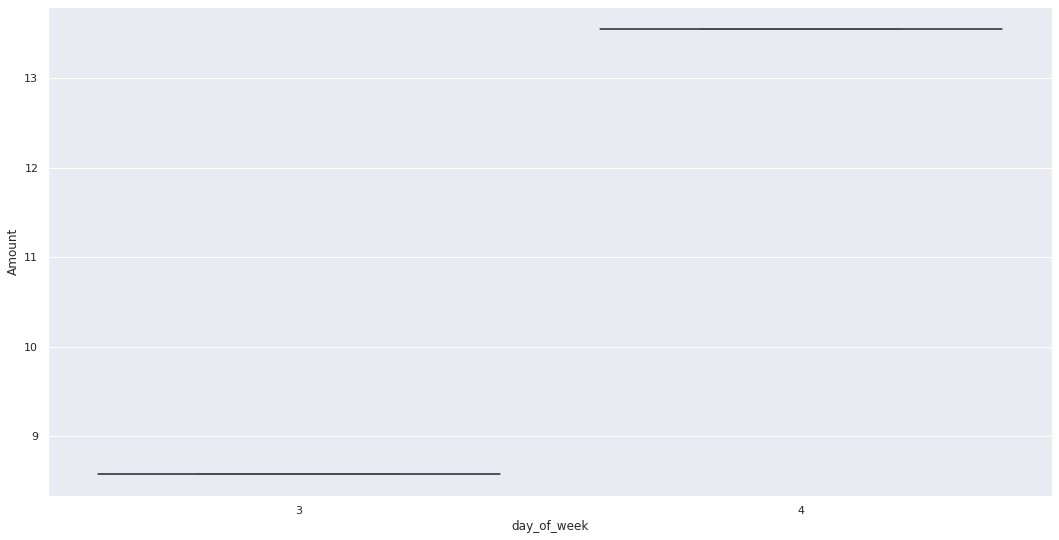

Assets


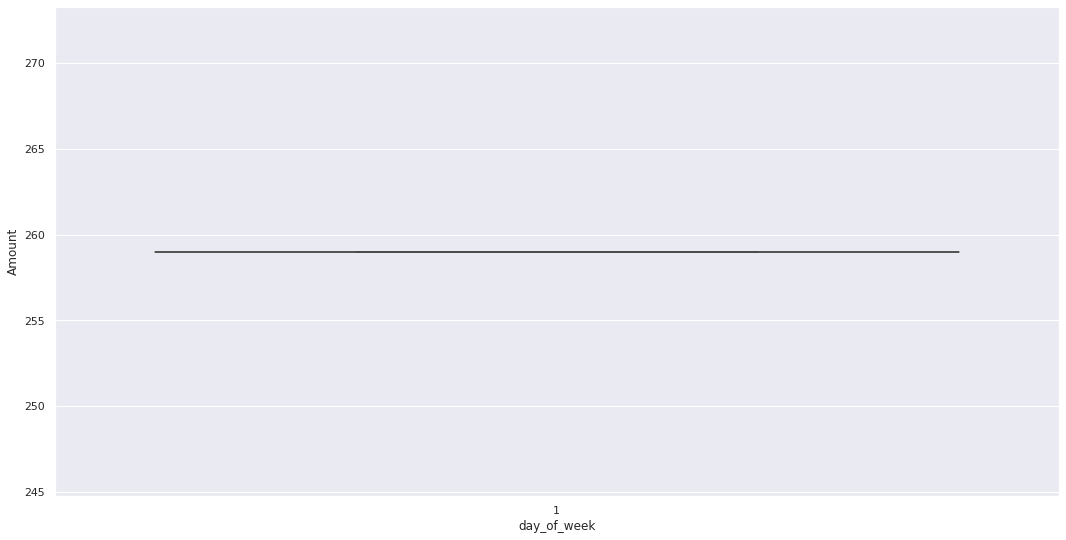

In [218]:
for category in my_transactions_df['Master_Category'].unique():
    print(category)
    test=my_transactions_df[my_transactions_df['Master_Category']==category]
    sns.set(rc={'figure.figsize':(18, 9)})
    sns.boxplot(data=test, x='day_of_week', y='Amount')
    plt.show()

146008     19831
165274     14434
7006987    13824
434950     13276
9575903    12933
435165     12719
4576605    12646
422934     12336
145992     12288
9542025    12094
Name: skAcctKey, dtype: int64


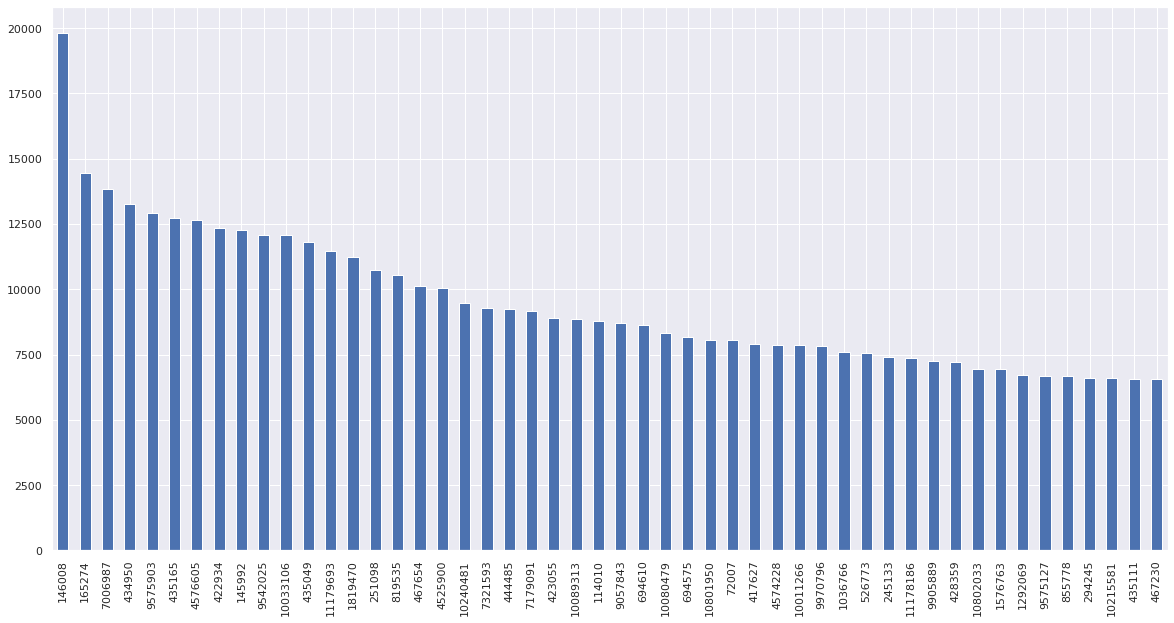

In [23]:
plt.figure(figsize=(20,10))
print(transactions_df['skAcctKey'].value_counts()[:10])
transactions_df['skAcctKey'].value_counts()[:50].plot(kind='bar')

## Proposed Approach - Based on the DeepAR model

DeepAR, a DL approach implementing an RNN-based model, close to the one described in 
> Salinas, D., Flunkert, V., Gasthaus, J., Januschowski, T.: Deepar: Prob-abilistic forecasting with autoregressive recurrent networks. InternationalJournal of Forecasting (2019

, was chosen as the most suitable one, originating from the open-source GluonTS toolkit https://ts.gluon.ai/ .


In more detail, the chosen model applies a methodology for producing accurate probabilistic forecasts, based on training an autoregressive Recurrent Neural Network model on many related time series. 

RNNs have the concept of "memory" that helps them store the states or information of previous inputs to generate the next output of the sequence. The RNN that predicts the mean and the variance of the underlying time-series, is coupled with a Monte Carlo simulationyielding results represented as a distribution. The main architecture of the DeepAr is depicted in the image belowe where the main steps for predicting z(t+1)can be summarized in 
* first a gaussian distribution in created using the μ(t) and σ(t) , 
* from this distribution n samples are drawn, median of these n samples is set to z`(t) . 
* z'(t) along with current know covariates x(t+1) and previous hidden state h(t) are fed into the trained LSTM model which outputs h(t+1).
* μ(t+1) and σ(t+1) are obtained using h(t+1), using the new μ(t+1) and σ(t+1) a gaussian distribution is created from which n samples are selected


![image](./input/deepAR_training.png)


Moreover, the chosen model learns seasonal behavior patterns from the given covariates that strengthens its forecasting capabilities. As expected, while configuring the model to our forecasting needs, various long-established challenges regarding time-series forecasting arose.  


![title](./input/DeerAR_ts.png)


A very good description of DeepAr can be found in https://kshavg.medium.com/deepar-probabilistic-forecasting-with-autoregressive-recurrent-networks-fa65dddae1f5


## All Accounts - Per Category

* In order to avoid the "cold start" challenge we set a threshold to include only timeseries that have more transactions than the threshold. 

* Furthermore, we have to create equal-sized timeseries to be fed into the DeepAR model leveraging a custom way of padding by creating empty equal sized indexes that will be merged with the sparse timeseries of the transactions for each accound. 

In [25]:
THRESHOLD_NUMBER_OF_TRANSACTIONS = 10

In [26]:
df = transactions_df[transactions_df['TransactionDate'] < '2020-12-06 00:00:00']

In [27]:
df = df[df['Debit_CreditIndicator']=='D']

The stationarity of the data was checked by using augmented Dickey-Fuller test, which is out of the scope of this notebook. This process is of major importance for any predictive method that exploits historical data, since these methods are usually based on the assumption that the data generation mechanism does not change over time. Furthermore, it should be noted that in terms of predictions, the prediction time-frames may be over 1/4 of a year (i.e. 3 months). These predictions aim at improving the internal financial monitoring of an enterprise and its various inflows and outflows, while also enabling professionals to ensure the business continuity of their clients (i.e. SMEs), minimize future risks and financial losses. Based on the latter, three options stand out: 

 * item Use the dataset as is, with its daily frequency resulting in a 90-time-step window of prediction. This is not recommended as most of the time-series produced are sparse leaving no obvious pattern to be learnt from.
 
 * item Resample the data in weeks, resulting in a 12-timestep window of prediction. While some patterns begin to emerge, the data in some cases are still very sparse and the cumulative error from the 12-step prediction is theoretically relatively big. 
 
* item Resample the data in months periods, providing stationary time-series with visible patterns and a lower theoretical accumulated error of prediction, since the window has been reduced to 3-timesteps. 
 
The data were re-sampled in weekly time frame by calculating the aggregate amount of inflows and outflows respectively per account. The time frame of "weeks" was selected as it corresponds to the data velocity for the given case - i.e. the strategy of the SMEs can be projected in a 4-month horizon. 

In [28]:
df.set_index(['TransactionDate'], inplace=True)

In [29]:
df = df.sort_index()

In [30]:
FREQ="1W"

start_date = df.index[0]
end_date = df.index[-1]

print(start_date)
print(end_date)
index = pd.date_range(start=start_date, end=end_date, freq=FREQ)

2017-01-07 00:00:00
2020-12-05 00:00:00


For this approach we have to group the data based on the Accounts and The Categories in order to create timeseries per account per category. 

In [31]:
df_grouped = df.groupby(['skAcctKey', 'Master_Category'])

In [32]:
dataframes = []
filenames = []

for group in df_grouped.groups:
    if len(df_grouped.get_group(group))>THRESHOLD_NUMBER_OF_TRANSACTIONS:
        df = df_grouped.get_group(group)
        df = df[['Amount','Master_Category','month','day_of_month','day_of_week']]
        df.fillna(0, inplace=True)
        df = df.sort_index()
        
        mockup_dataframe = pd.DataFrame(index=index)
    
        df_category = df.resample(FREQ).sum()
        mockup_dataframe = pd.merge(mockup_dataframe, df_category,  how='left', left_index=True, right_index=True)    
    
        mockup_dataframe = mockup_dataframe.resample(FREQ).sum()
    
        filenames.append(group)
        dataframes.append(mockup_dataframe)
    

In [228]:
for i in range(10):
    print(filenames[i])

(128, 'Cash')
(128, 'Uncategorised Expense')
(16932, 'Banking Expense')
(16932, 'Motor Vehicles Running Cost')
(16932, 'Offices Expenses')
(16932, 'Payroll & Benefits in Kind')
(16932, 'Professional Fees')
(16932, 'Selling and distribution expenses')
(16932, 'Supplier Expense')
(16932, 'Utilities')


In [33]:
N=len(dataframes)
T = len(dataframes[0])
starts = []
print('Number of Timeseries :' + str(N))
print('Number of Samples in each ts :' +str(T))
print('Freq : ' + FREQ)

Number of Timeseries :9494
Number of Samples in each ts :204
Freq : 1W


In [34]:
custom_dataset = dataframes

In [35]:
PREDICTION_LENGTH = 12
CONTEXT_LENGTH = 24

custom_ds_metadata = {'num_series': N,
                      'prediction_length': PREDICTION_LENGTH,
                      'context_length': CONTEXT_LENGTH,
                      'freq': FREQ
                     }

In [37]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation.backtest import make_evaluation_predictions

#TODO add all the dynamic features + is holiday etc + number of employees
train_ds = common.ListDataset([{'target': custom_dataset[i].Amount[:-custom_ds_metadata['prediction_length']], 'start': custom_dataset[i].index[0], 'feat_dynamic_real': [custom_dataset[i].month[:-custom_ds_metadata['prediction_length']],
                                                                                      custom_dataset[i].day_of_month[:-custom_ds_metadata['prediction_length']],
                                                                                      custom_dataset[i].day_of_week[ :-custom_ds_metadata['prediction_length']]]}
                        for i in range(N)],
                       freq=custom_ds_metadata['freq'])


# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = common.ListDataset([{'target': custom_dataset[i].Amount[:], 'start': custom_dataset[i].index[0], 'feat_dynamic_real': [custom_dataset[i].month[:],
                                                                                      custom_dataset[i].day_of_month[:],
                                                                                      custom_dataset[i].day_of_week[:]]}
                       for i in range(N)],
                      freq=custom_ds_metadata['freq'])

INFO:root:Using CPU


In [38]:
estimator_dare = deepar.DeepAREstimator(
        prediction_length=custom_ds_metadata['prediction_length'],
        context_length=custom_ds_metadata['context_length'],
        freq=custom_ds_metadata['freq'],
           trainer=Trainer(epochs=5,
                            ctx="cpu",
                            num_batches_per_epoch=50,
                            ),
        use_feat_dynamic_real=True,
            dropout_rate=0.5
    )

In [39]:
predictor_dare = estimator_dare.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 24284
100%|██████████| 50/50 [00:02<00:00, 20.52it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[0] Elapsed time 2.441 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.794985
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.61it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[1] Elapsed time 2.689 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=5.944542
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.22it/s, avg_epoch_loss=4.95]
INFO:root:Epoch[2] Elapsed time 2.747 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.950521
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 19.55it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[3] Elapsed time 2.559 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=5.061068
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 20.79it/s, avg_epoch_loss=4.59]
INFO

In [40]:
def make_forecasts(predictor, test_data, n_sampl):
    """Takes a list of predictors,gluonTS test data and number of samples
    and returns forecasts for each of them"""
    forecasts = []
    tss = []
    forecast_it, ts_it = make_evaluation_predictions(
                dataset=test_ds,
                predictor=predictor,
                num_samples=n_sampl
           )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss

In [41]:
forecasts, tss = make_forecasts(predictor_dare, test_ds, 100)

In [237]:
def plot_prob_forecasts(ts_entry, forecast_entry, ts_name):
    plot_length = 50
    prediction_intervals = (50.0,95.0)
    pred = np.percentile(forecast_entry.samples, 1)
    legend = ["observations", "prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
#     ts_entry.plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(ts_name)
    plt.show()

* For a 95% confidence interval set p = 2

* Upper Confidence Interval = z'(t+1) + 2 * ci(t+1)

* Lower Confidence Interval = z'(t+1) — 2 * ci(t-1)

![title](./input/preds.png)

50


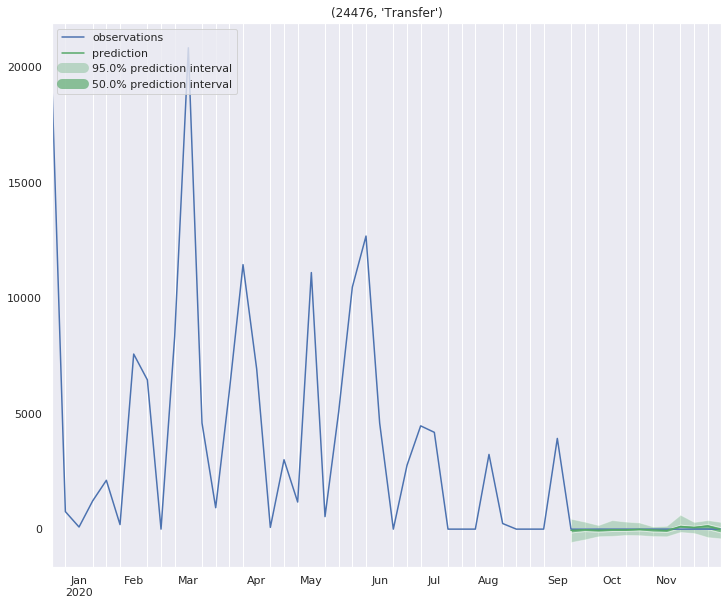

51


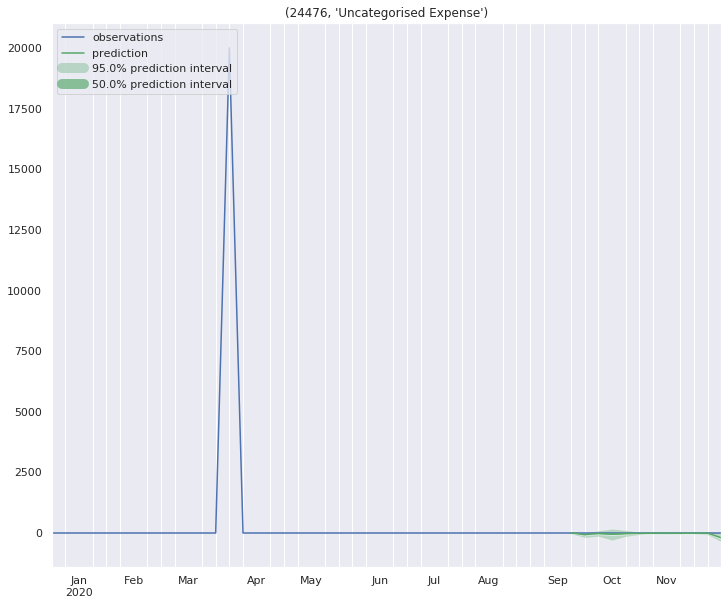

52


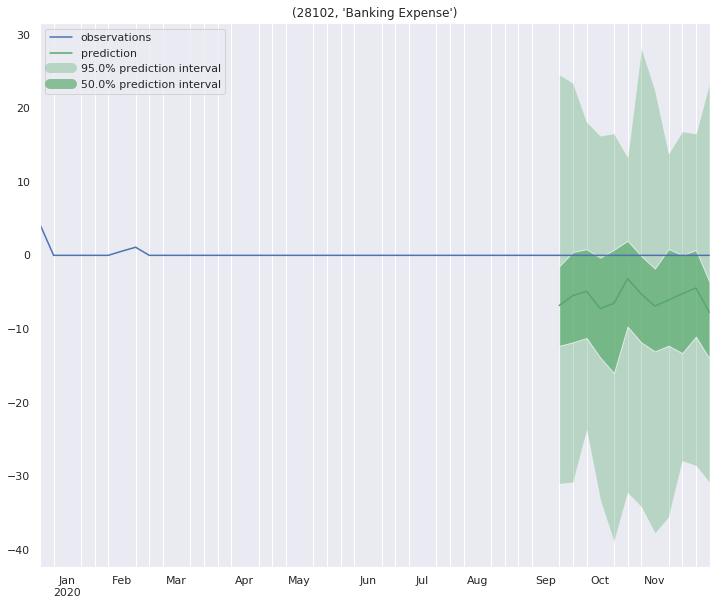

53


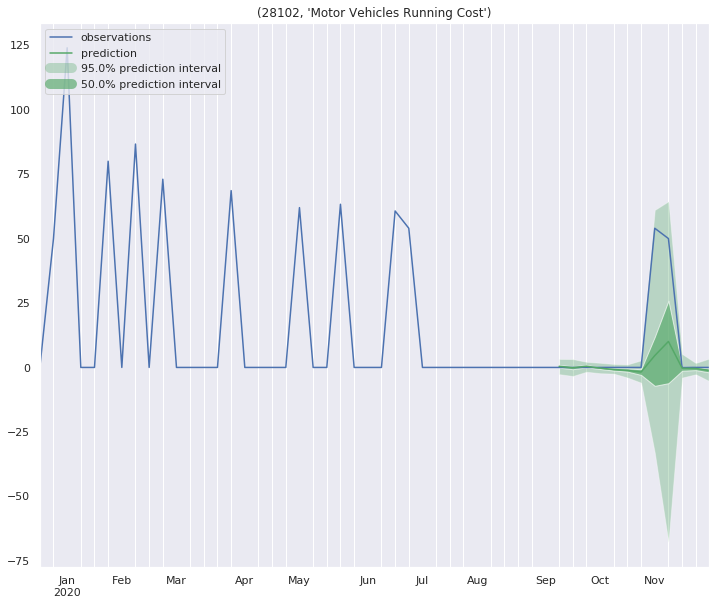

54


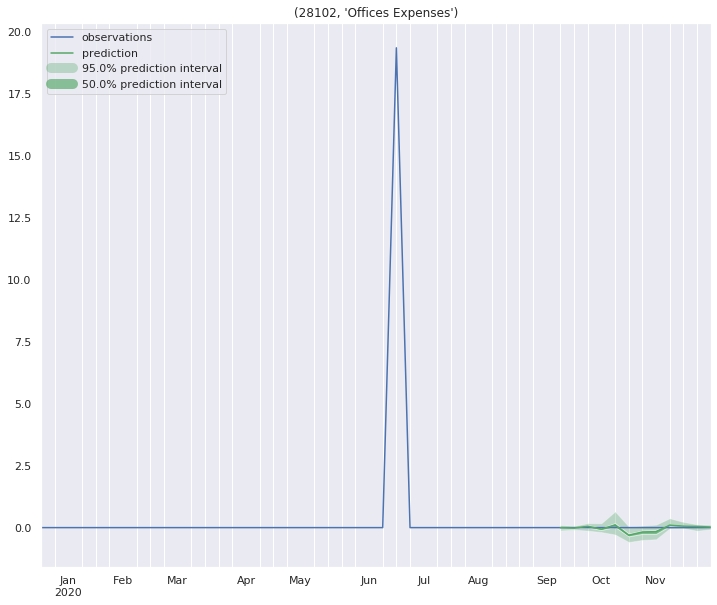

55


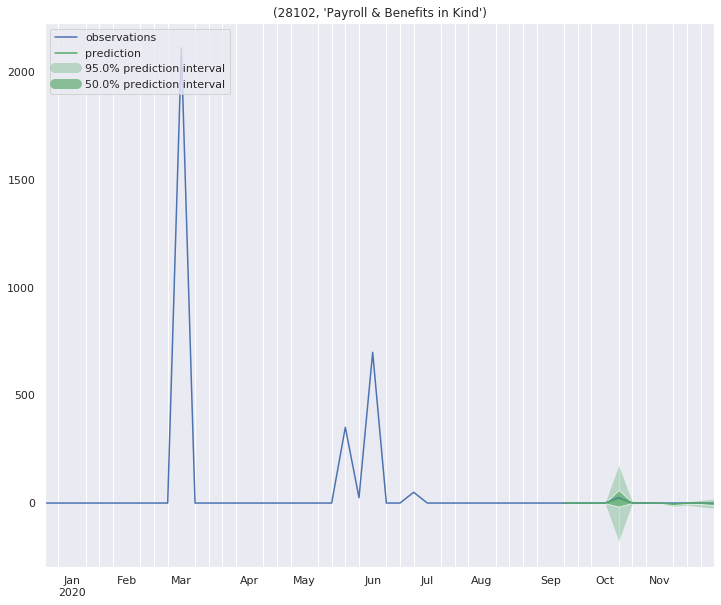

56


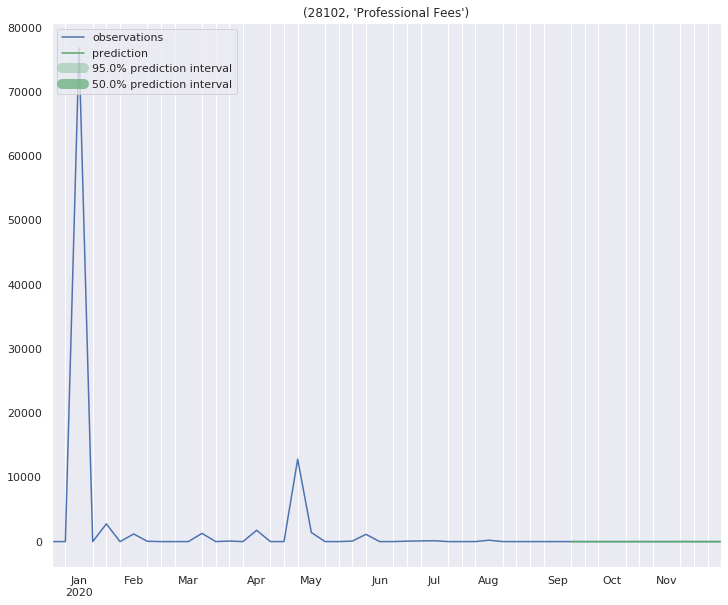

57


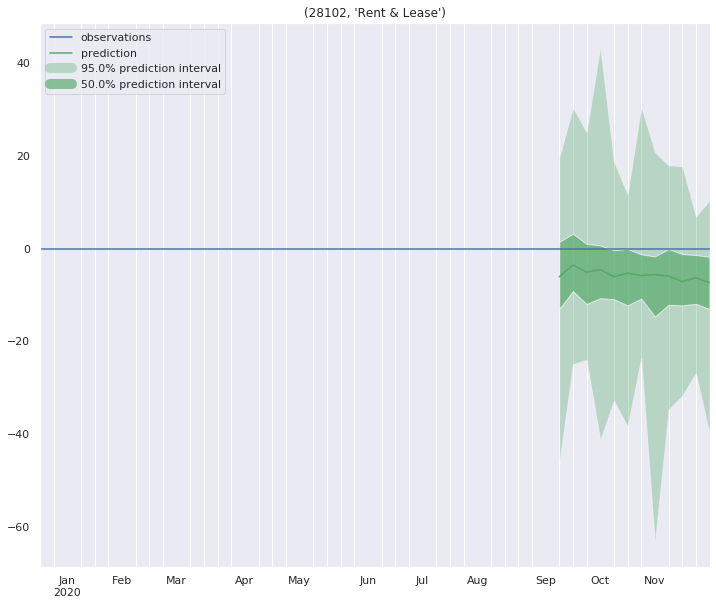

58


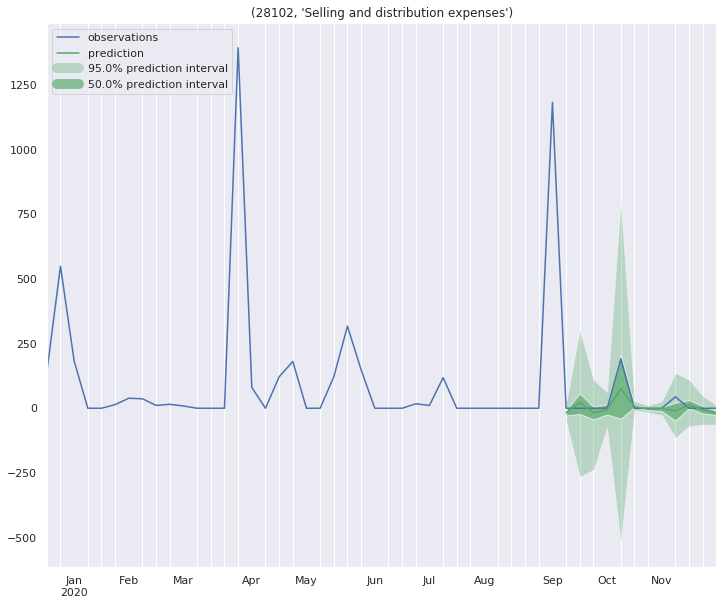

59


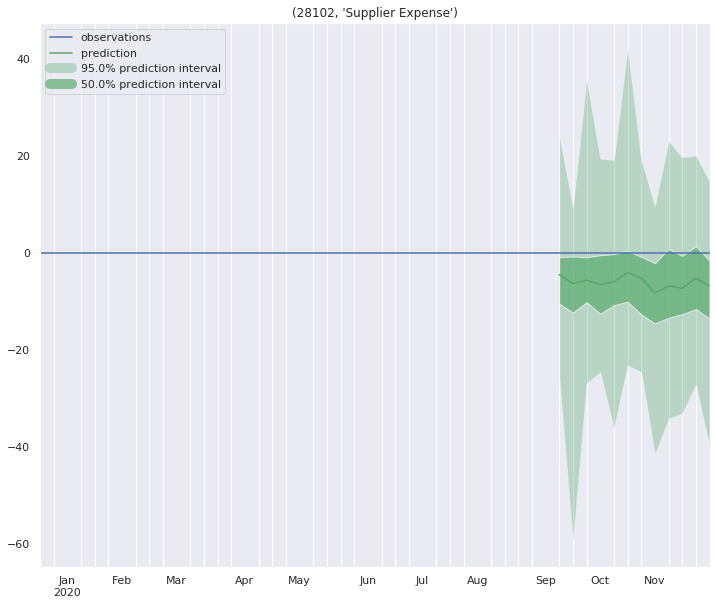

60


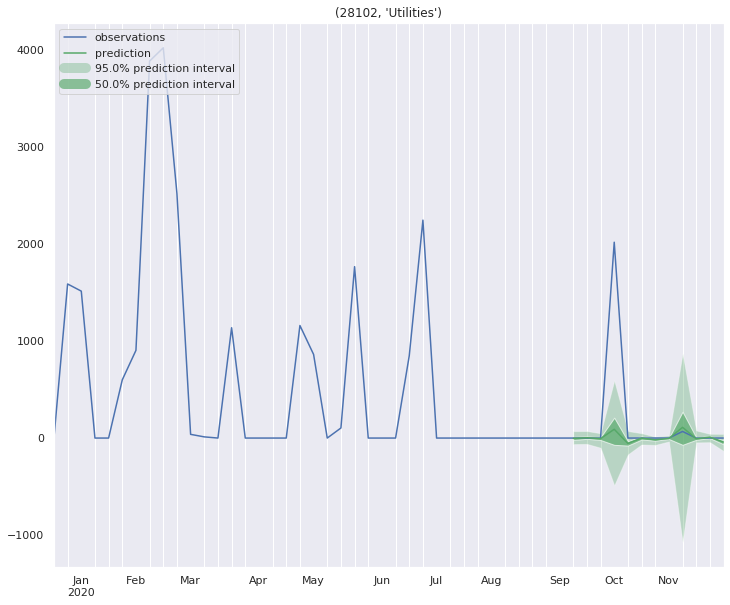

61


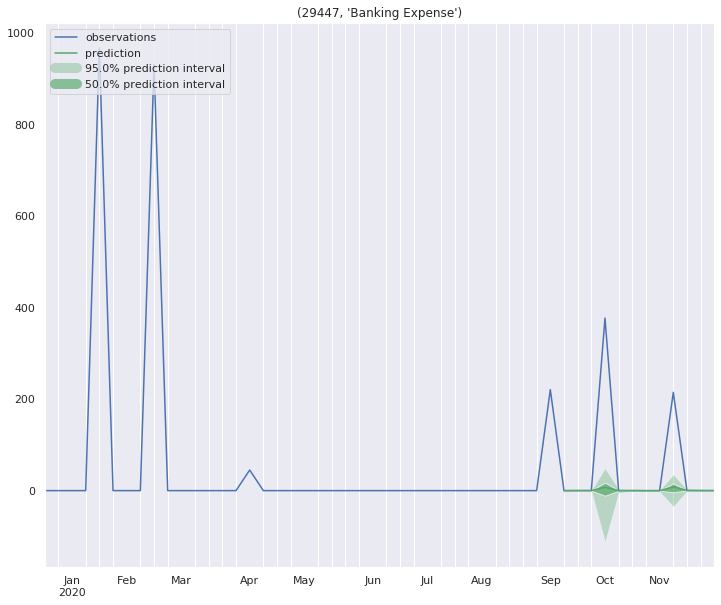

62


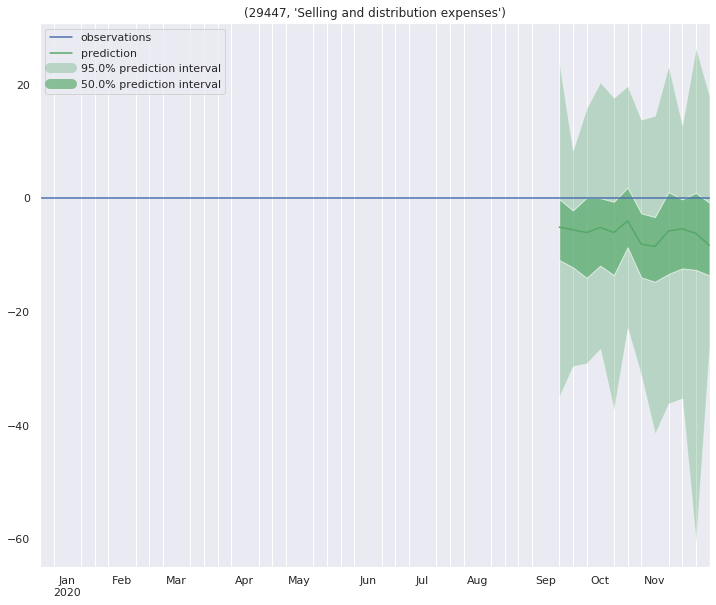

63


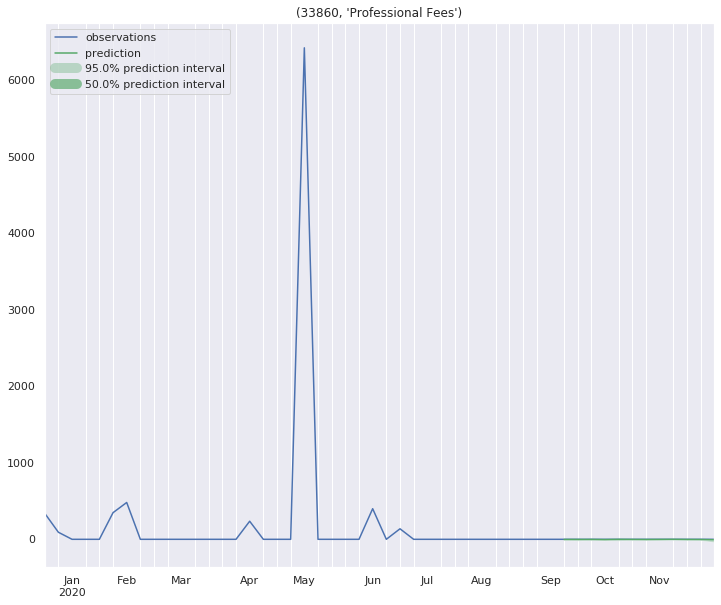

64


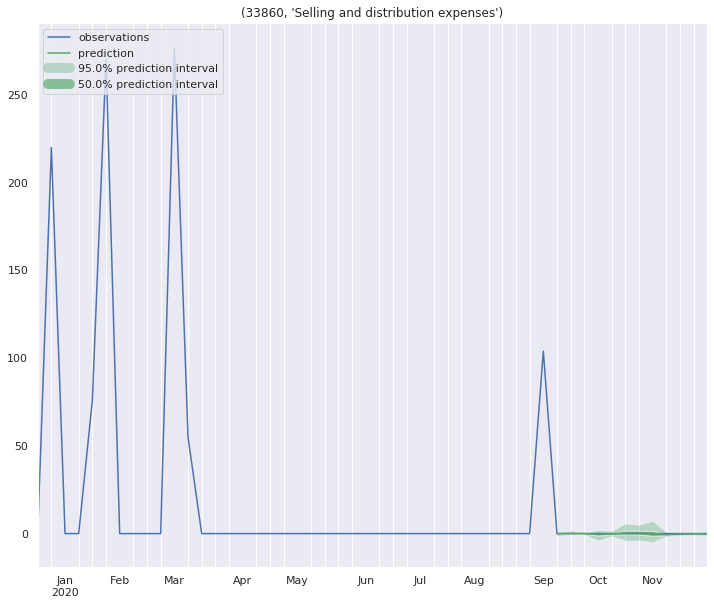

65


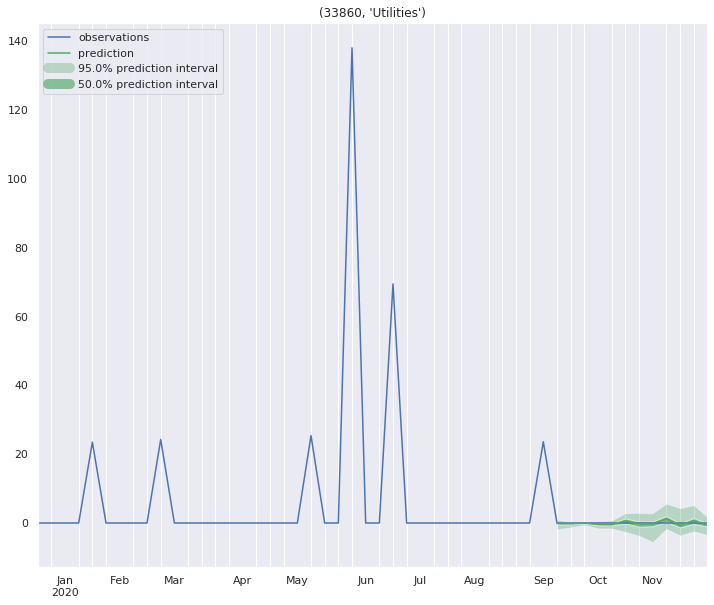

66


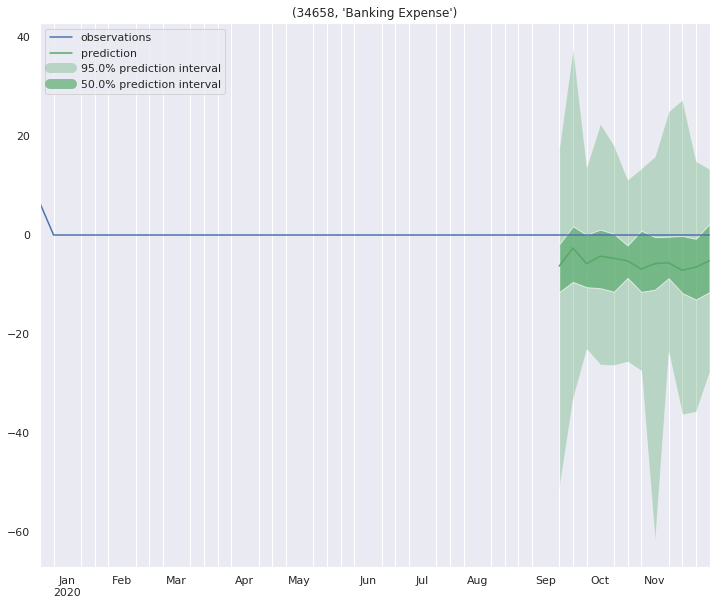

67


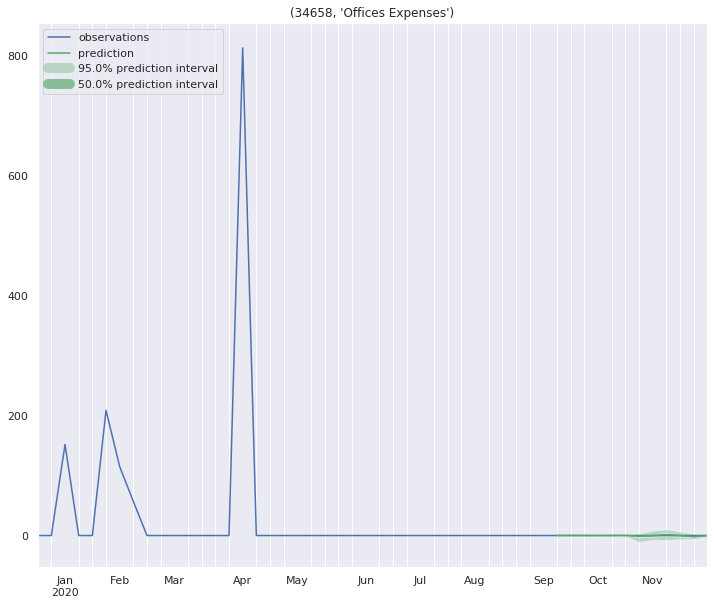

68


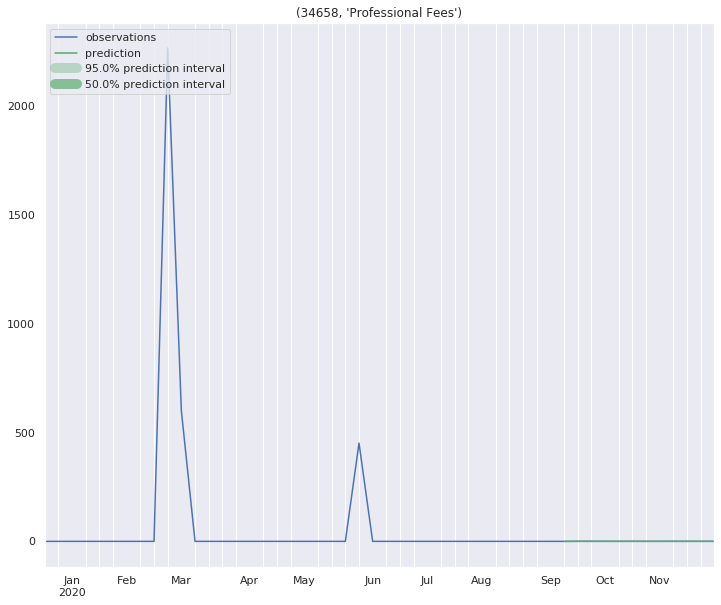

69


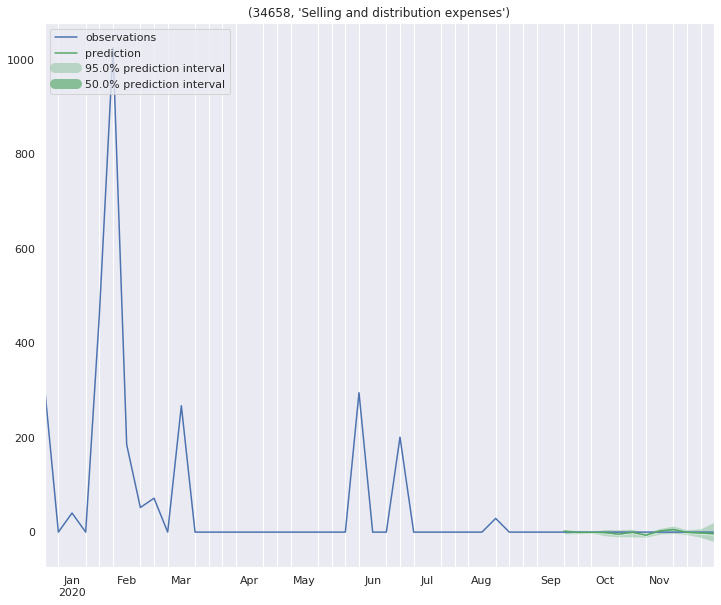

70


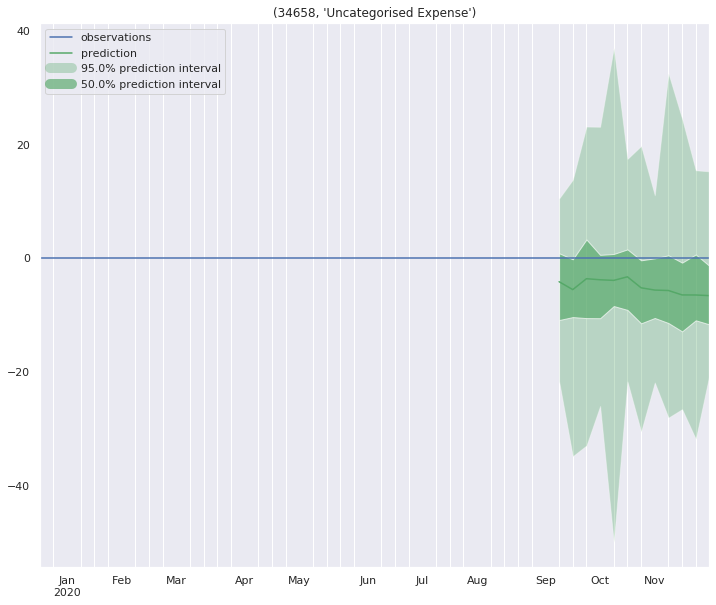

71


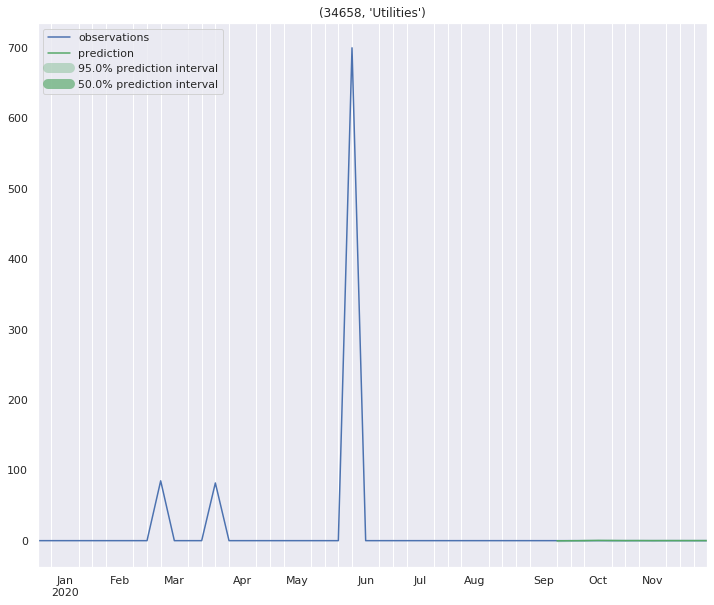

72


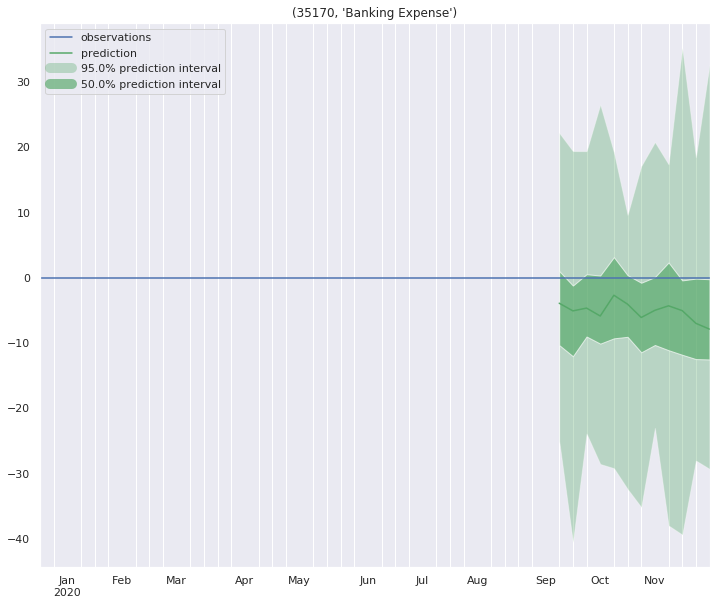

73


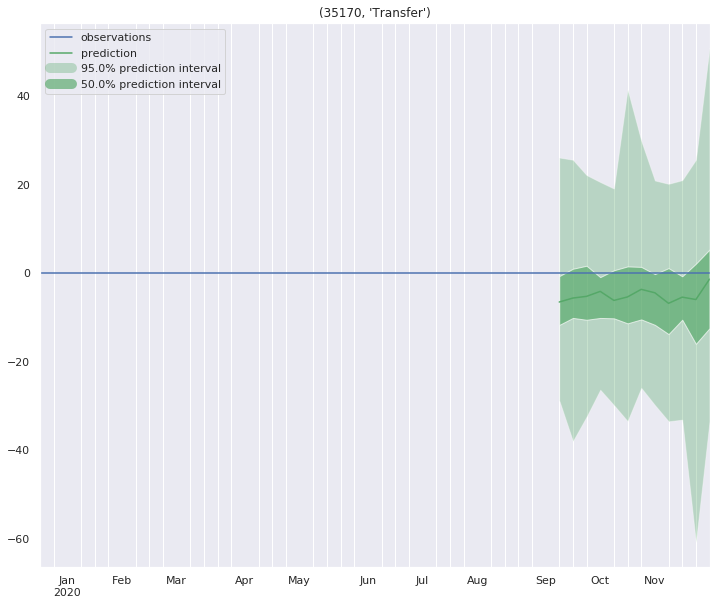

74


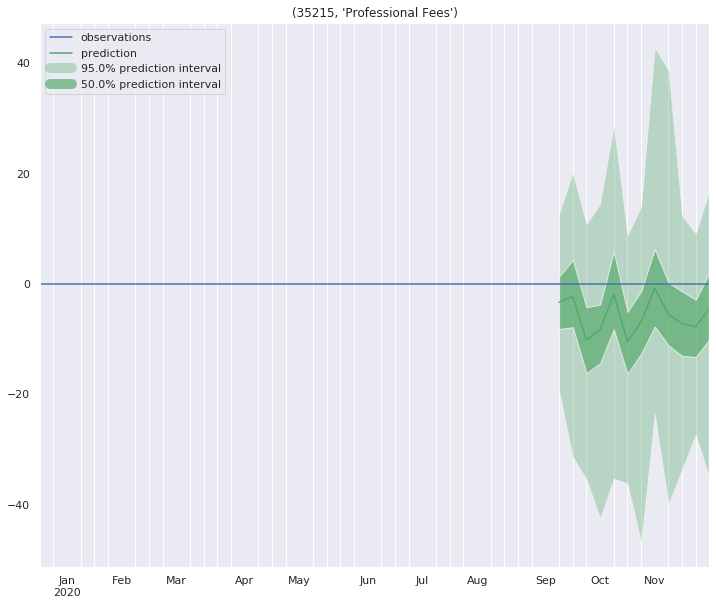

75


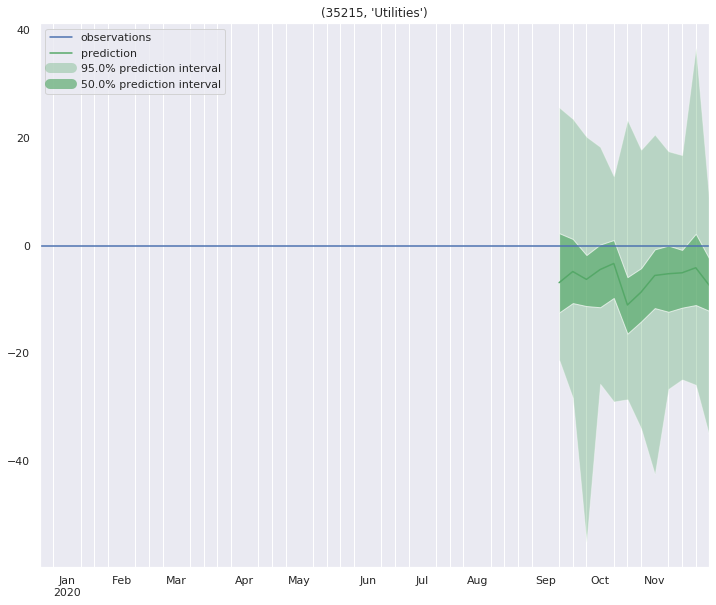

76


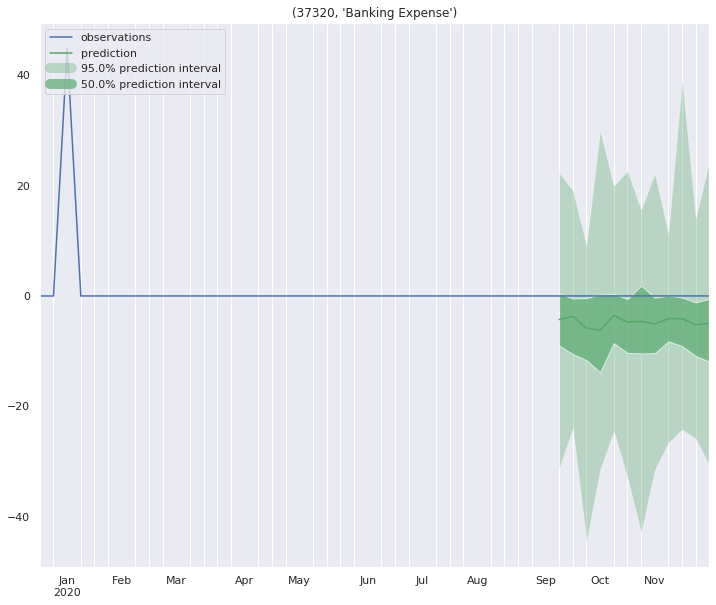

77


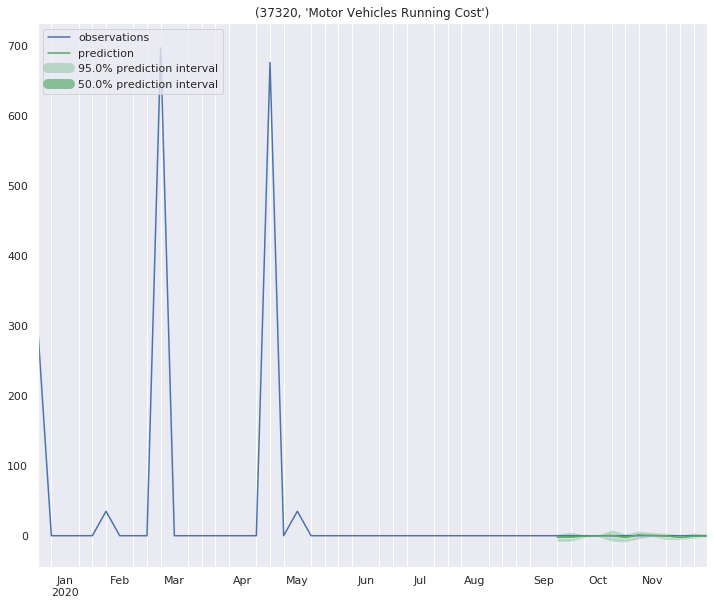

78


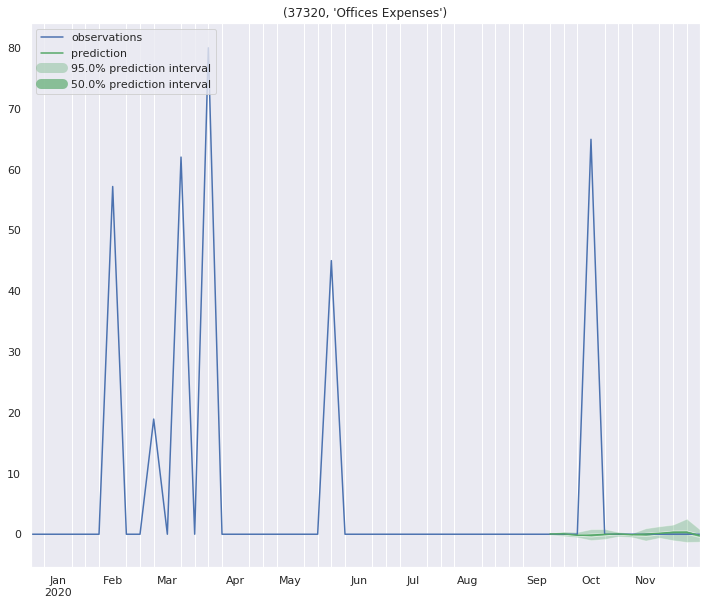

79


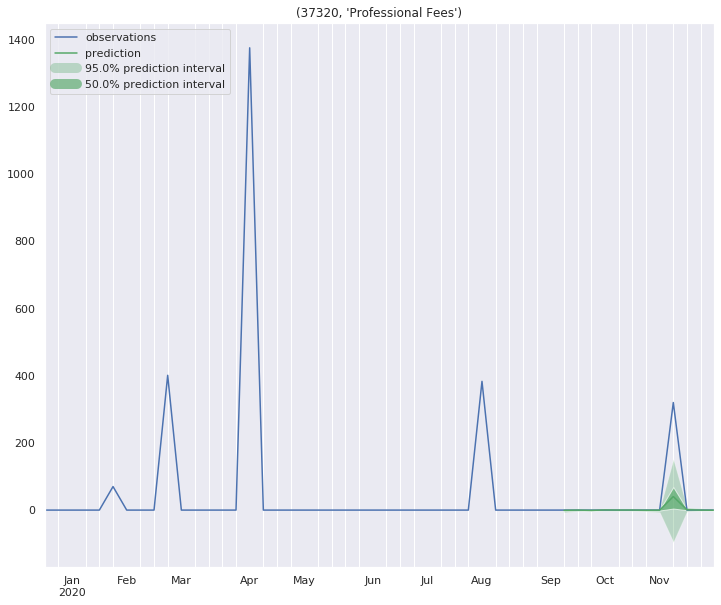

80


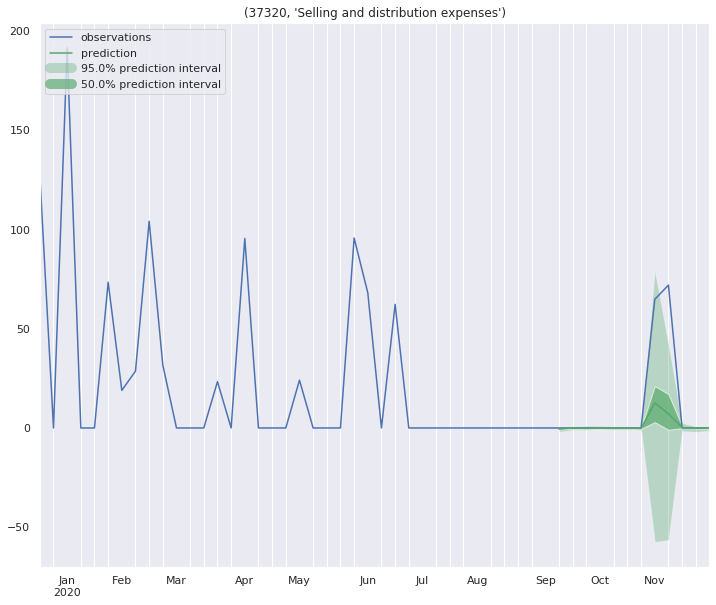

81


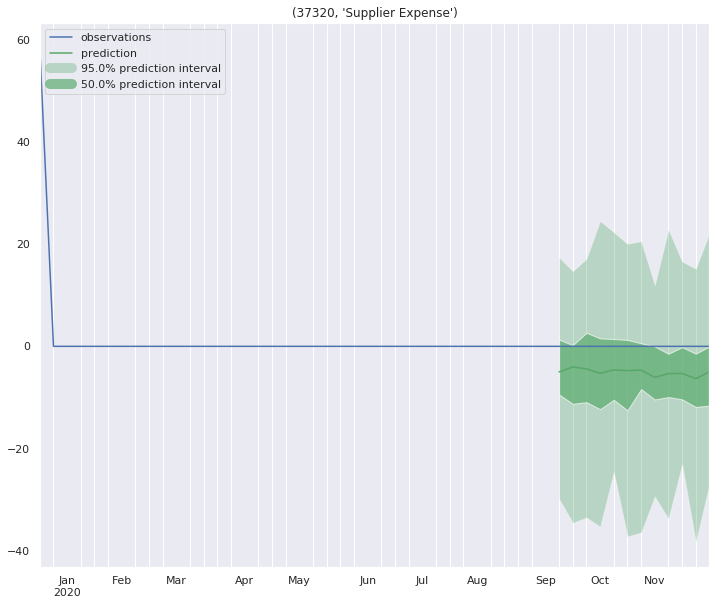

82


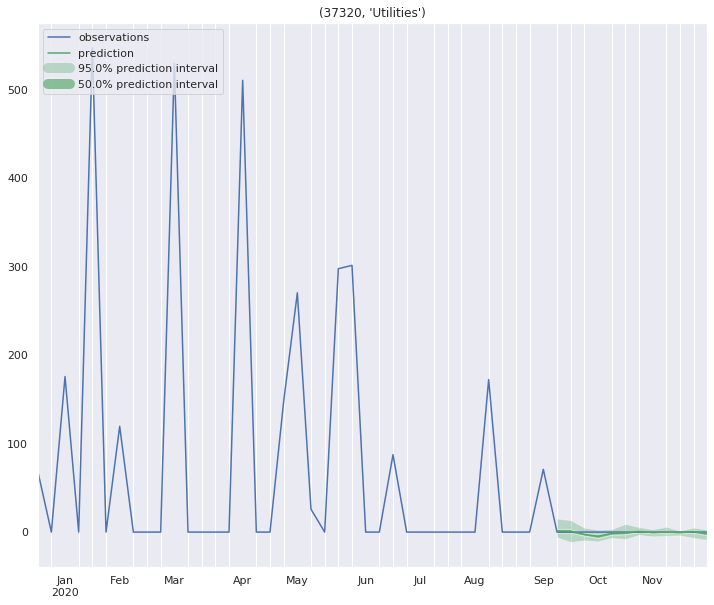

83


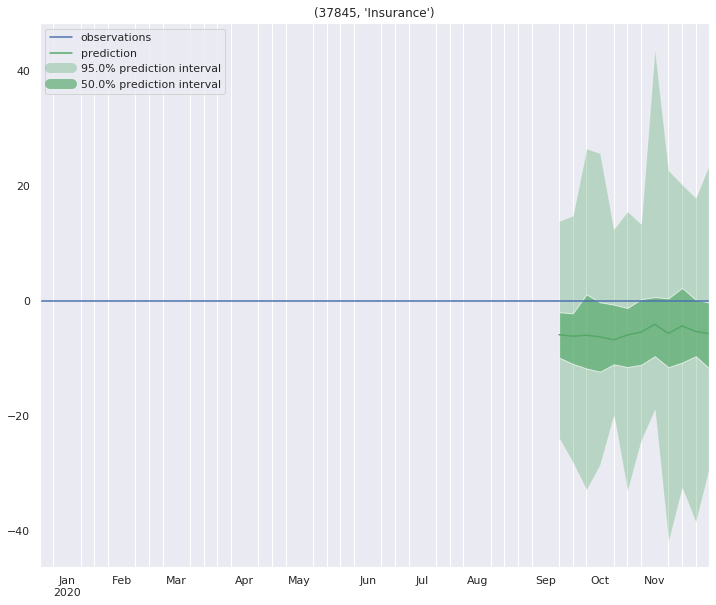

84


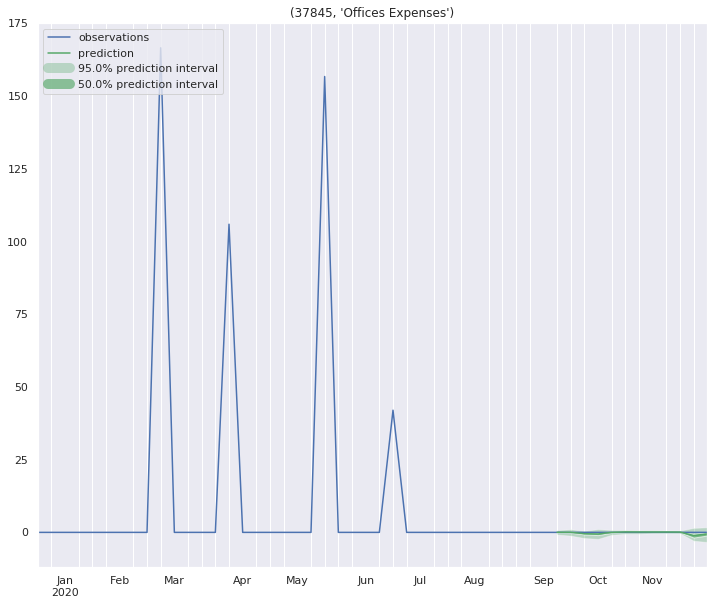

85


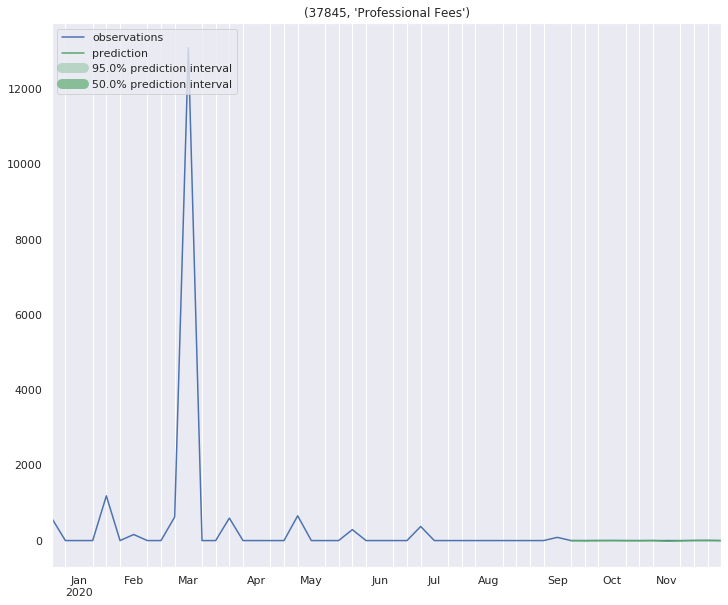

86


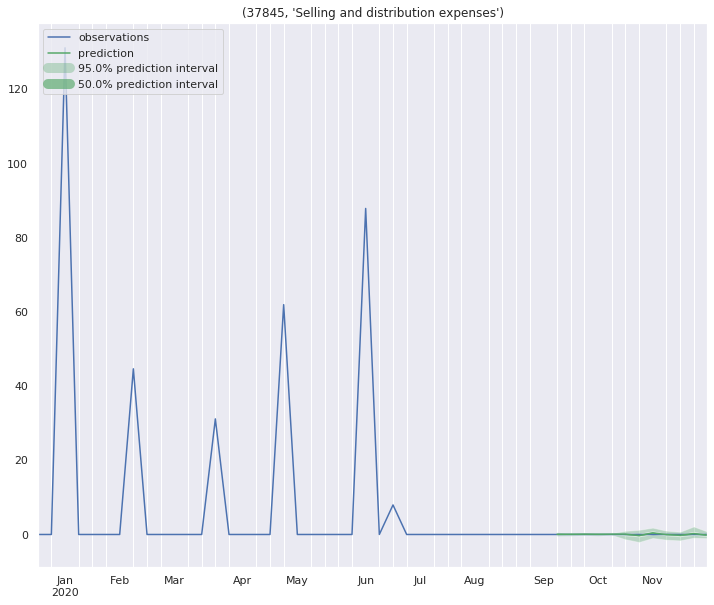

87


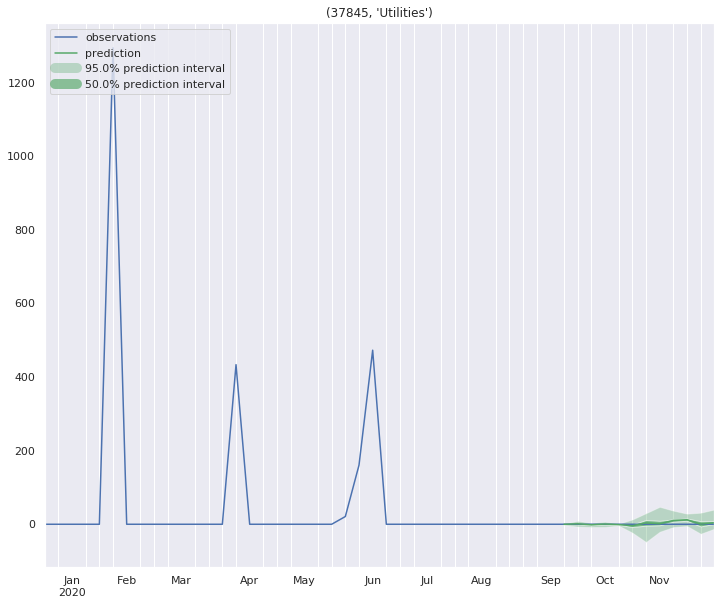

88


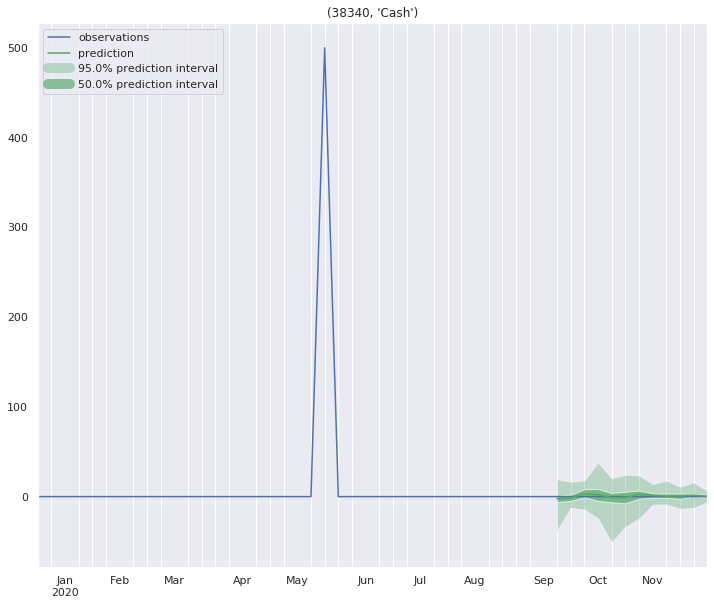

89


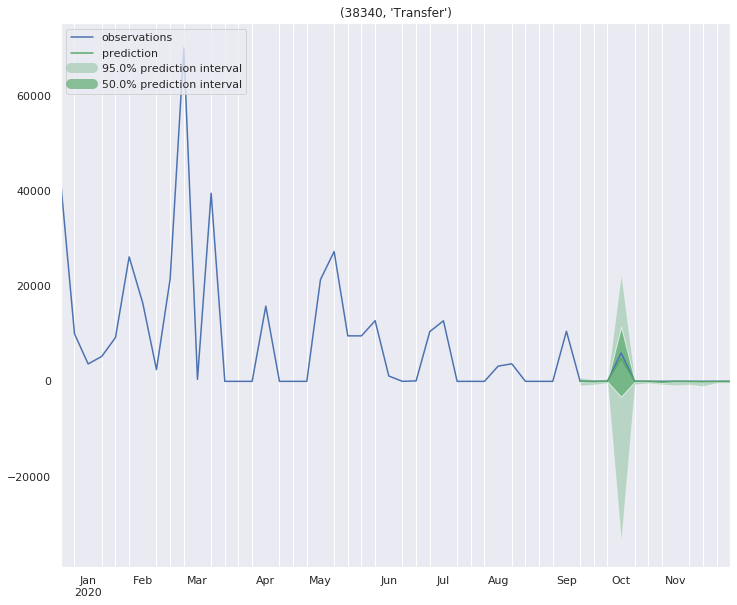

90


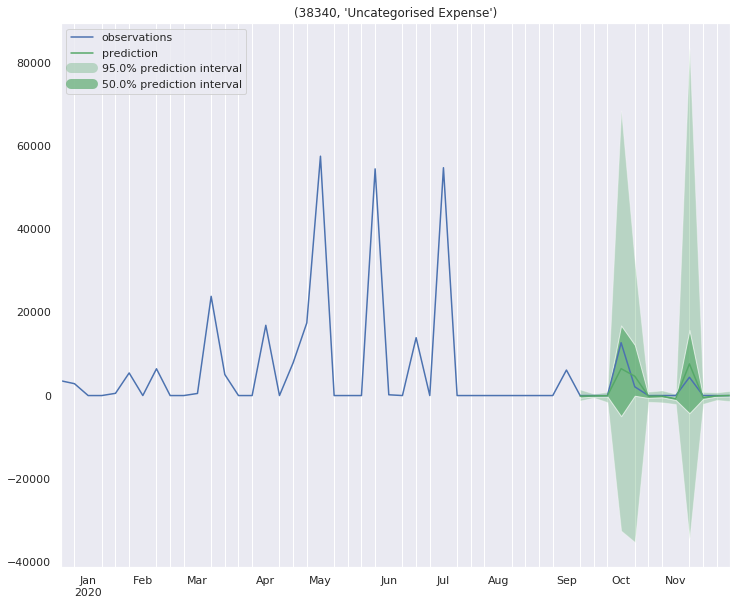

91


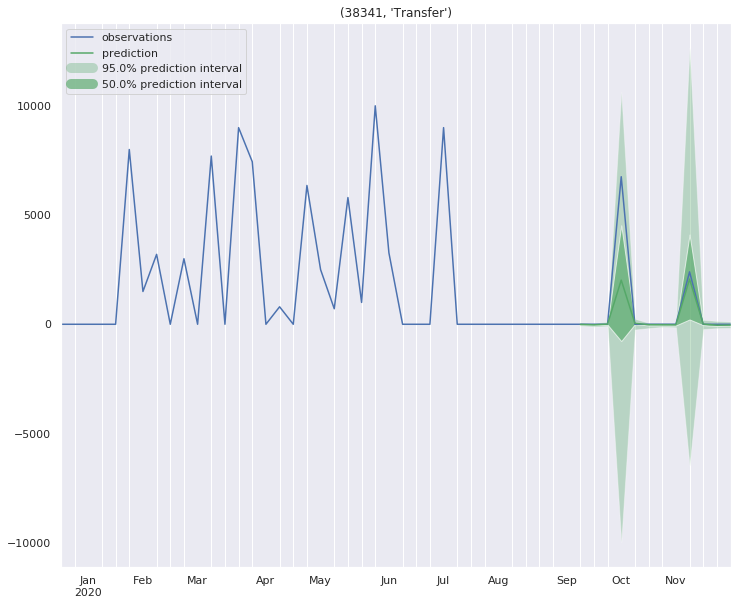

92


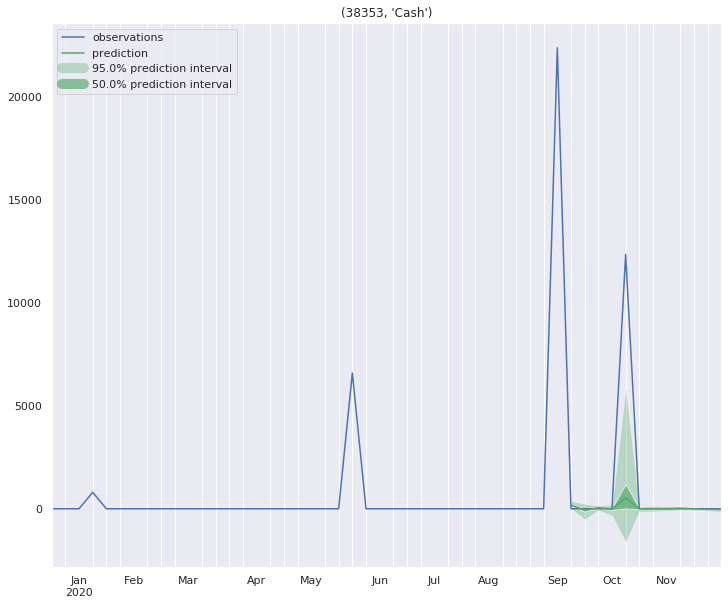

93


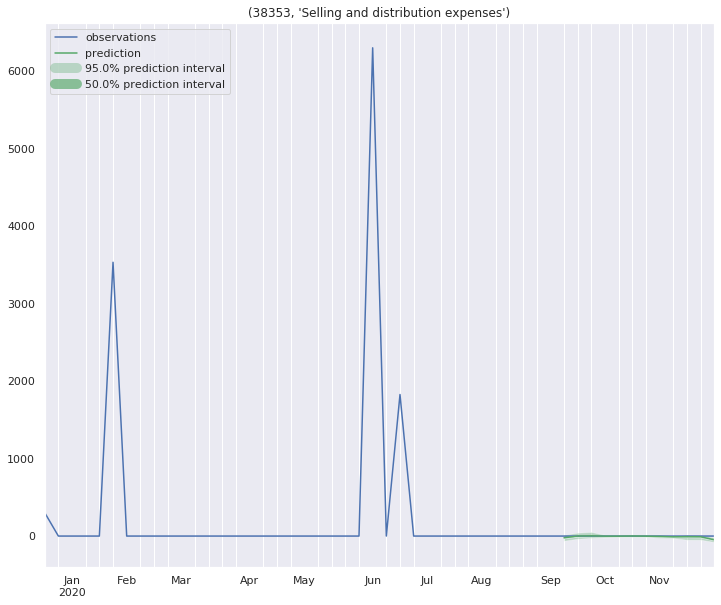

94


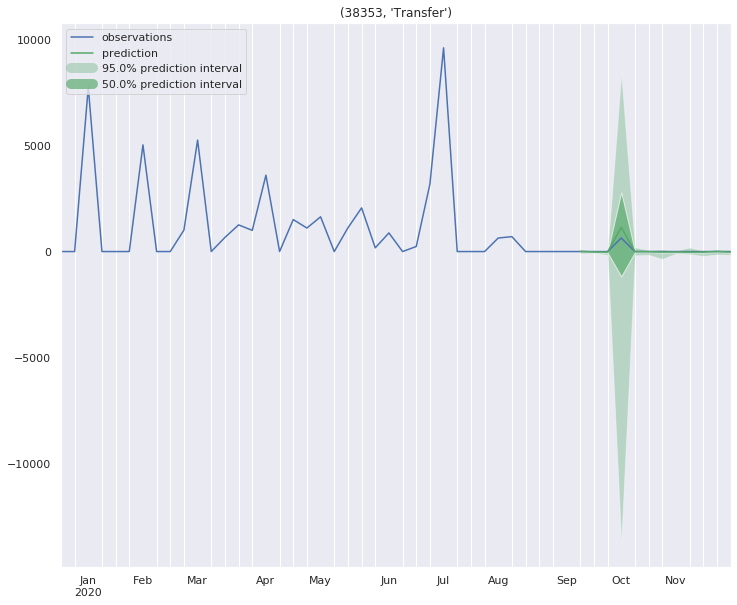

95


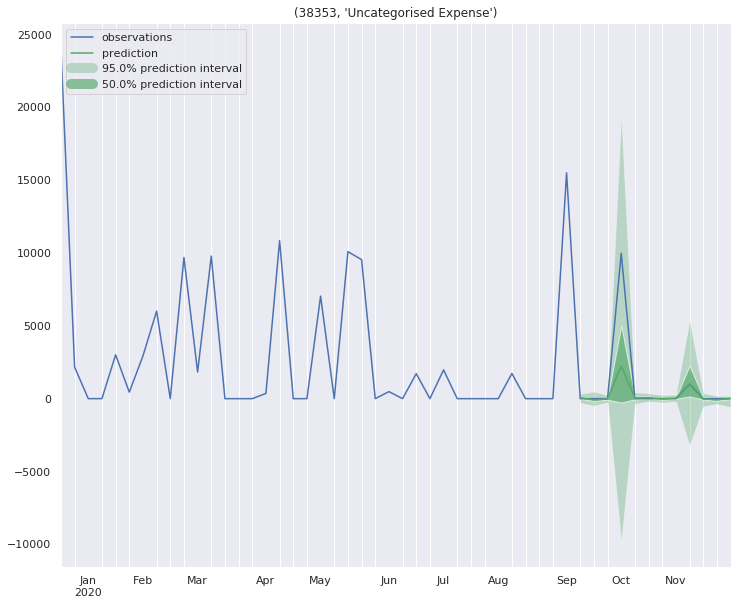

96


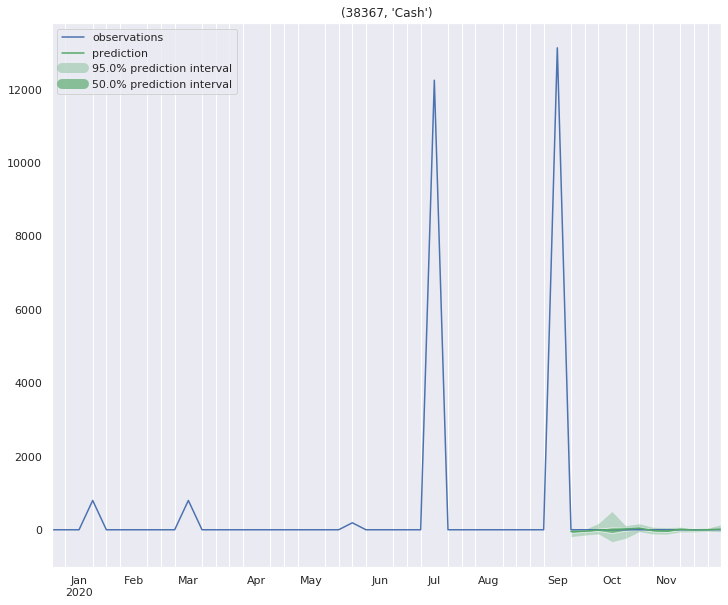

97


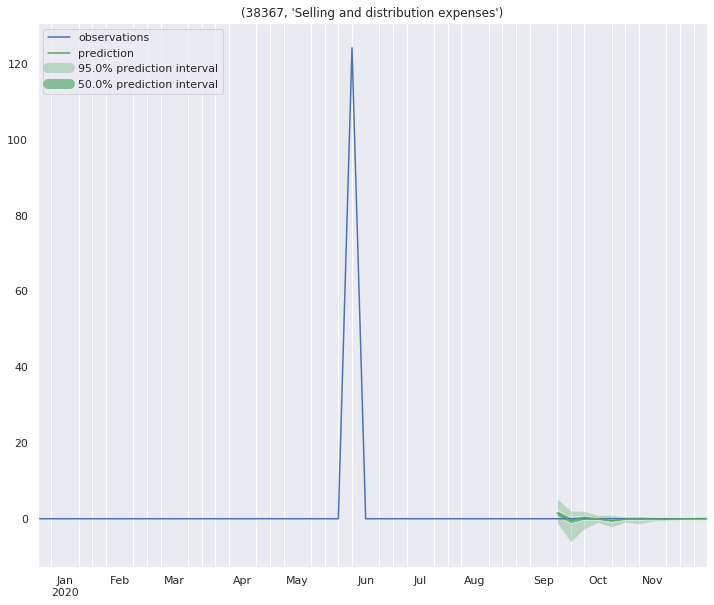

98


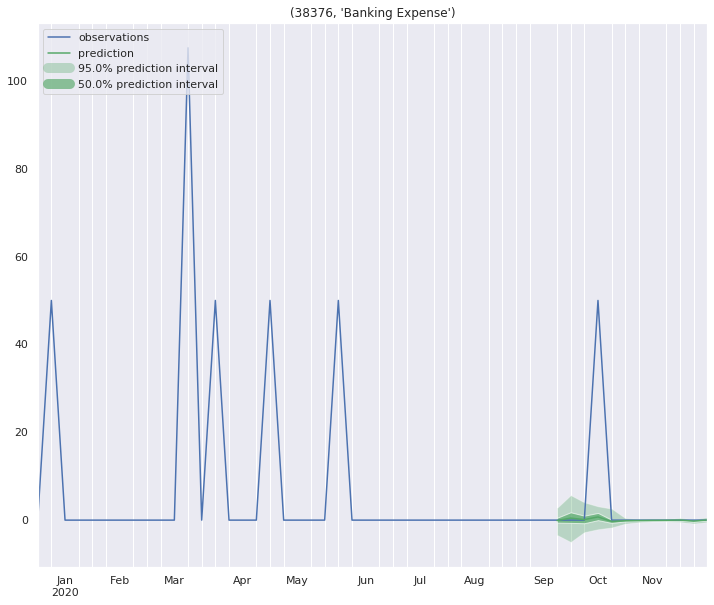

99


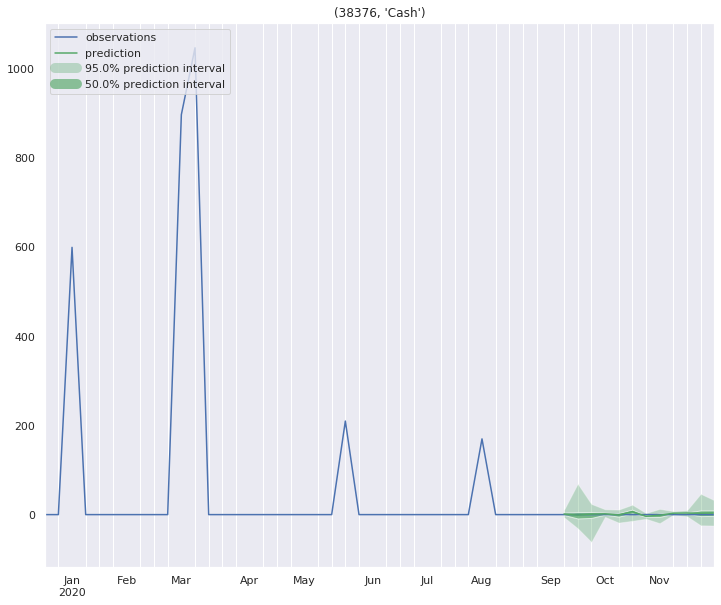

In [238]:
for i in range(50,100):
    print(i)
    plot_prob_forecasts(tss[i], forecasts[i], filenames[i])




 As for the evaluation scheme of the model presented, since cross-validation methods reflect a pitfall in time series forecasting scenarios as they may result in a significant overlap between train and test data, the optimum approach is to simulate models in a ”walk-forward” sequence, periodically re-training the model to incorporate specific chunks of transaction data available at that point in time.
 
![title](./input/food_safety_5.jpg)

![title](./input/results.jpg)

In the table above the performance of the cash flow prediction model is presented in terms of various evaluation metrics. In detail, seasonal error, MASE, sMAPE, MSIS and Quantile Loss are depicted, with the Coverage provided by different confidence levels being presented as well. The results refer to average values for all the incorporated accounts per transaction category.

As expected, the seasonal error of the Subscriptions and Donations Category is the lowest followed by the Insurance expenses. On the other hand, the Uncategorized expenses yield the highest seasonal error, denoting that there is low seasonal factor in this type of expenses.  


The presented results highlight that the proposed methodology produces outcomes that can hardly accomplish the required approach based on the Coverage. In a probabilistic way, that is translated that for a given confidence level of e.g. 80\%, the model is underperforming given the average values of the categories.



# All Acounts - All Expenses

In [239]:
df = transactions_df[transactions_df['TransactionDate'] < '2020-06-12 00:00:00']

In [240]:
df = df[df['Debit_CreditIndicator']=='D']

In [241]:
df.set_index(['TransactionDate'], inplace=True)

In [242]:
df = df.sort_index()

In [243]:
FREQ="1W"

start_date = df.index[0]
end_date = df.index[-1]

print(start_date)
print(end_date)
index = pd.date_range(start=start_date, end=end_date, freq=FREQ)

2017-01-07 00:00:00
2020-06-06 00:00:00


In [244]:
df_grouped = df.groupby(['skAcctKey'])

In [245]:
dataframes = []
filenames = []

for group in df_grouped.groups:
    if len(df_grouped.get_group(group))>THRESHOLD_NUMBER_OF_TRANSACTIONS:
        df = df_grouped.get_group(group)
        df = df[['Amount','Master_Category','month','day_of_month','day_of_week']]
        df.fillna(0, inplace=True)
        df = df.sort_index()
        
        mockup_dataframe = pd.DataFrame(index=index)
    
        df_category = df.resample(FREQ).sum()
        mockup_dataframe = pd.merge(mockup_dataframe, df_category,  how='left', left_index=True, right_index=True)    
    
        mockup_dataframe = mockup_dataframe.resample(FREQ).sum()
    
        filenames.append(group)
        dataframes.append(mockup_dataframe)
    

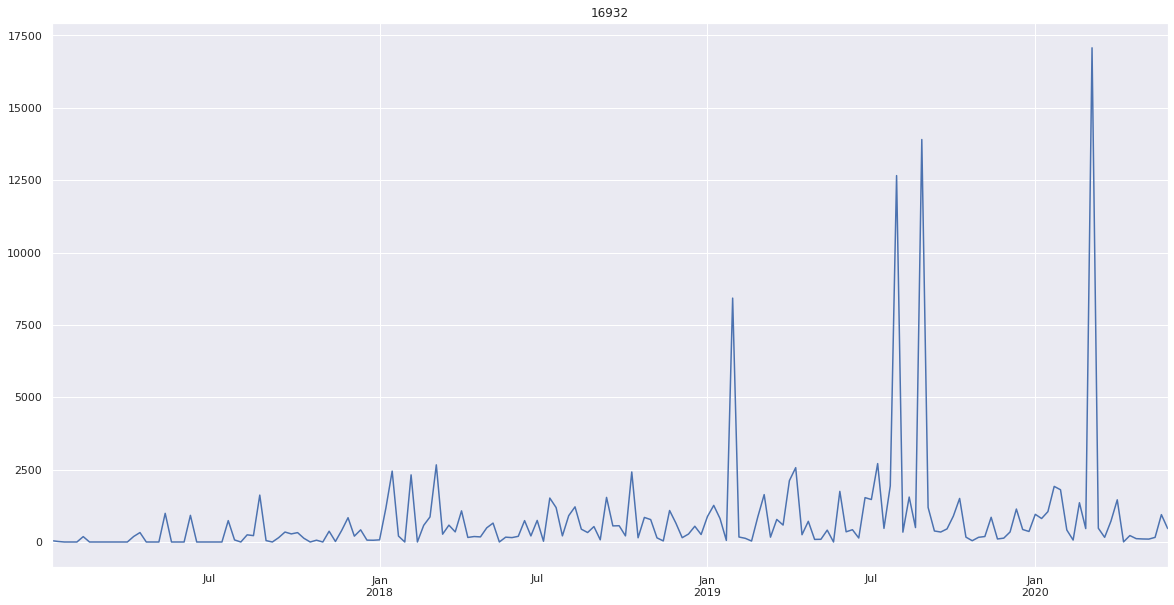

In [246]:
plt.figure(figsize=(20,10))
dataframes[1]['Amount'].plot(title=filenames[1])

In [247]:
N=len(dataframes)
T = len(dataframes[0])
starts = []
print('Number of Timeseries :' + str(N))
print('Number of Samples in each ts :' +str(T))
print('Freq : ' + FREQ)

Number of Timeseries :2783
Number of Samples in each ts :178
Freq : 1W


In [248]:
custom_dataset = dataframes

In [249]:
PREDICTION_LENGTH = 12
CONTEXT_LENGTH = 24

custom_ds_metadata = {'num_series': N,
                      'prediction_length': PREDICTION_LENGTH,
                      'context_length': CONTEXT_LENGTH,
                      'freq': FREQ
                     }

In [250]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation.backtest import make_evaluation_predictions


train_ds = common.ListDataset([{'target': custom_dataset[i].Amount[:-custom_ds_metadata['prediction_length']], 'start': custom_dataset[i].index[0], 'feat_dynamic_real': [custom_dataset[i].month[:-custom_ds_metadata['prediction_length']],
                                                                                      custom_dataset[i].day_of_month[:-custom_ds_metadata['prediction_length']],
                                                                                      custom_dataset[i].day_of_week[ :-custom_ds_metadata['prediction_length']]]}
                        for i in range(N)],
                       freq=custom_ds_metadata['freq'])


# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = common.ListDataset([{'target': custom_dataset[i].Amount[:], 'start': custom_dataset[i].index[0], 'feat_dynamic_real': [custom_dataset[i].month[:],
                                                                                      custom_dataset[i].day_of_month[:],
                                                                                      custom_dataset[i].day_of_week[:]]}
                       for i in range(N)],
                      freq=custom_ds_metadata['freq'])

In [251]:
estimator_dare = deepar.DeepAREstimator(
        prediction_length=custom_ds_metadata['prediction_length'],
        context_length=custom_ds_metadata['context_length'],
        freq=custom_ds_metadata['freq'],
           trainer=Trainer(epochs=10,
                            ctx="cpu",
                            num_batches_per_epoch=50,
                            ),
        use_feat_dynamic_real=True,
            dropout_rate=0.5
    )

In [252]:
predictor_dare = estimator_dare.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 24284
100%|██████████| 50/50 [00:02<00:00, 24.27it/s, avg_epoch_loss=8.69]
INFO:root:Epoch[0] Elapsed time 2.062 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.685536
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.94it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 1.929 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.497140
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.49it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[2] Elapsed time 1.963 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.812720
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.77it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[3] Elapsed time 1.942 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.325019
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.11it/s, avg_epoch_loss=7.1]
INFO:r

In [253]:
def make_forecasts(predictor, test_data, n_sampl):
    """Takes a list of predictors,gluonTS test data and number of samples
    and returns forecasts for each of them"""
    forecasts = []
    tss = []
    forecast_it, ts_it = make_evaluation_predictions(
                dataset=test_ds,
                predictor=predictor,
                num_samples=n_sampl
           )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss

In [254]:
forecasts, tss = make_forecasts(predictor_dare, test_ds, 500)

In [255]:
def plot_prob_forecasts(ts_entry, forecast_entry, ts_name):
    plot_length = 50
    prediction_intervals = (50.0,95.0)
    pred = np.percentile(forecast_entry.samples, 1)
    legend = ["observations", "prediction"] 

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
#     ts_entry.plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='r')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(ts_name)
    plt.show()

500


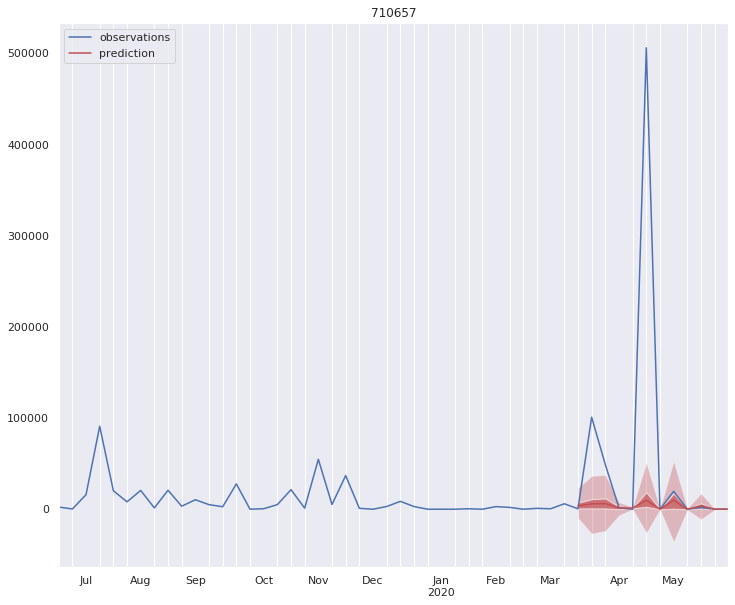

501


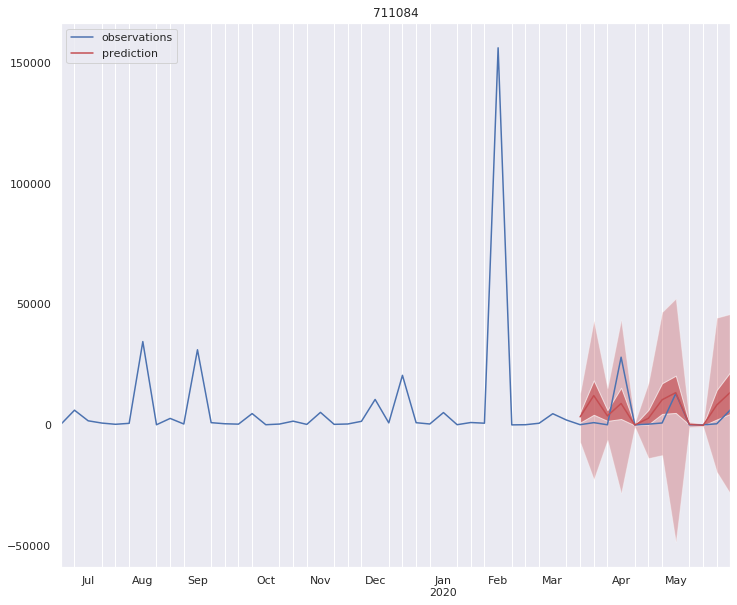

502


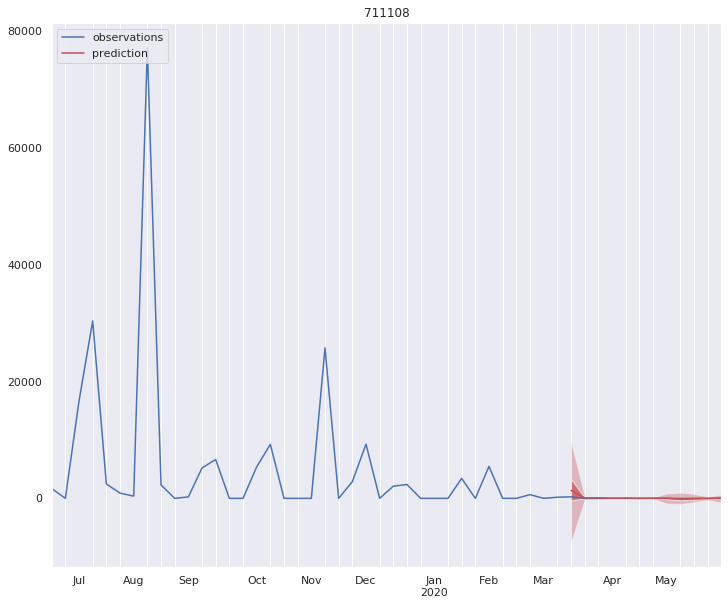

503


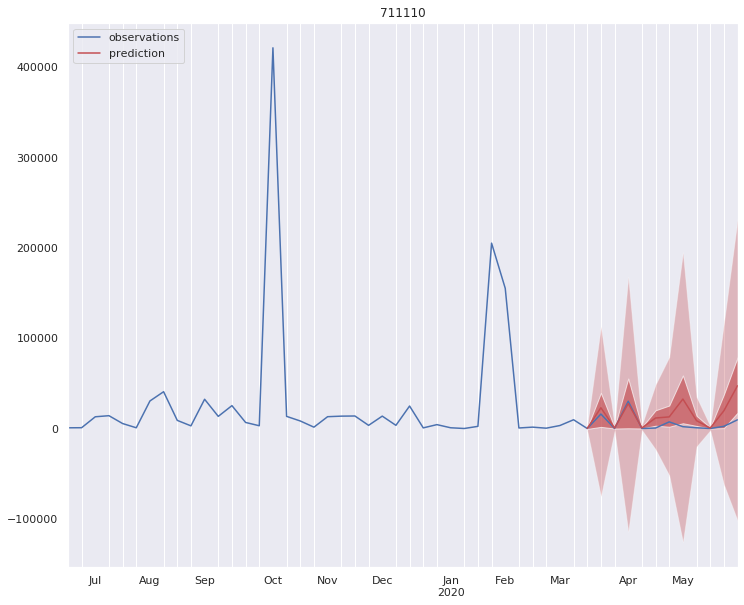

504


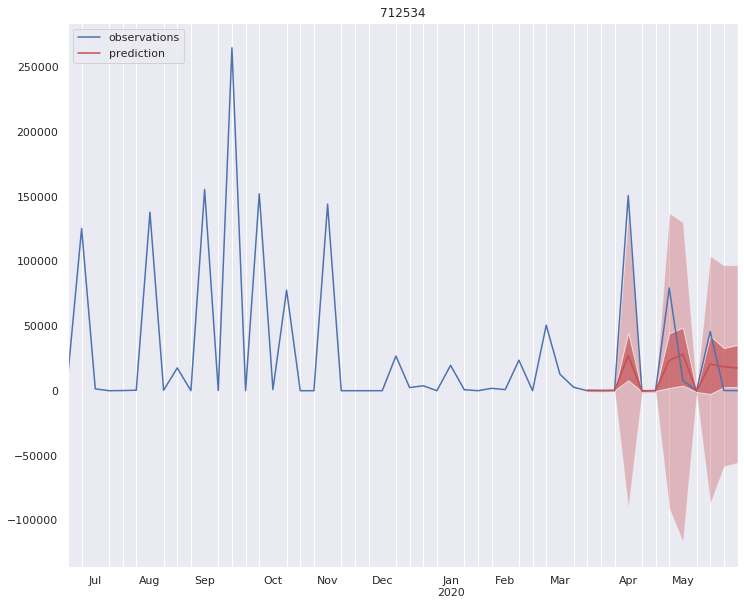

505


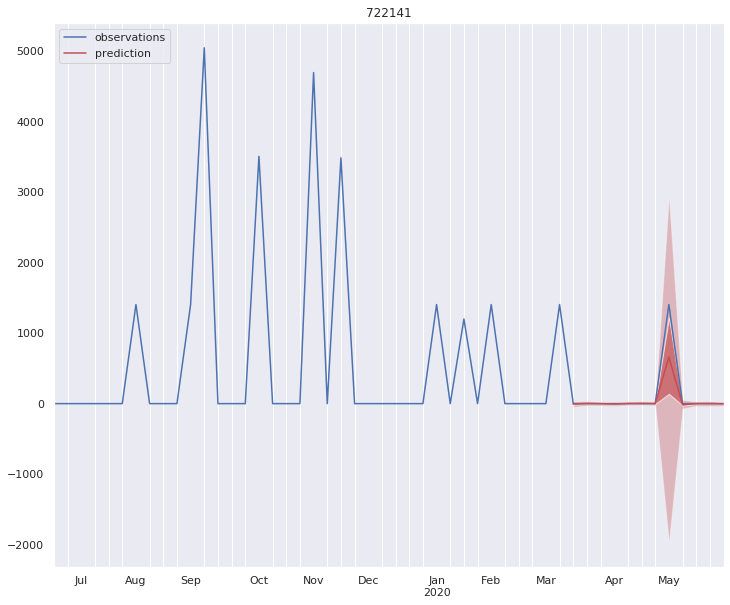

506


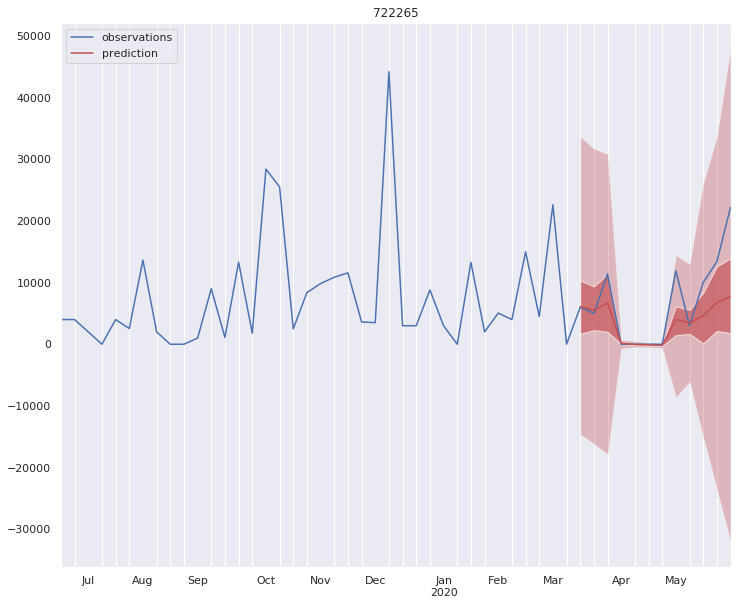

507


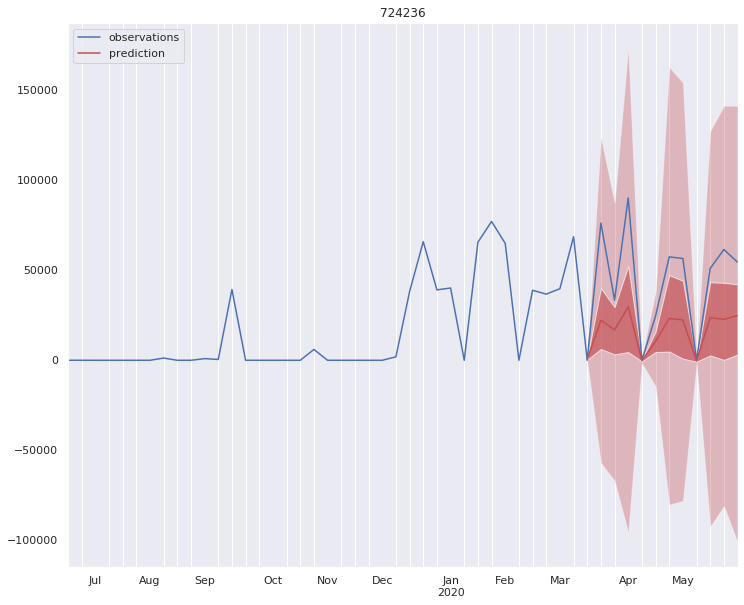

508


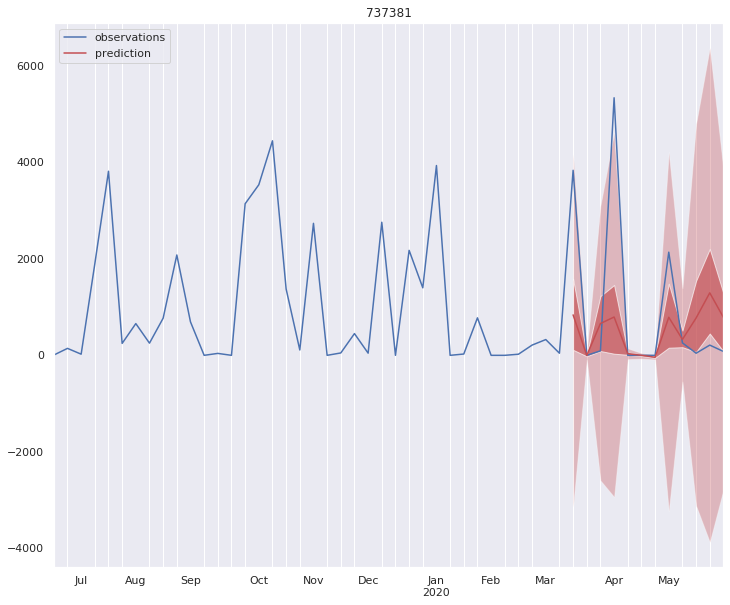

509


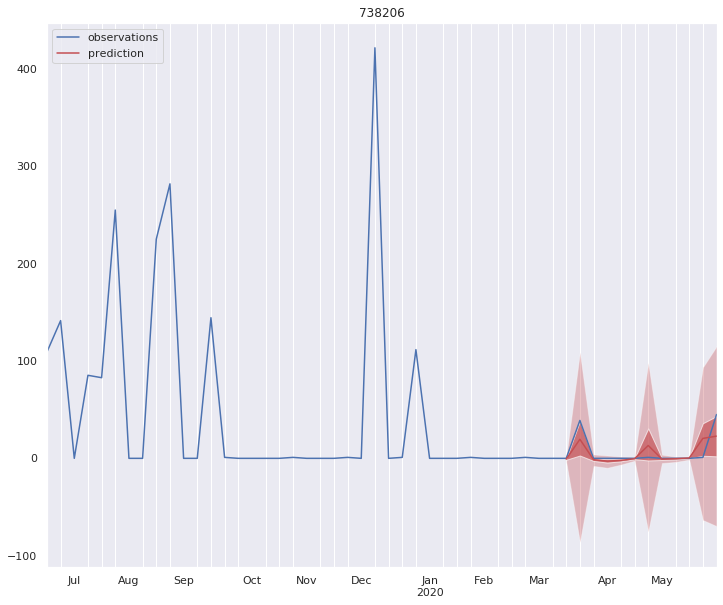

510


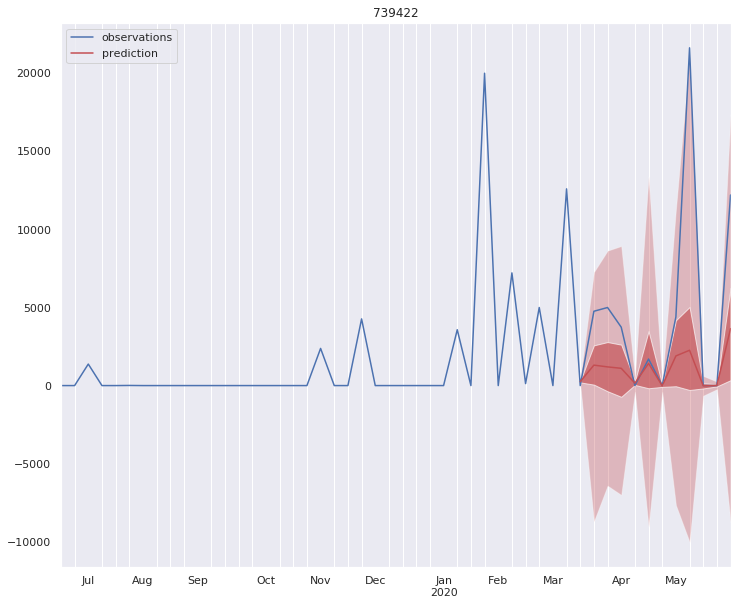

511


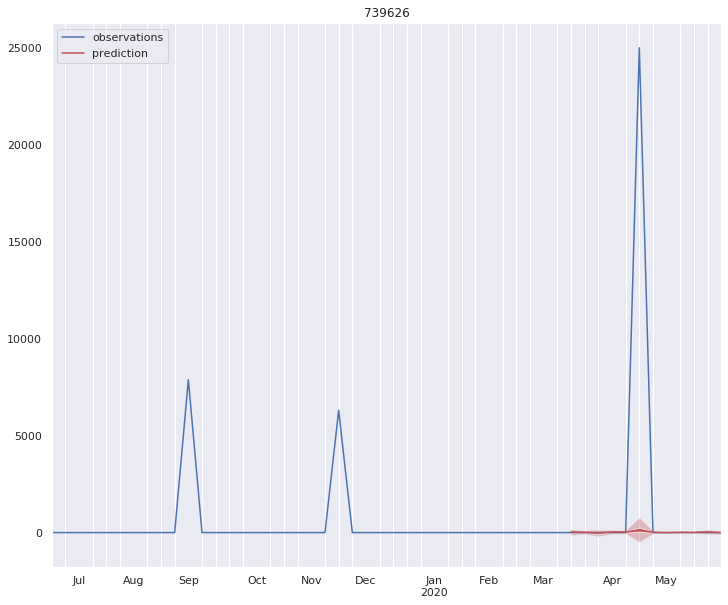

512


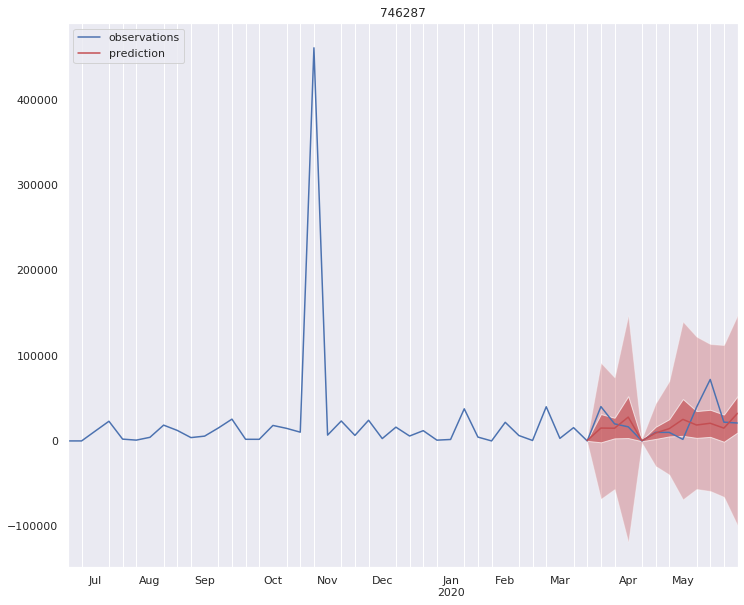

513


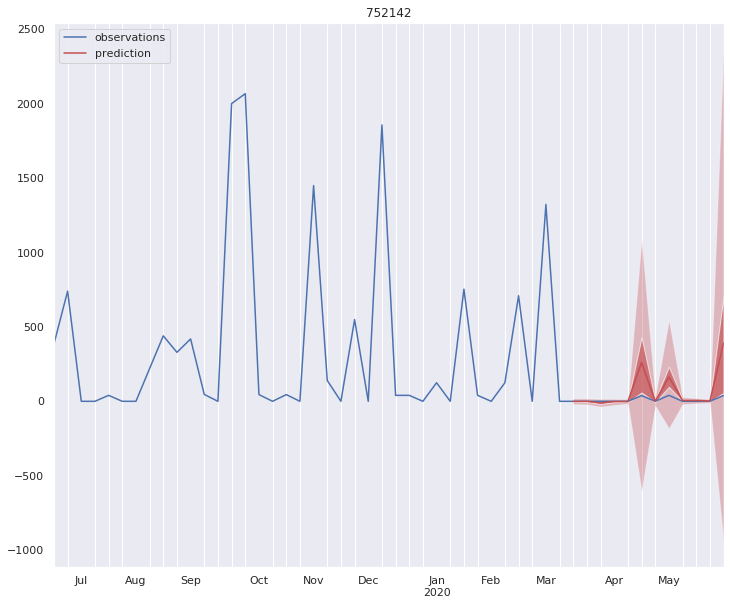

514


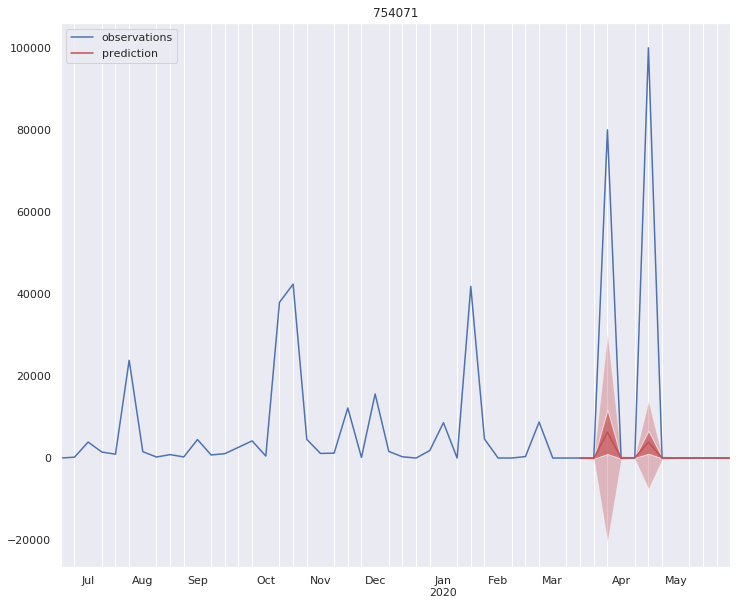

515


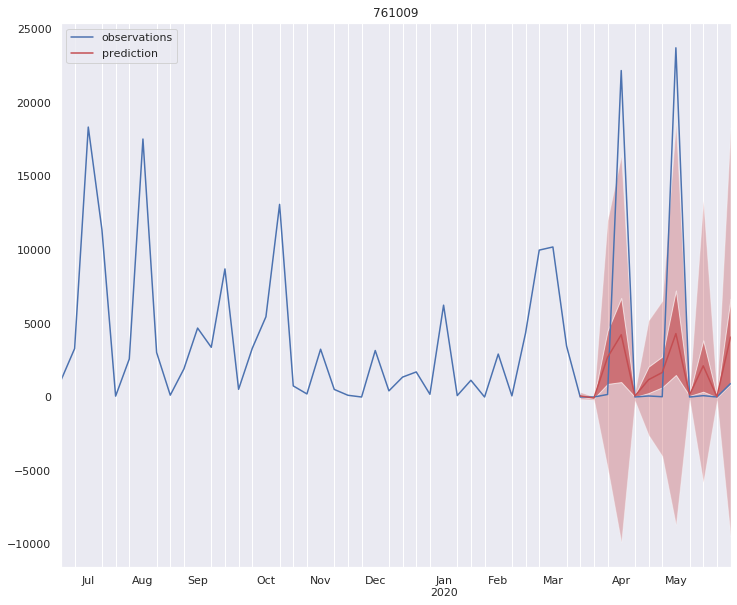

516


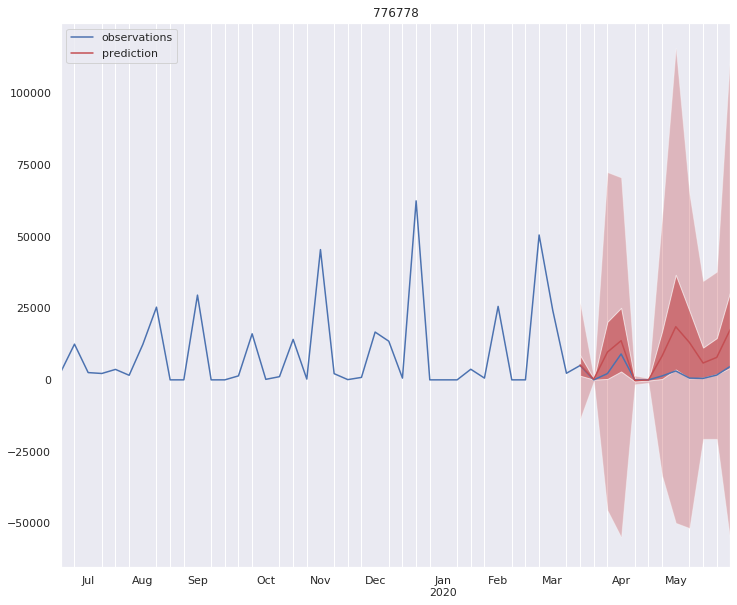

517


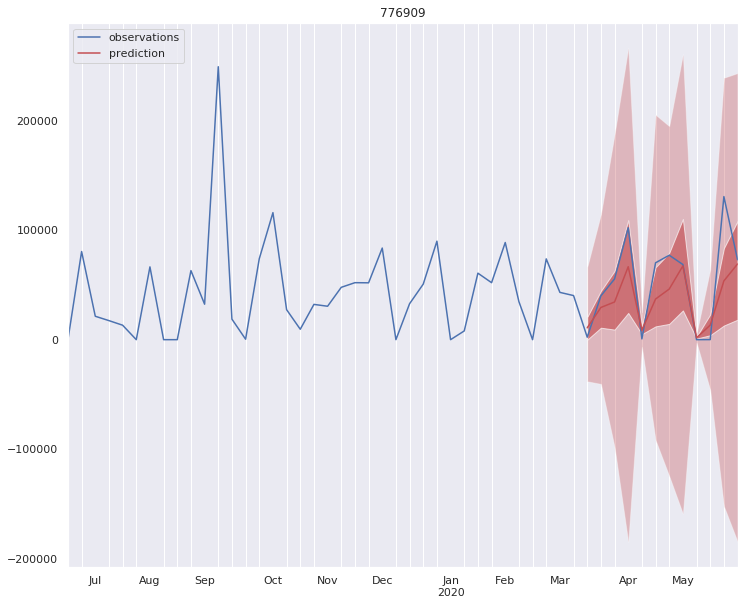

518


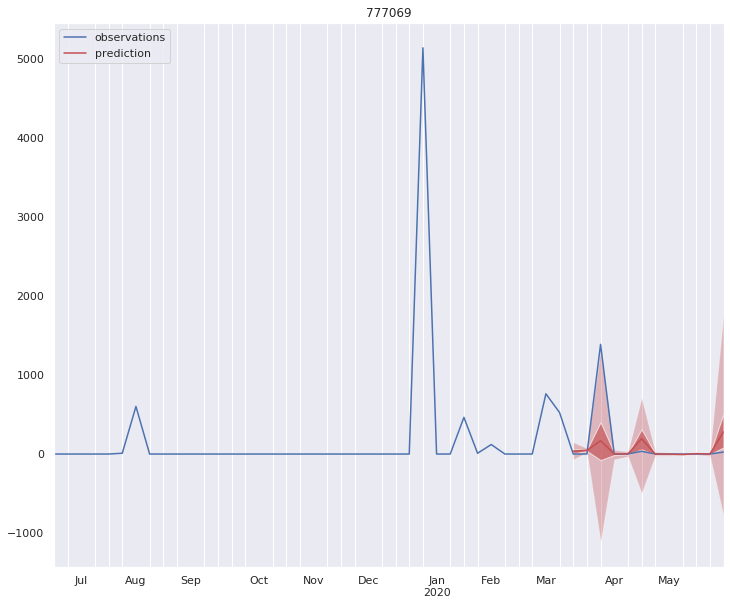

519


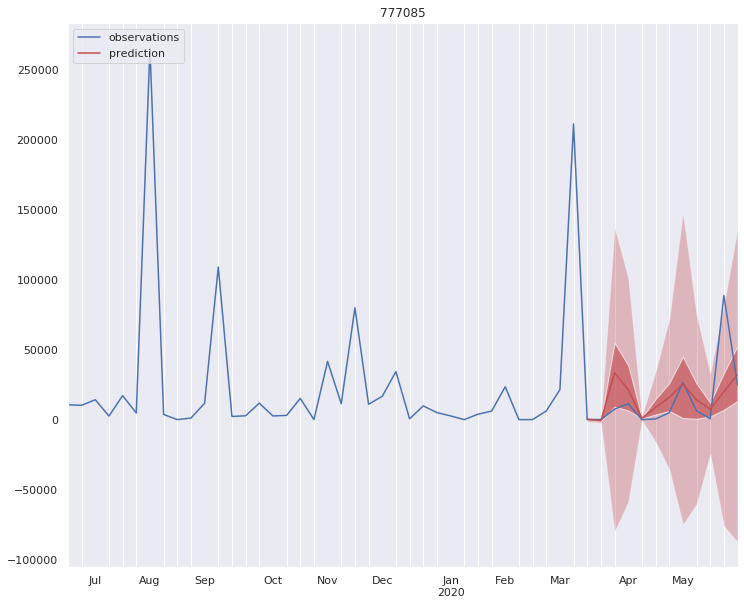

520


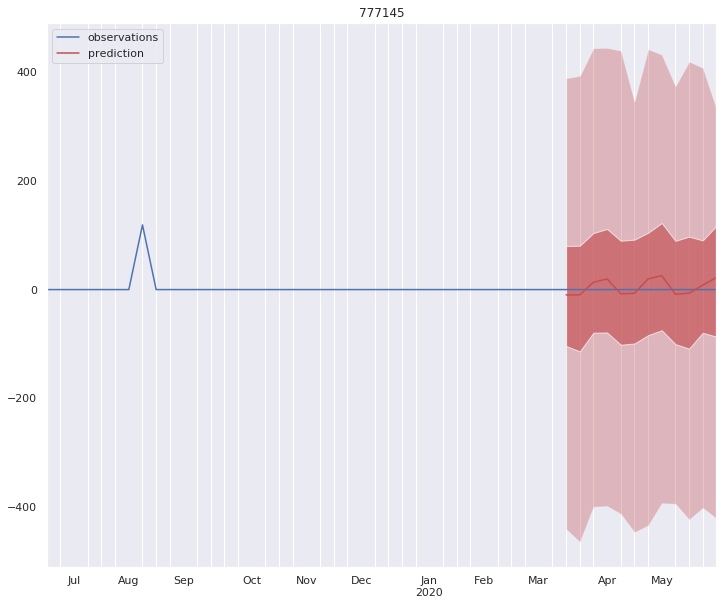

521


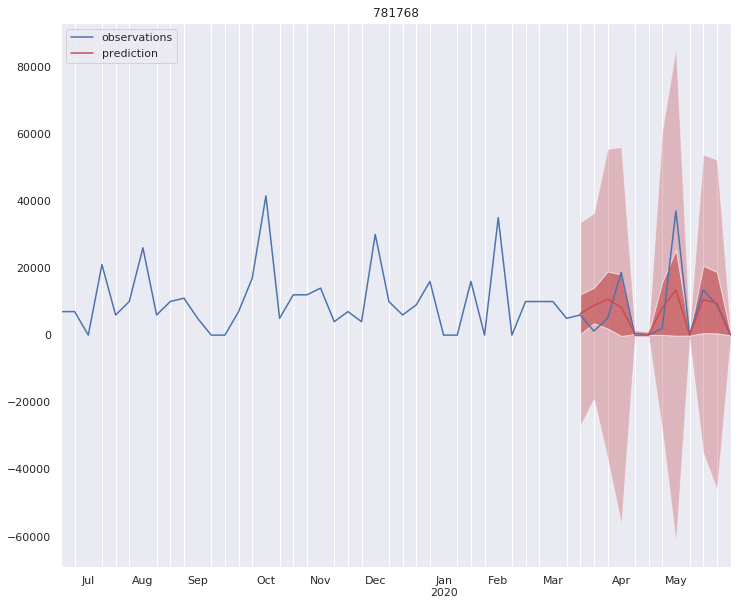

522


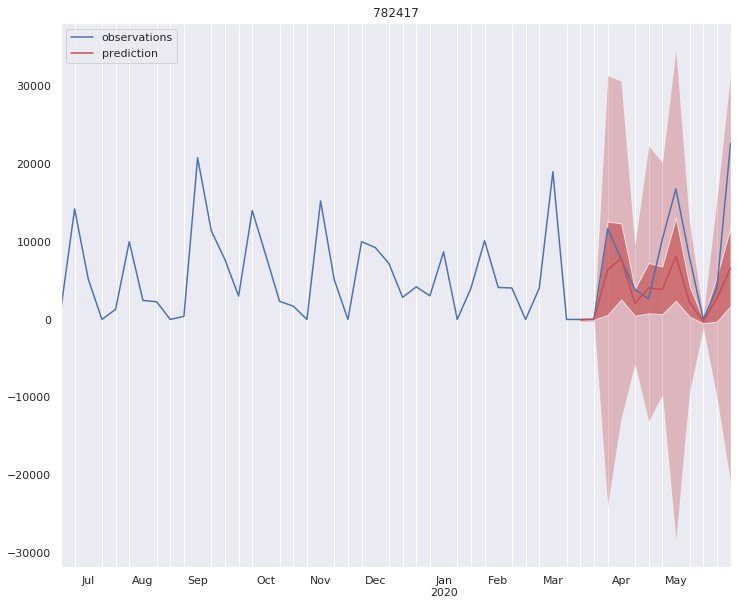

523


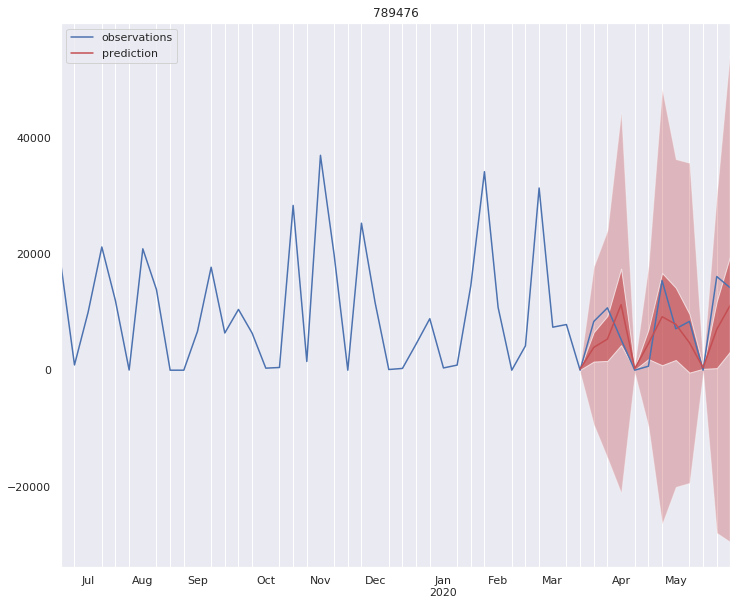

524


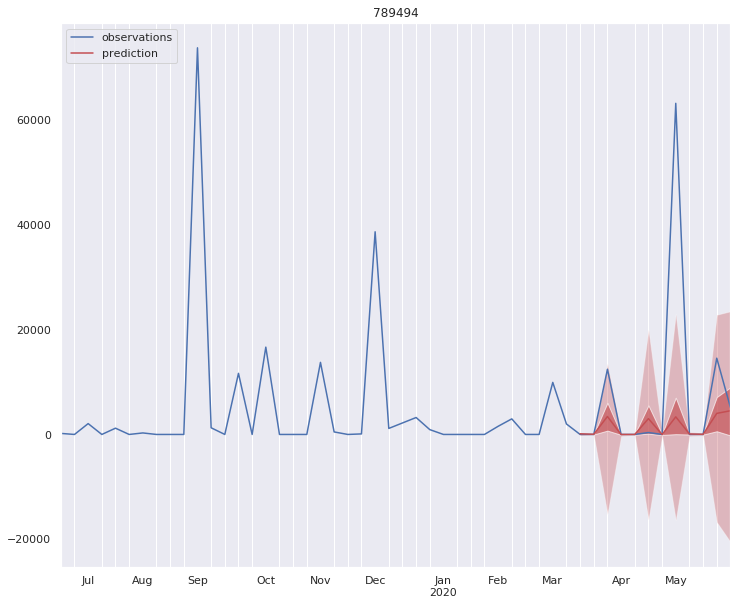

525


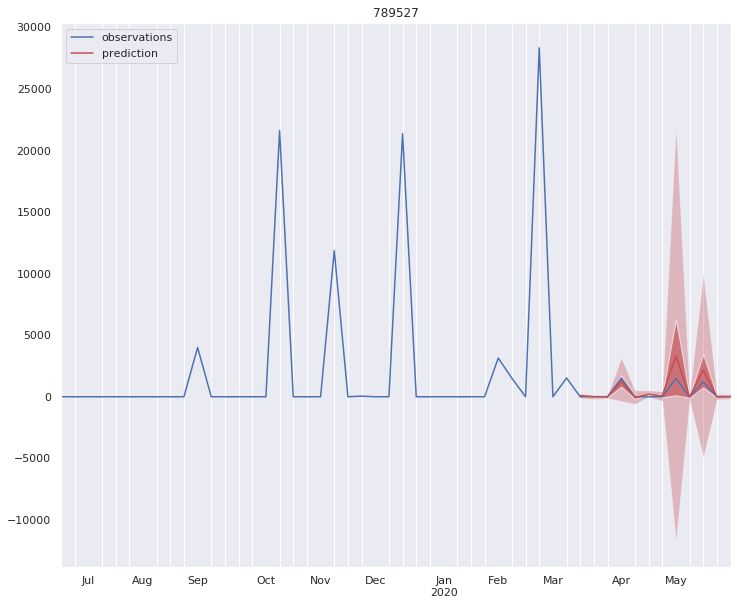

526


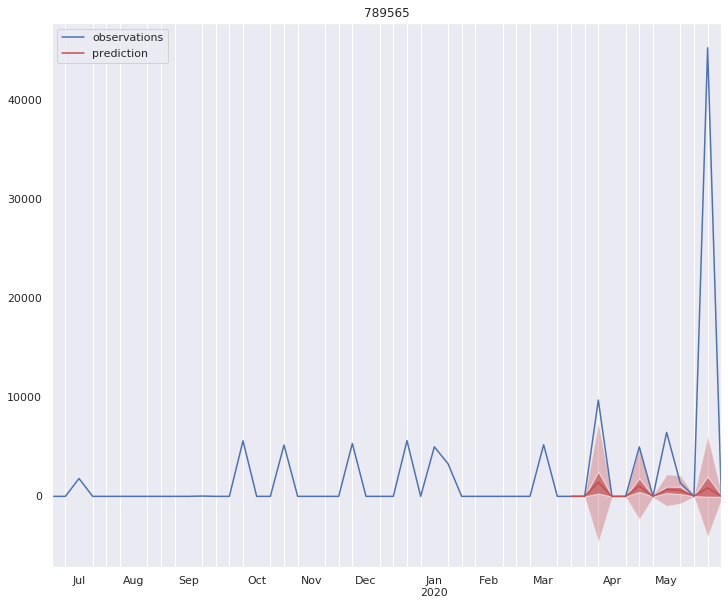

527


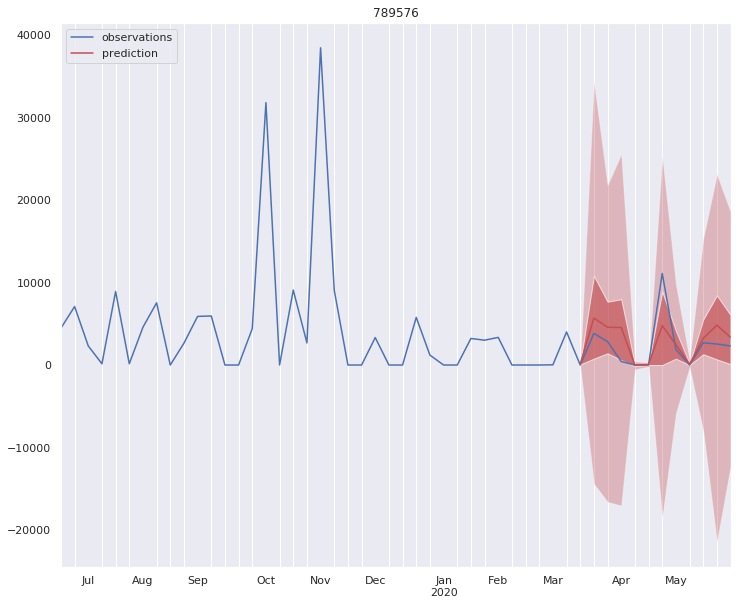

528


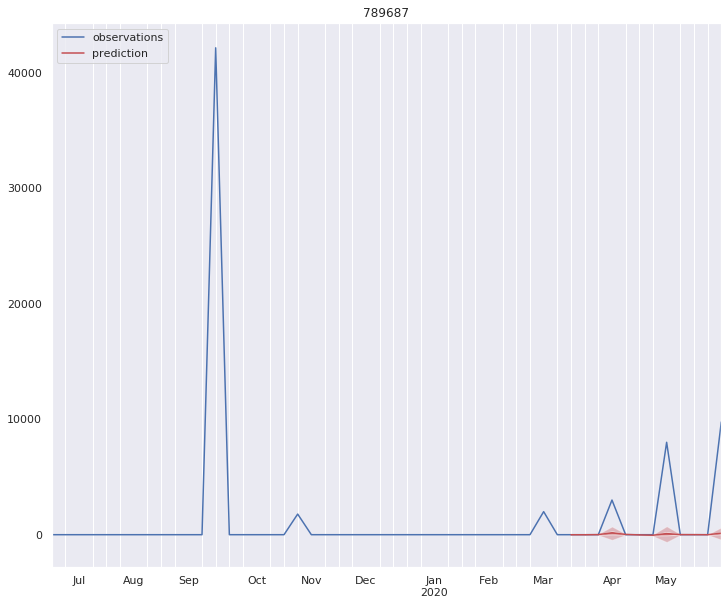

529


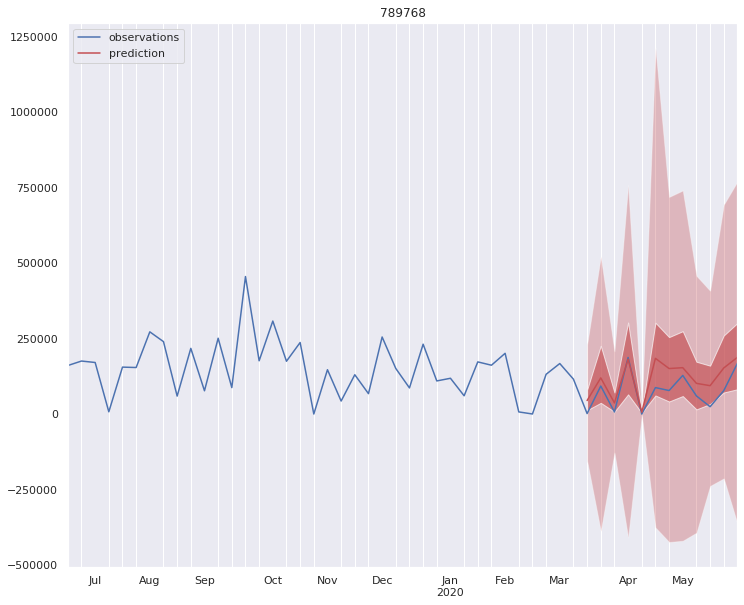

530


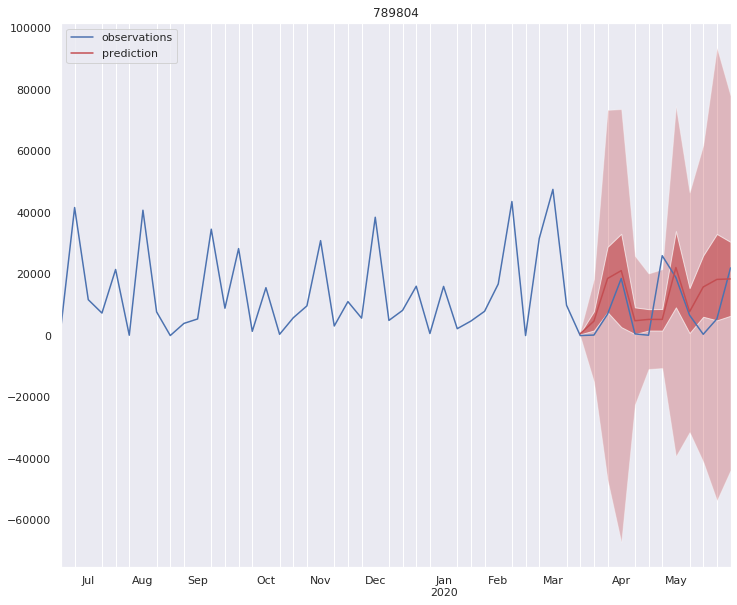

531


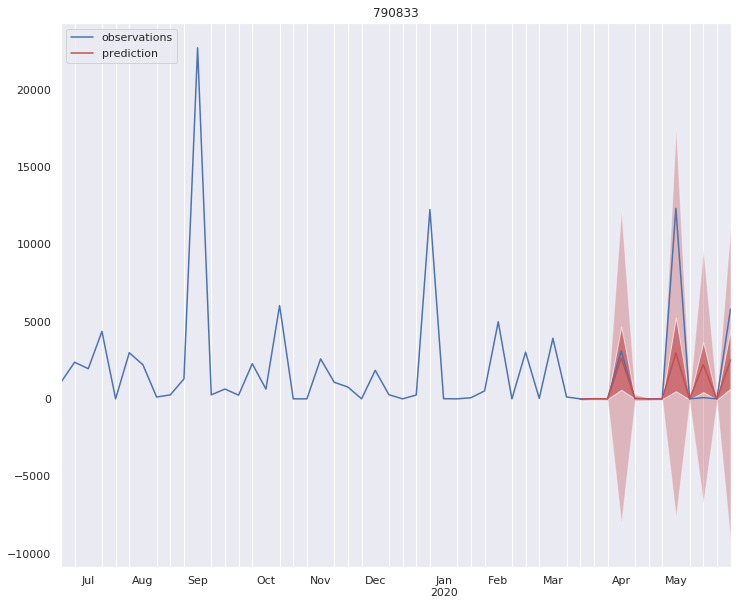

532


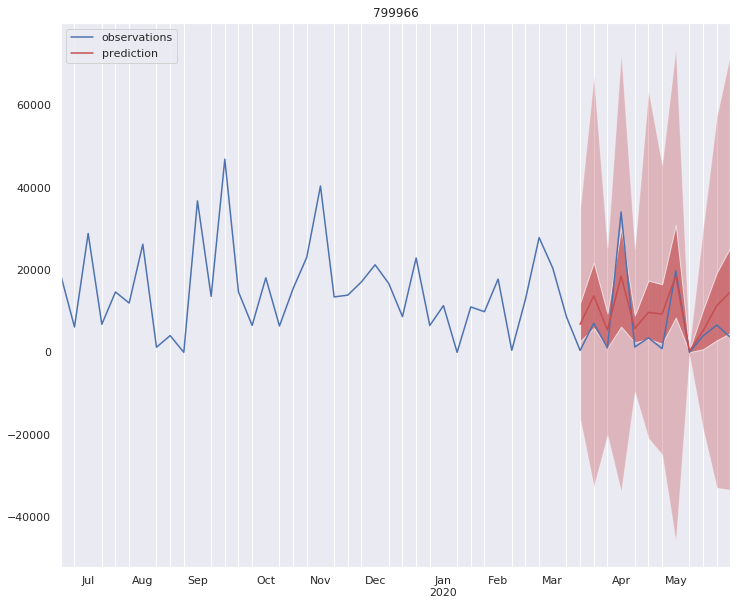

533


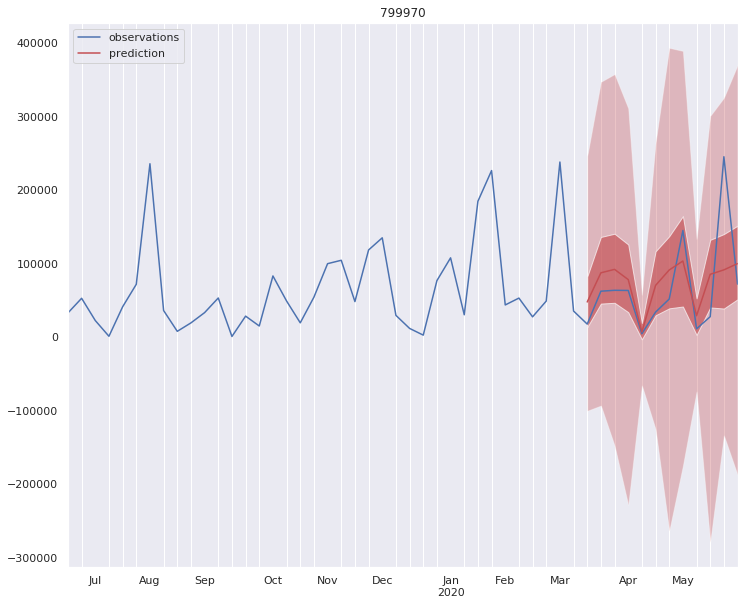

534


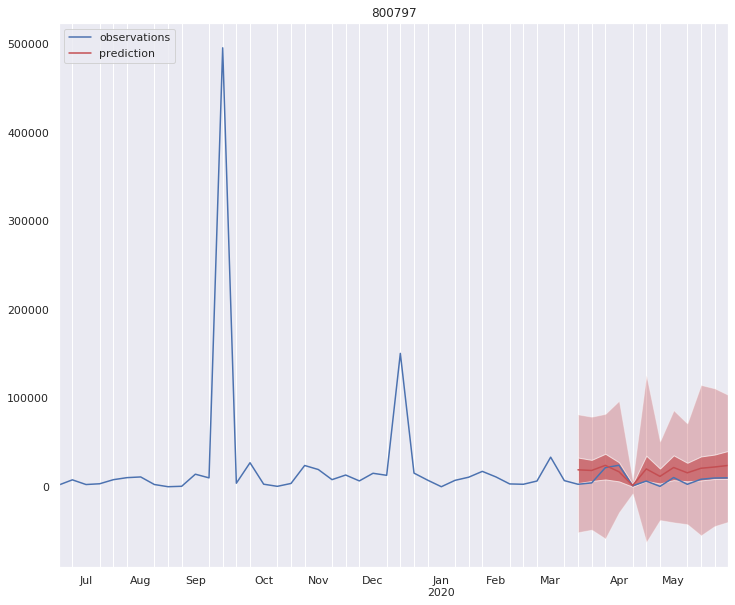

535


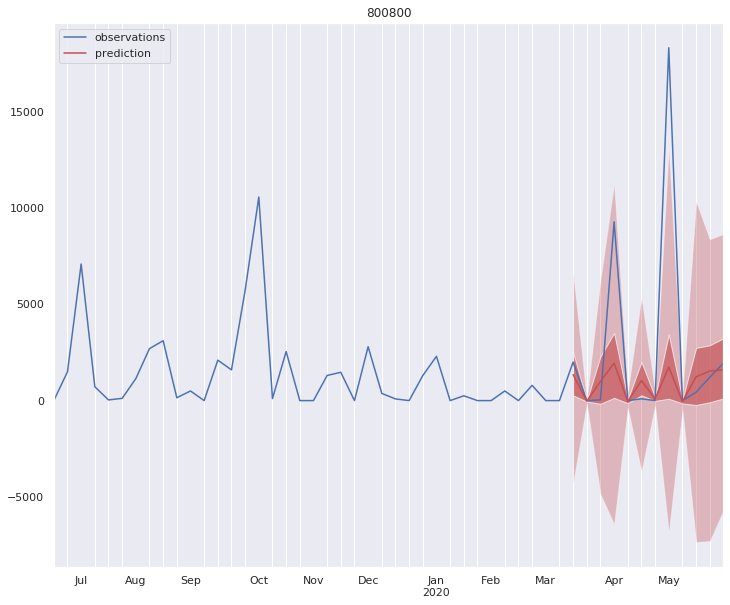

536


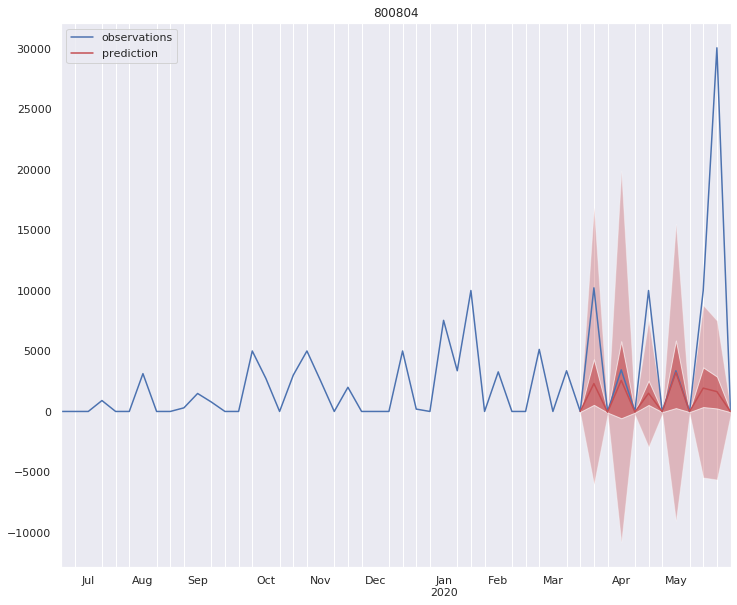

537


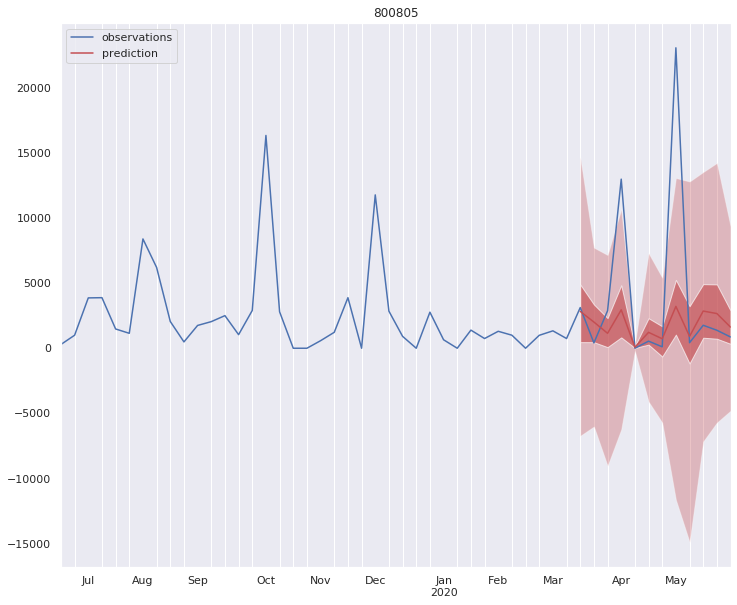

538


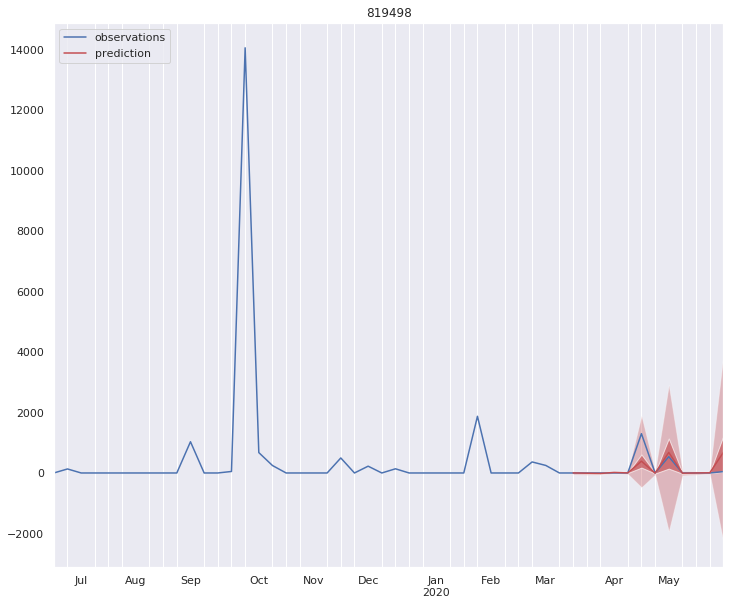

539


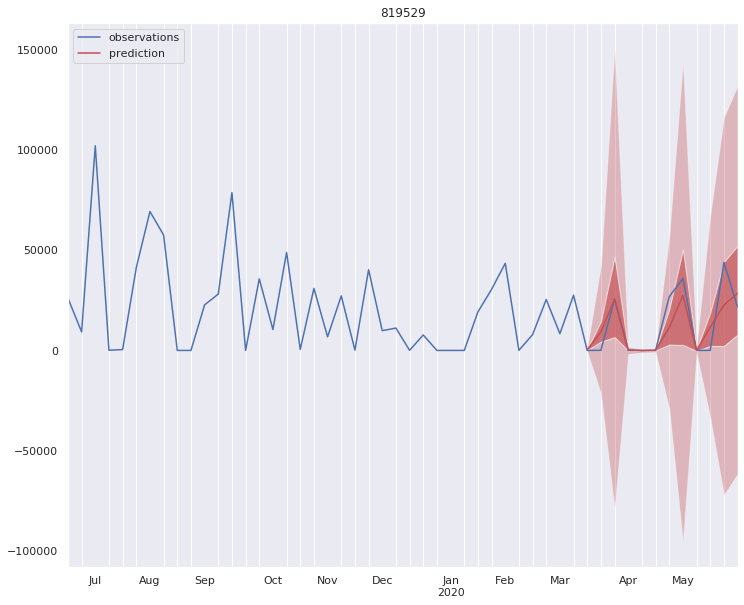

540


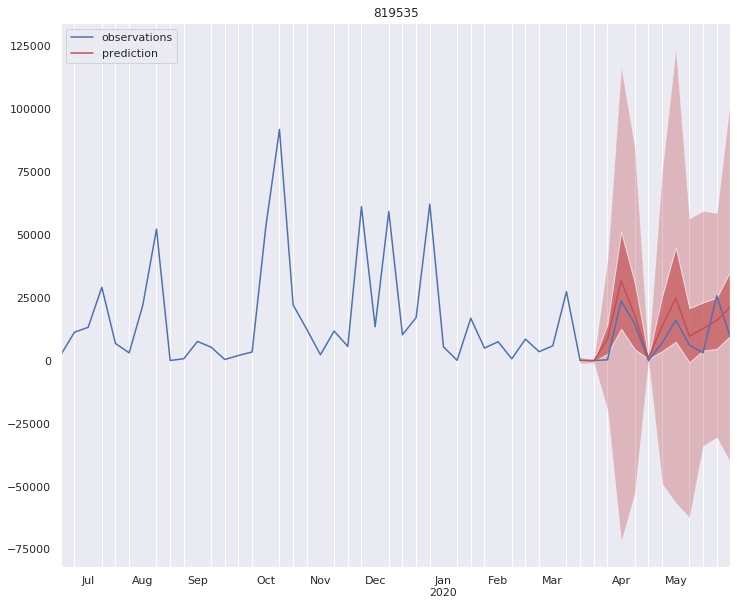

541


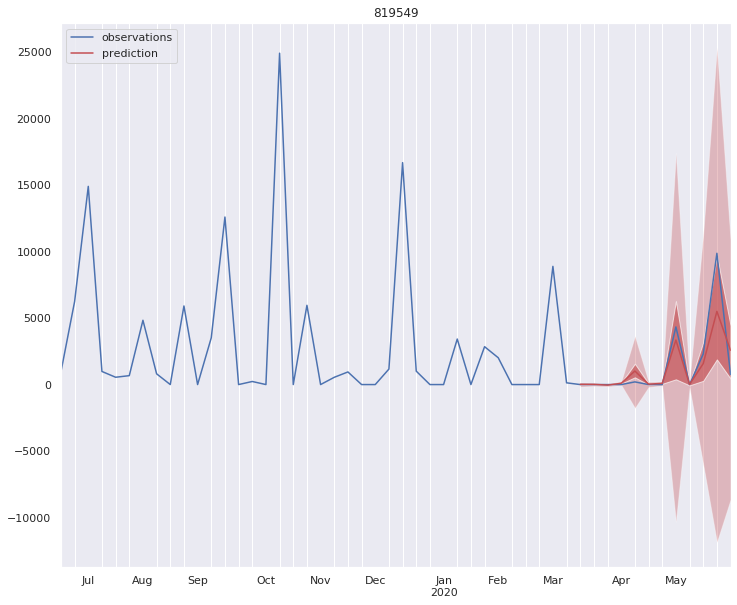

542


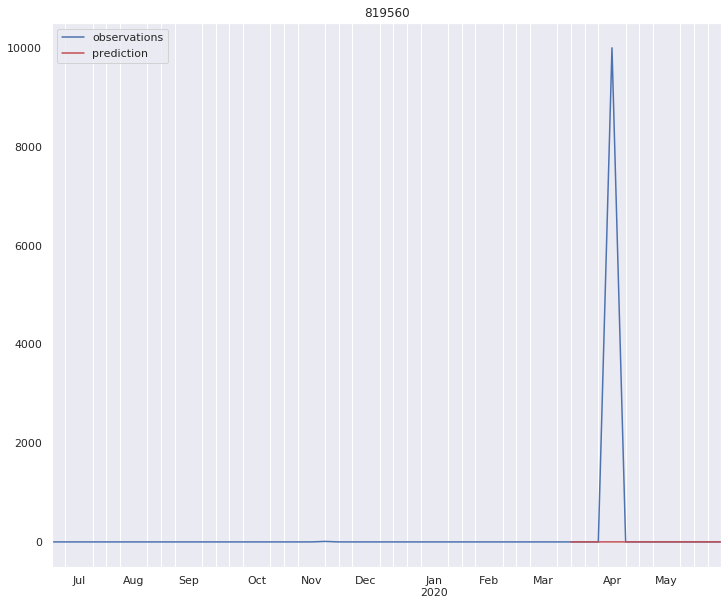

543


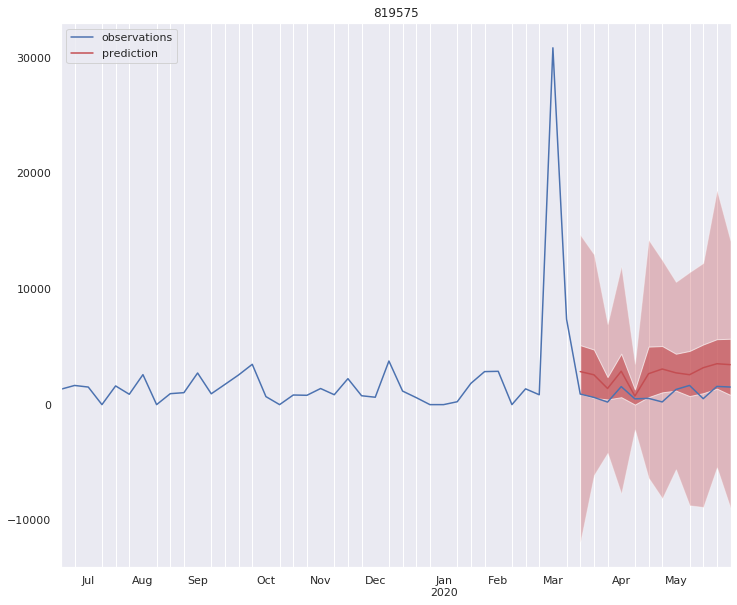

544


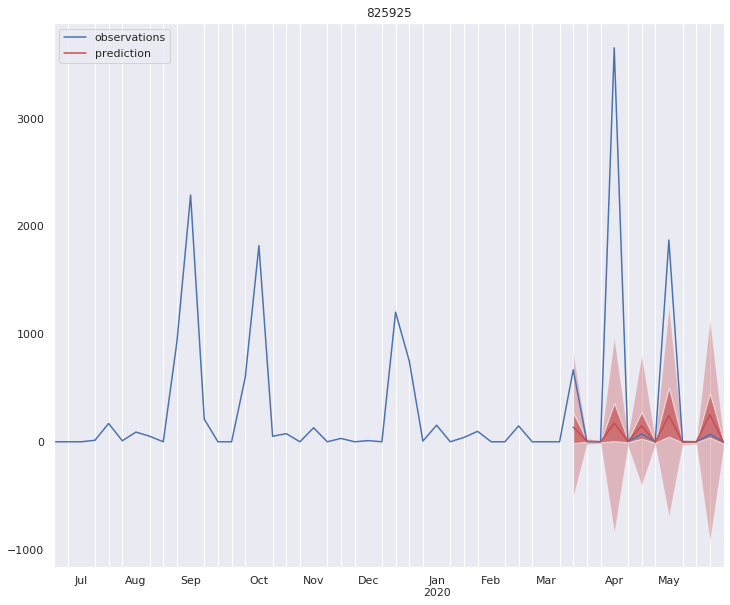

545


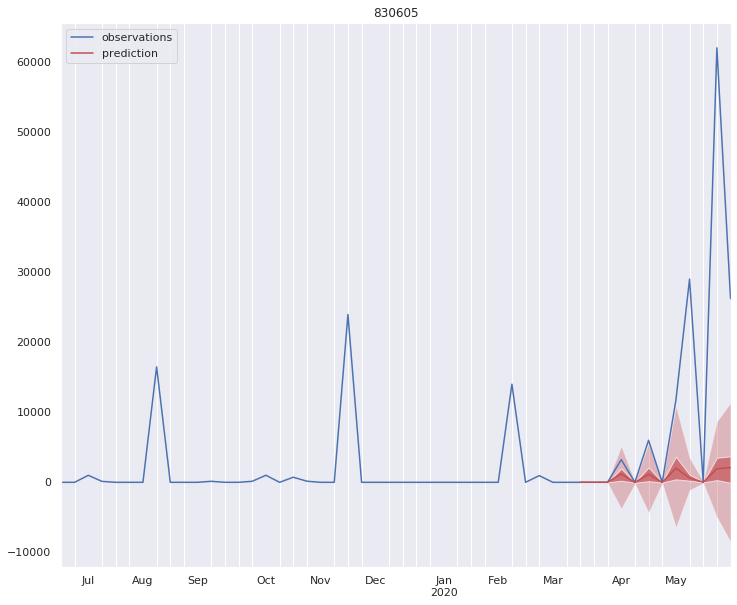

546


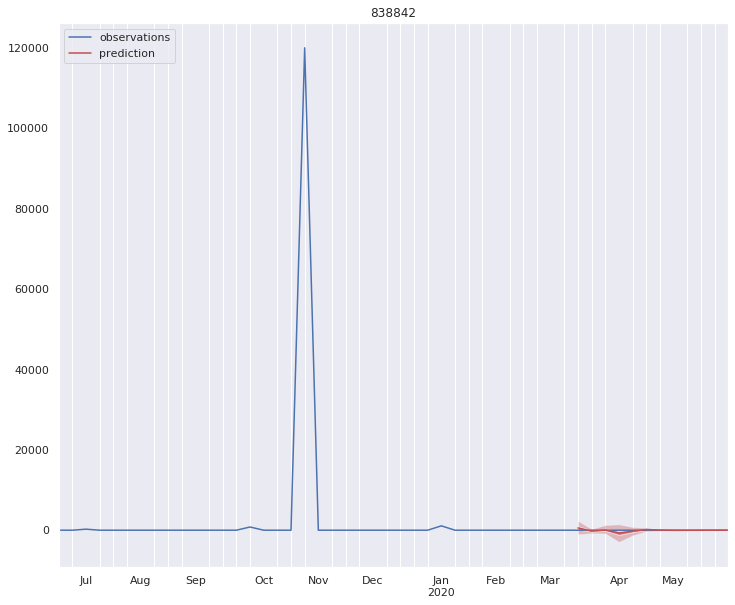

547


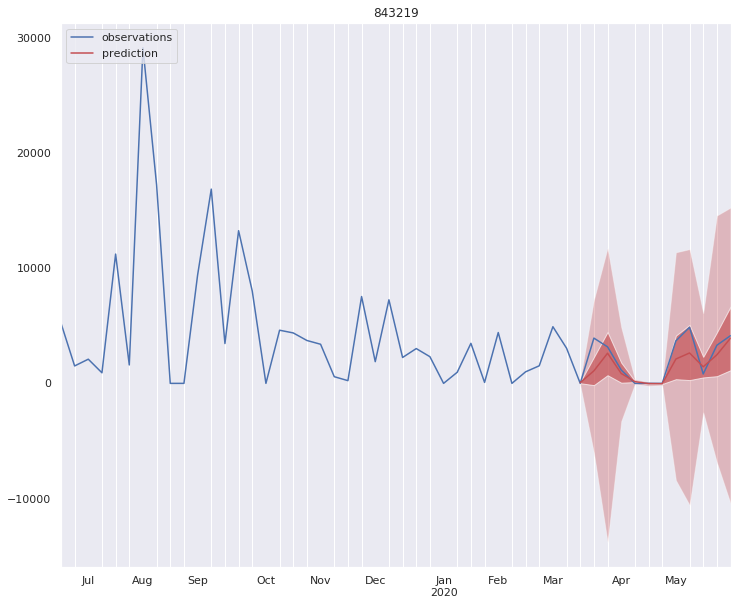

548


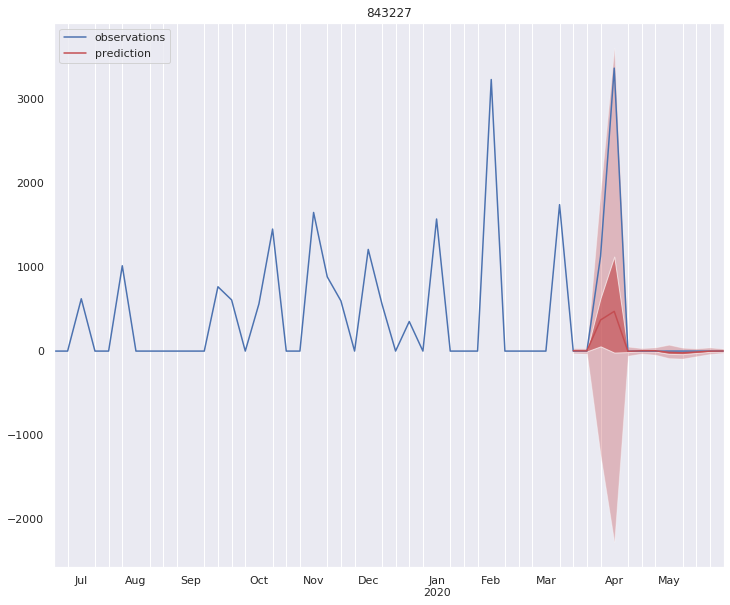

549


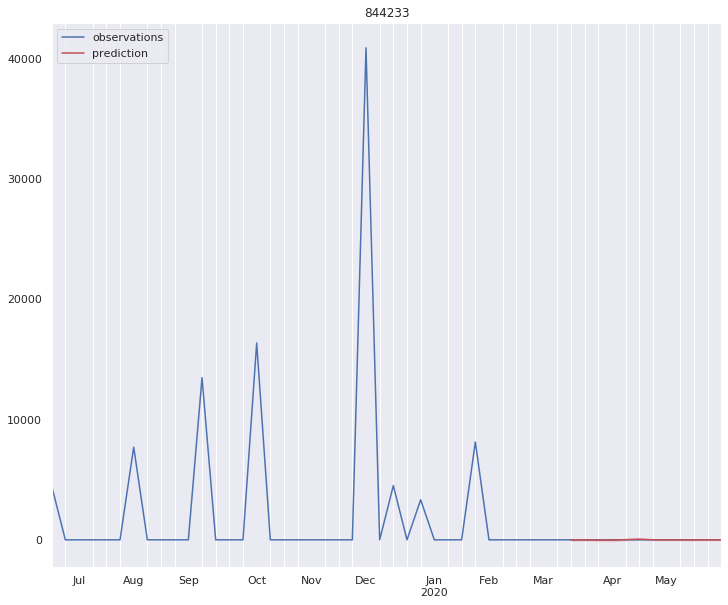

In [256]:
for i in range(500,550):
    print(i)
    plot_prob_forecasts(tss[i], forecasts[i], filenames[i])